In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
# read in TCGA raw counts in log2+1
df_TCGA = pd.read_csv("/home/cke/TCGA-HNSC.htseq_counts.tsv",sep='\t')

In [2]:
# read in processed raw TCGA counts
df_TCGA_symbol = pd.read_csv("/home/cke/TCGA-HNSC.htseq_counts_exp2_symbol.tsv",sep='\t')

In [3]:
df_TCGA_symbol

Gene_symbol  TCGA-BB-4224-01A  TCGA-H7-7774-01A  TCGA-CV-6943-01A  \
0             TSPAN6            2237.0            2740.0            2686.0   
1               TNMD               2.0               0.0               0.0   
2               DPM1            1606.0            1691.0            1649.0   
3              SCYL3            1063.0             803.0             917.0   
4           C1orf112            1208.0             317.0             402.0   
...              ...               ...               ...               ...   
38924         PAUPAR               6.0               0.0               1.0   
38925  GIMAP1-GIMAP5               0.0               0.0               0.0   
38926      LINC02246              16.0               6.0              38.0   
38927        HERC2P7               0.0               0.0               0.0   
38928      LINC01144             144.0              23.0              18.0   

       TCGA-CN-5374-01A  TCGA-CQ-6227-01A  TCGA-CV-6959-01A  TCGA-F7-A61V-01A  \
0                2086.0           10167.0            1154.0            1978.0   
1                   1.0               9.0               6.0               1.0   
2                2333.0            3021.0            2766.0            1762.0   
3                1288.0             537.0             527.0             482.0   
4                1105.0             459.0             747.0             331.0   
...                 ...               ...               ...               ...   
38924               0.0               0.0               1.0               0.0   
38925               0.0               0.0               0.0               0.0   
38926               4.0              15.0              19.0              15.0   
38927               0.0               0.0               1.0               0.0   
38928              31.0              24.0              15.0              20.0   

       TCGA-CV-7413-01A  TCGA-CV-7247-01A  ...  TCGA-CV-6960-11A  \
0                1930.0            1066.0  ...            3340.0   
1                   1.0               1.0  ...               0.0   
2                1668.0            1760.0  ...            1388.0   
3                 671.0             600.0  ...             608.0   
4                 476.0             874.0  ...             206.0   
...                 ...               ...  ...               ...   
38924               0.0               0.0  ...               0.0   
38925               0.0               0.0  ...               0.0   
38926              19.0              17.0  ...              12.0   
38927               1.0               1.0  ...               0.0   
38928              23.0              43.0  ...              19.0   

       TCGA-CV-A464-01A  TCGA-C9-A47Z-01A  TCGA-CN-6010-01A  TCGA-WA-A7GZ-11A  \
0                 929.0            1707.0            2218.0            2537.0   
1                   2.0               0.0               0.0              41.0   
2                2332.0            1926.0            1574.0            1171.0   
3                 472.0             410.0             852.0             557.0   
4                 386.0             210.0             729.0             127.0   
...                 ...               ...               ...               ...   
38924               0.0               0.0               0.0               0.0   
38925               1.0               0.0               0.0               0.0   
38926               1.0              35.0              17.0              16.0   
38927               0.0               0.0               0.0               0.0   
38928              46.0              14.0              54.0              38.0   

       TCGA-CV-7235-01A  TCGA-CX-7086-01A  TCGA-CV-6935-11A  TCGA-P3-A6SW-01A  \
0                 492.0            2741.0            8492.0             770.0   
1                   0.0               0.0               3.0               1.0   
2                 976.0            1952.0            1578.0       

### generate transposed TCGA count matrix in accordcance to pseudobulk testset in pipeline
Samples x Genes

In [11]:
# get transposed TCGA counts
df_TCGA_t = df_TCGA_symbol.T
df_TCGA_t.columns = df_TCGA_t.loc['Gene_symbol',:]
df_TCGA_t.drop('Gene_symbol',axis=0,inplace=True)
df_TCGA_t

Gene_symbol        TSPAN6 TNMD    DPM1   SCYL3 C1orf112     FGR      CFH  \
TCGA-BB-4224-01A   2237.0  2.0  1606.0  1063.0   1208.0   256.0    177.0   
TCGA-H7-7774-01A   2740.0  0.0  1691.0   803.0    317.0   330.0   5472.0   
TCGA-CV-6943-01A   2686.0  0.0  1649.0   917.0    402.0  1535.0  15358.0   
TCGA-CN-5374-01A   2086.0  1.0  2333.0  1288.0   1105.0   639.0   5565.0   
TCGA-CQ-6227-01A  10167.0  9.0  3021.0   537.0    459.0   362.0   6963.0   
...                   ...  ...     ...     ...      ...     ...      ...   
TCGA-CV-7235-01A    492.0  0.0   976.0   376.0    363.0   488.0   5178.0   
TCGA-CX-7086-01A   2741.0  0.0  1952.0  1003.0   1103.0   214.0   1809.0   
TCGA-CV-6935-11A   8492.0  3.0  1578.0   818.0    281.0   419.0   7368.0   
TCGA-P3-A6SW-01A    770.0  1.0  1569.0   620.0    591.0   462.0   2082.0   
TCGA-HD-A6HZ-01A    923.0  0.0  1183.0   607.0    344.0   925.0   2482.0   

Gene_symbol        FUCA2     GCLC    NFYA  ... LINC00550 LINC01394 LINC00602  \
TCGA-BB-4224-01A  2371.0   2741.0  2515.0  ...       6.0       7.0       0.0   
TCGA-H7-7774-01A  2316.0   8370.0   816.0  ...       0.0       1.0       0.0   
TCGA-CV-6943-01A  3490.0   4671.0  2080.0  ...       0.0       4.0       0.0   
TCGA-CN-5374-01A  2065.0   2902.0  1777.0  ...       0.0       0.0       1.0   
TCGA-CQ-6227-01A  4883.0   3140.0  2448.0  ...       1.0       3.0       0.0   
...                  ...      ...     ...  ...       ...       ...       ...   
TCGA-CV-7235-01A  2138.0  20007.0  4131.0  ...       0.0       2.0       2.0   
TCGA-CX-7086-01A  2639.0  13623.0  2530.0  ...       2.0       2.0       0.0   
TCGA-CV-6935-11A  1355.0   2276.0  1583.0  ...       0.0       1.0       0.0   
TCGA-P3-A6SW-01A  1603.0  31675.0  1473.0  ...       0.0       0.0       2.0   
TCGA-HD-A6HZ-01A  1769.0   3949.0   899.0  ...       0.0       1.0       0.0   

Gene_symbol      MIR1291 LINC00891 PAUPAR GIMAP1-GIMAP5 LINC02246 HERC2P7  \
TCGA-BB-4224-01A     2.0       0.0    6.0           0.0      16.0     0.0   
TCGA-H7-7774-01A     0.0       2.0    0.0           0.0       6.0     0.0   
TCGA-CV-6943-01A     2.0       4.0    1.0           0.0      38.0     0.0   
TCGA-CN-5374-01A     0.0       3.0    0.0           0.0       4.0     0.0   
TCGA-CQ-6227-01A     0.0       2.0    0.0           0.0      15.0     0.0   
...                  ...       ...    ...           ...       ...     ...   
TCGA-CV-7235-01A     1.0       0.0    0.0           0.0       8.0     0.0   
TCGA-CX-7086-01A     1.0       0.0    1.0           0.0      11.0     0.0   
TCGA-CV-6935-11A     1.0       0.0    0.0           0.0      12.0     0.0   
TCGA-P3-A6SW-01A     1.0       1.0    0.0           0.0       0.0     1.0   
TCGA-HD-A6HZ-01A     0.0       1.0    0.0           0.0      11.0     1.0   

Gene_symbol      LINC01144  
TCGA-BB-4224-01A     144.0  
TCGA-H7-7774-01A      23.0  
TCGA-CV-6943-01A      18.0  
TCGA-CN-5374-01A      31.0  
TCGA-CQ-6227-01A      24.0  
...                    ...  
TCGA-CV-7235-01A      60.0  
TCGA-CX-7086-01A      77.0  
TCGA-CV-6935-11A      19.0  
TCGA-P3-A6SW-01A      22.0  
TCGA-HD-A6HZ-01A      40.0  

[546 rows x 38929 columns]

In [14]:
df_TCGA_t.apply(sum,axis=1) # lost some genes due to symbol from ensid conversion

TCGA-BB-4224-01A    52092049.0
TCGA-H7-7774-01A    73022023.0
TCGA-CV-6943-01A    88582872.0
TCGA-CN-5374-01A    47625988.0
TCGA-CQ-6227-01A    77032368.0
                       ...    
TCGA-CV-7235-01A    58405857.0
TCGA-CX-7086-01A    66324802.0
TCGA-CV-6935-11A    74264020.0
TCGA-P3-A6SW-01A    37408587.0
TCGA-HD-A6HZ-01A    41007202.0
Length: 546, dtype: float64

In [13]:
df_TCGA_t.to_csv("/home/cke/TCGA-HNSC.htseq_counts_exp2_symbol_samplexgene.tsv",sep='\t')

### exp2+1 transform 

In [19]:
df_TCGA = df_TCGA.drop(df_TCGA.tail(5).index,axis=0)

In [18]:
df_TCGA

RangeIndex(start=60483, stop=60488, step=1)

In [35]:
df_TCGA.iloc[:,1:] = np.exp2(df_TCGA.iloc[:,1:])-1

In [36]:
df_TCGA

Ensembl_ID  TCGA-BB-4224-01A  TCGA-H7-7774-01A  \
0      ENSG00000000003.13            2237.0            2740.0   
1       ENSG00000000005.5               2.0               0.0   
2      ENSG00000000419.11            1606.0            1691.0   
3      ENSG00000000457.12            1063.0             803.0   
4      ENSG00000000460.15            1208.0             317.0   
...                   ...               ...               ...   
60478   ENSGR0000275287.3               0.0               0.0   
60479   ENSGR0000276543.3               0.0               0.0   
60480   ENSGR0000277120.3               0.0               0.0   
60481   ENSGR0000280767.1               0.0               0.0   
60482   ENSGR0000281849.1               0.0               0.0   

       TCGA-CV-6943-01A  TCGA-CN-5374-01A  TCGA-CQ-6227-01A  TCGA-CV-6959-01A  \
0                2686.0            2086.0           10167.0            1154.0   
1                   0.0               1.0               9.0               6.0   
2                1649.0            2333.0            3021.0            2766.0   
3                 917.0            1288.0             537.0             527.0   
4                 402.0            1105.0             459.0             747.0   
...                 ...               ...               ...               ...   
60478               0.0               0.0               0.0               0.0   
60479               0.0               0.0               0.0               0.0   
60480               0.0               0.0               0.0               0.0   
60481               0.0               0.0               0.0               0.0   
60482               0.0               0.0               0.0               0.0   

       TCGA-F7-A61V-01A  TCGA-CV-7413-01A  TCGA-CV-7247-01A  ...  \
0                1978.0            1930.0            1066.0  ...   
1                   1.0               1.0               1.0  ...   
2                1762.0            1668.0            1760.0  ...   
3                 482.0             671.0             600.0  ...   
4                 331.0             476.0             874.0  ...   
...                 ...               ...               ...  ...   
60478               0.0               0.0               0.0  ...   
60479               0.0               0.0               0.0  ...   
60480               0.0               0.0               0.0  ...   
60481               0.0               0.0               0.0  ...   
60482               0.0               0.0               0.0  ...   

       TCGA-CV-6960-11A  TCGA-CV-A464-01A  TCGA-C9-A47Z-01A  TCGA-CN-6010-01A  \
0                3340.0             929.0            1707.0            2218.0   
1                   0.0               2.0               0.0               0.0   
2                1388.0            2332.0            1926.0            1574.0   
3                 608.0             472.0             410.0             852.0   
4                 206.0             386.0             210.0             729.0   
...                 ...               ...               ...               ...   
60478               0.0               0.0               0.0               0.0   
60479               0.0               0.0               0.0               0.0   
60480               0.0               0.0               0.0               0.0   
60481               0.0               0.0               0.0               0.0   
60482               0.0               0.0               0.0               0.0   

       TCGA-WA-A7GZ-11A  TCGA-CV-7235-01A  TCGA-CX-7086-01A  TCGA-CV-6935-11A  \
0                2537.0             492.0            2741.0            8492.0   
1                  41.0               0.0               0.0               3.0   
2                1171.0             976.0            1952.0            1578.0   
3                 557.0             376.0            1003.0             818.0   
4                 127.0             363.0            1103.0       

In [44]:
df_TCGA.to_csv("/home/cke/TCGA-HNSC.htseq_counts_exp2.tsv",sep='\t',index=False)

In [2]:
df_TCGA_new = pd.read_csv("/home/cke/TCGA-HNSC.htseq_counts_exp2.tsv",sep='\t')

In [3]:
df_TCGA_new

Ensembl_ID  TCGA-BB-4224-01A  TCGA-H7-7774-01A  TCGA-CV-6943-01A  \
0      ENSG00000000003            2237.0            2740.0            2686.0   
1      ENSG00000000005               2.0               0.0               0.0   
2      ENSG00000000419            1606.0            1691.0            1649.0   
3      ENSG00000000457            1063.0             803.0             917.0   
4      ENSG00000000460            1208.0             317.0             402.0   
...                ...               ...               ...               ...   
60478  ENSGR0000275287               0.0               0.0               0.0   
60479  ENSGR0000276543               0.0               0.0               0.0   
60480  ENSGR0000277120               0.0               0.0               0.0   
60481  ENSGR0000280767               0.0               0.0               0.0   
60482  ENSGR0000281849               0.0               0.0               0.0   

       TCGA-CN-5374-01A  TCGA-CQ-6227-01A  TCGA-CV-6959-01A  TCGA-F7-A61V-01A  \
0                2086.0           10167.0            1154.0            1978.0   
1                   1.0               9.0               6.0               1.0   
2                2333.0            3021.0            2766.0            1762.0   
3                1288.0             537.0             527.0             482.0   
4                1105.0             459.0             747.0             331.0   
...                 ...               ...               ...               ...   
60478               0.0               0.0               0.0               0.0   
60479               0.0               0.0               0.0               0.0   
60480               0.0               0.0               0.0               0.0   
60481               0.0               0.0               0.0               0.0   
60482               0.0               0.0               0.0               0.0   

       TCGA-CV-7413-01A  TCGA-CV-7247-01A  ...  TCGA-CV-6960-11A  \
0                1930.0            1066.0  ...            3340.0   
1                   1.0               1.0  ...               0.0   
2                1668.0            1760.0  ...            1388.0   
3                 671.0             600.0  ...             608.0   
4                 476.0             874.0  ...             206.0   
...                 ...               ...  ...               ...   
60478               0.0               0.0  ...               0.0   
60479               0.0               0.0  ...               0.0   
60480               0.0               0.0  ...               0.0   
60481               0.0               0.0  ...               0.0   
60482               0.0               0.0  ...               0.0   

       TCGA-CV-A464-01A  TCGA-C9-A47Z-01A  TCGA-CN-6010-01A  TCGA-WA-A7GZ-11A  \
0                 929.0            1707.0            2218.0            2537.0   
1                   2.0               0.0               0.0              41.0   
2                2332.0            1926.0            1574.0            1171.0   
3                 472.0             410.0             852.0             557.0   
4                 386.0             210.0             729.0             127.0   
...                 ...               ...               ...               ...   
60478               0.0               0.0               0.0               0.0   
60479               0.0               0.0               0.0               0.0   
60480               0.0               0.0               0.0               0.0   
60481               0.0               0.0               0.0               0.0   
60482               0.0               0.0               0.0               0.0   

       TCGA-CV-7235-01A  TCGA-CX-7086-01A  TCGA-CV-6935-11A  TCGA-P3-A6SW-01A  \
0                 492.0            2741.0            8492.0             770.0   
1                   0.0               0.0               3.0               1.0   
2                 976.0            1952.0    

In [8]:
df_TCGA_new['Ensembl_ID'].duplicated().any()

False

In [81]:
for i in df_TCGA_new["Ensembl_ID"]:
#     print(i.split(".")[0])
    if i.split(".")[0] in df_Puram['X'].tolist():
        print(i," OK")

ENSG00000000003
ENSG00000000003.13  OK
ENSG00000000005
ENSG00000000005.5  OK
ENSG00000000419
ENSG00000000419.11  OK
ENSG00000000457
ENSG00000000457.12  OK
ENSG00000000460
ENSG00000000460.15  OK
ENSG00000000938
ENSG00000000938.11  OK
ENSG00000000971
ENSG00000000971.14  OK
ENSG00000001036
ENSG00000001036.12  OK
ENSG00000001084
ENSG00000001084.9  OK
ENSG00000001167
ENSG00000001167.13  OK
ENSG00000001460
ENSG00000001460.16  OK
ENSG00000001461
ENSG00000001461.15  OK
ENSG00000001497
ENSG00000001497.15  OK
ENSG00000001561
ENSG00000001561.6  OK
ENSG00000001617
ENSG00000001617.10  OK
ENSG00000001626
ENSG00000001626.13  OK
ENSG00000001629
ENSG00000001629.8  OK
ENSG00000001630
ENSG00000001630.14  OK
ENSG00000001631
ENSG00000001631.13  OK
ENSG00000002016
ENSG00000002016.15  OK
ENSG00000002079
ENSG00000002079.11  OK
ENSG00000002330
ENSG00000002330.12  OK
ENSG00000002549
ENSG00000002549.11  OK
ENSG00000002586
ENSG00000002586.16  OK
ENSG00000002587
ENSG00000002587.8  OK
ENSG00000002726
ENSG0000000274

ENSG00000017483.13  OK
ENSG00000017797
ENSG00000017797.10  OK
ENSG00000018189
ENSG00000018189.11  OK
ENSG00000018236
ENSG00000018236.13  OK
ENSG00000018280
ENSG00000018280.15  OK
ENSG00000018408
ENSG00000018408.13  OK
ENSG00000018510
ENSG00000018510.11  OK
ENSG00000018607
ENSG00000018610
ENSG00000018610.12  OK
ENSG00000018625
ENSG00000018625.13  OK
ENSG00000018699
ENSG00000018699.10  OK
ENSG00000018869
ENSG00000018869.15  OK
ENSG00000019102
ENSG00000019102.10  OK
ENSG00000019144
ENSG00000019144.15  OK
ENSG00000019169
ENSG00000019169.10  OK
ENSG00000019186
ENSG00000019186.8  OK
ENSG00000019485
ENSG00000019485.11  OK
ENSG00000019505
ENSG00000019505.6  OK
ENSG00000019549
ENSG00000019549.7  OK
ENSG00000019582
ENSG00000019582.13  OK
ENSG00000019991
ENSG00000019991.14  OK
ENSG00000019995
ENSG00000019995.6  OK
ENSG00000020129
ENSG00000020129.14  OK
ENSG00000020181
ENSG00000020181.16  OK
ENSG00000020219
ENSG00000020256
ENSG00000020256.18  OK
ENSG00000020426
ENSG00000020426.9  OK
ENSG0000002057

ENSG00000054611.12  OK
ENSG00000054654
ENSG00000054654.14  OK
ENSG00000054690
ENSG00000054690.12  OK
ENSG00000054793
ENSG00000054793.12  OK
ENSG00000054796
ENSG00000054796.11  OK
ENSG00000054803
ENSG00000054803.3  OK
ENSG00000054938
ENSG00000054938.14  OK
ENSG00000054965
ENSG00000054965.9  OK
ENSG00000054967
ENSG00000054967.11  OK
ENSG00000054983
ENSG00000054983.15  OK
ENSG00000055044
ENSG00000055044.9  OK
ENSG00000055070
ENSG00000055070.15  OK
ENSG00000055118
ENSG00000055118.13  OK
ENSG00000055130
ENSG00000055130.14  OK
ENSG00000055147
ENSG00000055147.16  OK
ENSG00000055163
ENSG00000055163.17  OK
ENSG00000055208
ENSG00000055208.16  OK
ENSG00000055211
ENSG00000055211.11  OK
ENSG00000055332
ENSG00000055332.15  OK
ENSG00000055483
ENSG00000055483.18  OK
ENSG00000055609
ENSG00000055732
ENSG00000055732.11  OK
ENSG00000055813
ENSG00000055813.5  OK
ENSG00000055917
ENSG00000055917.14  OK
ENSG00000055950
ENSG00000055950.15  OK
ENSG00000055955
ENSG00000055955.14  OK
ENSG00000055957
ENSG000000559

ENSG00000069712.10  OK
ENSG00000069764
ENSG00000069764.8  OK
ENSG00000069812
ENSG00000069812.10  OK
ENSG00000069849
ENSG00000069849.9  OK
ENSG00000069869
ENSG00000069869.14  OK
ENSG00000069943
ENSG00000069943.8  OK
ENSG00000069956
ENSG00000069956.10  OK
ENSG00000069966
ENSG00000069966.17  OK
ENSG00000069974
ENSG00000069974.14  OK
ENSG00000069998
ENSG00000069998.11  OK
ENSG00000070010
ENSG00000070010.17  OK
ENSG00000070018
ENSG00000070018.7  OK
ENSG00000070019
ENSG00000070019.4  OK
ENSG00000070031
ENSG00000070031.3  OK
ENSG00000070047
ENSG00000070047.10  OK
ENSG00000070061
ENSG00000070061.13  OK
ENSG00000070081
ENSG00000070081.14  OK
ENSG00000070087
ENSG00000070087.12  OK
ENSG00000070159
ENSG00000070159.12  OK
ENSG00000070182
ENSG00000070182.16  OK
ENSG00000070190
ENSG00000070190.11  OK
ENSG00000070193
ENSG00000070193.4  OK
ENSG00000070214
ENSG00000070214.14  OK
ENSG00000070269
ENSG00000070366
ENSG00000070366.12  OK
ENSG00000070367
ENSG00000070367.14  OK
ENSG00000070371
ENSG00000070371.

ENSG00000078898.6  OK
ENSG00000078900
ENSG00000078900.13  OK
ENSG00000078902
ENSG00000078902.14  OK
ENSG00000078967
ENSG00000078967.11  OK
ENSG00000079101
ENSG00000079101.15  OK
ENSG00000079102
ENSG00000079102.15  OK
ENSG00000079112
ENSG00000079112.8  OK
ENSG00000079134
ENSG00000079134.10  OK
ENSG00000079150
ENSG00000079150.16  OK
ENSG00000079156
ENSG00000079156.15  OK
ENSG00000079215
ENSG00000079215.12  OK
ENSG00000079246
ENSG00000079246.14  OK
ENSG00000079257
ENSG00000079257.6  OK
ENSG00000079263
ENSG00000079263.17  OK
ENSG00000079277
ENSG00000079277.18  OK
ENSG00000079308
ENSG00000079308.15  OK
ENSG00000079313
ENSG00000079313.10  OK
ENSG00000079332
ENSG00000079332.13  OK
ENSG00000079335
ENSG00000079335.16  OK
ENSG00000079337
ENSG00000079337.14  OK
ENSG00000079385
ENSG00000079385.20  OK
ENSG00000079387
ENSG00000079387.12  OK
ENSG00000079393
ENSG00000079393.19  OK
ENSG00000079432
ENSG00000079432.6  OK
ENSG00000079435
ENSG00000079435.8  OK
ENSG00000079459
ENSG00000079459.11  OK
ENSG000

ENSG00000089094.15  OK
ENSG00000089101
ENSG00000089116
ENSG00000089116.3  OK
ENSG00000089123
ENSG00000089123.14  OK
ENSG00000089127
ENSG00000089127.11  OK
ENSG00000089154
ENSG00000089154.9  OK
ENSG00000089157
ENSG00000089157.14  OK
ENSG00000089159
ENSG00000089159.14  OK
ENSG00000089163
ENSG00000089163.4  OK
ENSG00000089169
ENSG00000089169.13  OK
ENSG00000089177
ENSG00000089177.16  OK
ENSG00000089195
ENSG00000089195.13  OK
ENSG00000089199
ENSG00000089199.8  OK
ENSG00000089220
ENSG00000089220.4  OK
ENSG00000089225
ENSG00000089225.18  OK
ENSG00000089234
ENSG00000089234.14  OK
ENSG00000089248
ENSG00000089248.6  OK
ENSG00000089250
ENSG00000089250.17  OK
ENSG00000089280
ENSG00000089280.17  OK
ENSG00000089289
ENSG00000089289.14  OK
ENSG00000089327
ENSG00000089327.13  OK
ENSG00000089335
ENSG00000089335.19  OK
ENSG00000089351
ENSG00000089351.13  OK
ENSG00000089356
ENSG00000089356.15  OK
ENSG00000089472
ENSG00000089472.15  OK
ENSG00000089486
ENSG00000089486.15  OK
ENSG00000089505
ENSG00000089505

ENSG00000100056.10  OK
ENSG00000100058
ENSG00000100058.11  OK
ENSG00000100060
ENSG00000100060.16  OK
ENSG00000100065
ENSG00000100065.13  OK
ENSG00000100068
ENSG00000100068.10  OK
ENSG00000100075
ENSG00000100075.8  OK
ENSG00000100077
ENSG00000100077.13  OK
ENSG00000100078
ENSG00000100078.3  OK
ENSG00000100079
ENSG00000100079.6  OK
ENSG00000100083
ENSG00000100083.17  OK
ENSG00000100084
ENSG00000100084.13  OK
ENSG00000100092
ENSG00000100092.19  OK
ENSG00000100095
ENSG00000100095.17  OK
ENSG00000100097
ENSG00000100097.10  OK
ENSG00000100099
ENSG00000100099.19  OK
ENSG00000100100
ENSG00000100100.11  OK
ENSG00000100101
ENSG00000100104
ENSG00000100104.11  OK
ENSG00000100105
ENSG00000100105.16  OK
ENSG00000100106
ENSG00000100106.18  OK
ENSG00000100109
ENSG00000100109.15  OK
ENSG00000100116
ENSG00000100116.15  OK
ENSG00000100121
ENSG00000100121.11  OK
ENSG00000100122
ENSG00000100122.5  OK
ENSG00000100124
ENSG00000100124.11  OK
ENSG00000100129
ENSG00000100129.16  OK
ENSG00000100138
ENSG000001001

ENSG00000101327.7  OK
ENSG00000101331
ENSG00000101331.14  OK
ENSG00000101333
ENSG00000101333.15  OK
ENSG00000101335
ENSG00000101335.8  OK
ENSG00000101336
ENSG00000101336.11  OK
ENSG00000101337
ENSG00000101337.14  OK
ENSG00000101342
ENSG00000101343
ENSG00000101343.13  OK
ENSG00000101346
ENSG00000101346.10  OK
ENSG00000101347
ENSG00000101347.8  OK
ENSG00000101349
ENSG00000101349.15  OK
ENSG00000101350
ENSG00000101350.7  OK
ENSG00000101353
ENSG00000101353.13  OK
ENSG00000101361
ENSG00000101361.13  OK
ENSG00000101363
ENSG00000101363.11  OK
ENSG00000101365
ENSG00000101365.19  OK
ENSG00000101367
ENSG00000101367.8  OK
ENSG00000101384
ENSG00000101384.10  OK
ENSG00000101391
ENSG00000101391.19  OK
ENSG00000101400
ENSG00000101400.5  OK
ENSG00000101405
ENSG00000101405.3  OK
ENSG00000101407
ENSG00000101407.11  OK
ENSG00000101412
ENSG00000101412.12  OK
ENSG00000101413
ENSG00000101413.10  OK
ENSG00000101417
ENSG00000101417.10  OK
ENSG00000101421
ENSG00000101421.3  OK
ENSG00000101425
ENSG00000101425.1

ENSG00000103472.8  OK
ENSG00000103479
ENSG00000103479.13  OK
ENSG00000103485
ENSG00000103485.16  OK
ENSG00000103489
ENSG00000103489.10  OK
ENSG00000103490
ENSG00000103490.13  OK
ENSG00000103494
ENSG00000103494.11  OK
ENSG00000103495
ENSG00000103495.12  OK
ENSG00000103496
ENSG00000103496.13  OK
ENSG00000103502
ENSG00000103502.12  OK
ENSG00000103507
ENSG00000103507.12  OK
ENSG00000103510
ENSG00000103510.18  OK
ENSG00000103512
ENSG00000103512.13  OK
ENSG00000103522
ENSG00000103522.14  OK
ENSG00000103528
ENSG00000103528.15  OK
ENSG00000103534
ENSG00000103534.15  OK
ENSG00000103540
ENSG00000103540.15  OK
ENSG00000103544
ENSG00000103544.13  OK
ENSG00000103546
ENSG00000103546.17  OK
ENSG00000103549
ENSG00000103549.20  OK
ENSG00000103550
ENSG00000103569
ENSG00000103569.8  OK
ENSG00000103591
ENSG00000103591.11  OK
ENSG00000103599
ENSG00000103599.18  OK
ENSG00000103642
ENSG00000103642.10  OK
ENSG00000103647
ENSG00000103647.11  OK
ENSG00000103653
ENSG00000103653.15  OK
ENSG00000103657
ENSG0000010

ENSG00000105618.12  OK
ENSG00000105619
ENSG00000105619.12  OK
ENSG00000105639
ENSG00000105639.17  OK
ENSG00000105640
ENSG00000105640.11  OK
ENSG00000105641
ENSG00000105641.3  OK
ENSG00000105642
ENSG00000105642.14  OK
ENSG00000105643
ENSG00000105643.8  OK
ENSG00000105647
ENSG00000105647.13  OK
ENSG00000105649
ENSG00000105649.8  OK
ENSG00000105650
ENSG00000105650.20  OK
ENSG00000105655
ENSG00000105655.17  OK
ENSG00000105656
ENSG00000105656.11  OK
ENSG00000105662
ENSG00000105662.14  OK
ENSG00000105664
ENSG00000105664.9  OK
ENSG00000105668
ENSG00000105668.6  OK
ENSG00000105669
ENSG00000105669.11  OK
ENSG00000105671
ENSG00000105671.10  OK
ENSG00000105672
ENSG00000105672.13  OK
ENSG00000105675
ENSG00000105675.7  OK
ENSG00000105676
ENSG00000105676.12  OK
ENSG00000105677
ENSG00000105677.10  OK
ENSG00000105679
ENSG00000105679.7  OK
ENSG00000105694
ENSG00000105695
ENSG00000105695.13  OK
ENSG00000105696
ENSG00000105696.7  OK
ENSG00000105697
ENSG00000105697.6  OK
ENSG00000105698
ENSG00000105698.14

ENSG00000107902.12  OK
ENSG00000107929
ENSG00000107929.13  OK
ENSG00000107937
ENSG00000107937.17  OK
ENSG00000107938
ENSG00000107949
ENSG00000107949.15  OK
ENSG00000107951
ENSG00000107951.11  OK
ENSG00000107954
ENSG00000107957
ENSG00000107957.15  OK
ENSG00000107959
ENSG00000107959.14  OK
ENSG00000107960
ENSG00000107960.9  OK
ENSG00000107968
ENSG00000107968.8  OK
ENSG00000107984
ENSG00000107984.8  OK
ENSG00000108001
ENSG00000108001.12  OK
ENSG00000108010
ENSG00000108010.10  OK
ENSG00000108018
ENSG00000108018.14  OK
ENSG00000108021
ENSG00000108021.18  OK
ENSG00000108039
ENSG00000108039.16  OK
ENSG00000108055
ENSG00000108055.9  OK
ENSG00000108061
ENSG00000108061.10  OK
ENSG00000108064
ENSG00000108064.9  OK
ENSG00000108091
ENSG00000108091.10  OK
ENSG00000108094
ENSG00000108094.13  OK
ENSG00000108100
ENSG00000108100.16  OK
ENSG00000108106
ENSG00000108106.12  OK
ENSG00000108107
ENSG00000108107.11  OK
ENSG00000108175
ENSG00000108175.15  OK
ENSG00000108176
ENSG00000108176.13  OK
ENSG0000010817

ENSG00000110448.9  OK
ENSG00000110455
ENSG00000110455.12  OK
ENSG00000110484
ENSG00000110484.6  OK
ENSG00000110492
ENSG00000110492.14  OK
ENSG00000110497
ENSG00000110497.13  OK
ENSG00000110514
ENSG00000110514.17  OK
ENSG00000110536
ENSG00000110536.12  OK
ENSG00000110583
ENSG00000110583.11  OK
ENSG00000110619
ENSG00000110619.15  OK
ENSG00000110628
ENSG00000110628.12  OK
ENSG00000110651
ENSG00000110651.10  OK
ENSG00000110660
ENSG00000110660.13  OK
ENSG00000110665
ENSG00000110665.10  OK
ENSG00000110675
ENSG00000110675.11  OK
ENSG00000110680
ENSG00000110680.11  OK
ENSG00000110693
ENSG00000110693.14  OK
ENSG00000110696
ENSG00000110696.8  OK
ENSG00000110697
ENSG00000110697.11  OK
ENSG00000110700
ENSG00000110700.5  OK
ENSG00000110711
ENSG00000110711.8  OK
ENSG00000110713
ENSG00000110713.14  OK
ENSG00000110717
ENSG00000110717.9  OK
ENSG00000110719
ENSG00000110719.8  OK
ENSG00000110721
ENSG00000110721.10  OK
ENSG00000110723
ENSG00000110723.10  OK
ENSG00000110756
ENSG00000110756.16  OK
ENSG00000

ENSG00000112699.9  OK
ENSG00000112701
ENSG00000112701.16  OK
ENSG00000112706
ENSG00000112706.10  OK
ENSG00000112715
ENSG00000112715.19  OK
ENSG00000112739
ENSG00000112739.15  OK
ENSG00000112742
ENSG00000112742.8  OK
ENSG00000112759
ENSG00000112759.15  OK
ENSG00000112761
ENSG00000112761.17  OK
ENSG00000112763
ENSG00000112763.14  OK
ENSG00000112769
ENSG00000112769.17  OK
ENSG00000112773
ENSG00000112773.14  OK
ENSG00000112782
ENSG00000112782.14  OK
ENSG00000112787
ENSG00000112787.11  OK
ENSG00000112796
ENSG00000112796.8  OK
ENSG00000112799
ENSG00000112799.7  OK
ENSG00000112812
ENSG00000112812.14  OK
ENSG00000112818
ENSG00000112818.8  OK
ENSG00000112837
ENSG00000112837.15  OK
ENSG00000112851
ENSG00000112851.13  OK
ENSG00000112852
ENSG00000112852.6  OK
ENSG00000112855
ENSG00000112855.13  OK
ENSG00000112874
ENSG00000112874.8  OK
ENSG00000112877
ENSG00000112877.7  OK
ENSG00000112893
ENSG00000112893.8  OK
ENSG00000112902
ENSG00000112902.10  OK
ENSG00000112936
ENSG00000112936.17  OK
ENSG0000011

ENSG00000115355.14  OK
ENSG00000115361
ENSG00000115361.6  OK
ENSG00000115363
ENSG00000115363.12  OK
ENSG00000115364
ENSG00000115364.12  OK
ENSG00000115365
ENSG00000115365.10  OK
ENSG00000115368
ENSG00000115368.8  OK
ENSG00000115380
ENSG00000115380.17  OK
ENSG00000115386
ENSG00000115386.5  OK
ENSG00000115392
ENSG00000115392.10  OK
ENSG00000115414
ENSG00000115414.17  OK
ENSG00000115415
ENSG00000115415.17  OK
ENSG00000115419
ENSG00000115419.11  OK
ENSG00000115421
ENSG00000115421.11  OK
ENSG00000115423
ENSG00000115423.17  OK
ENSG00000115425
ENSG00000115425.12  OK
ENSG00000115446
ENSG00000115446.10  OK
ENSG00000115457
ENSG00000115457.8  OK
ENSG00000115459
ENSG00000115459.16  OK
ENSG00000115461
ENSG00000115461.4  OK
ENSG00000115464
ENSG00000115464.13  OK
ENSG00000115468
ENSG00000115468.10  OK
ENSG00000115474
ENSG00000115474.6  OK
ENSG00000115484
ENSG00000115484.13  OK
ENSG00000115486
ENSG00000115486.10  OK
ENSG00000115488
ENSG00000115488.3  OK
ENSG00000115504
ENSG00000115504.13  OK
ENSG00000

ENSG00000117500.11  OK
ENSG00000117501
ENSG00000117501.13  OK
ENSG00000117505
ENSG00000117505.11  OK
ENSG00000117507
ENSG00000117507.4  OK
ENSG00000117519
ENSG00000117519.14  OK
ENSG00000117523
ENSG00000117523.14  OK
ENSG00000117525
ENSG00000117525.12  OK
ENSG00000117528
ENSG00000117528.10  OK
ENSG00000117533
ENSG00000117533.13  OK
ENSG00000117543
ENSG00000117543.18  OK
ENSG00000117560
ENSG00000117560.7  OK
ENSG00000117569
ENSG00000117569.17  OK
ENSG00000117586
ENSG00000117586.9  OK
ENSG00000117592
ENSG00000117592.8  OK
ENSG00000117593
ENSG00000117593.9  OK
ENSG00000117594
ENSG00000117594.8  OK
ENSG00000117595
ENSG00000117595.9  OK
ENSG00000117597
ENSG00000117597.16  OK
ENSG00000117598
ENSG00000117598.10  OK
ENSG00000117600
ENSG00000117600.11  OK
ENSG00000117601
ENSG00000117601.12  OK
ENSG00000117602
ENSG00000117602.10  OK
ENSG00000117614
ENSG00000117614.8  OK
ENSG00000117616
ENSG00000117620
ENSG00000117620.11  OK
ENSG00000117625
ENSG00000117625.12  OK
ENSG00000117632
ENSG00000117632.1

ENSG00000120318.14  OK
ENSG00000120322
ENSG00000120322.3  OK
ENSG00000120324
ENSG00000120324.6  OK
ENSG00000120327
ENSG00000120327.6  OK
ENSG00000120328
ENSG00000120328.6  OK
ENSG00000120329
ENSG00000120329.6  OK
ENSG00000120332
ENSG00000120332.14  OK
ENSG00000120333
ENSG00000120333.4  OK
ENSG00000120334
ENSG00000120334.14  OK
ENSG00000120337
ENSG00000120337.8  OK
ENSG00000120341
ENSG00000120341.17  OK
ENSG00000120370
ENSG00000120370.11  OK
ENSG00000120436
ENSG00000120436.3  OK
ENSG00000120437
ENSG00000120437.8  OK
ENSG00000120438
ENSG00000120438.10  OK
ENSG00000120440
ENSG00000120440.12  OK
ENSG00000120451
ENSG00000120451.9  OK
ENSG00000120457
ENSG00000120457.10  OK
ENSG00000120458
ENSG00000120458.8  OK
ENSG00000120471
ENSG00000120471.13  OK
ENSG00000120498
ENSG00000120498.12  OK
ENSG00000120500
ENSG00000120500.16  OK
ENSG00000120509
ENSG00000120509.9  OK
ENSG00000120519
ENSG00000120519.13  OK
ENSG00000120526
ENSG00000120526.9  OK
ENSG00000120533
ENSG00000120533.11  OK
ENSG00000120539

ENSG00000123095.5  OK
ENSG00000123096
ENSG00000123096.10  OK
ENSG00000123104
ENSG00000123104.10  OK
ENSG00000123106
ENSG00000123106.9  OK
ENSG00000123119
ENSG00000123119.10  OK
ENSG00000123124
ENSG00000123124.12  OK
ENSG00000123130
ENSG00000123130.15  OK
ENSG00000123131
ENSG00000123131.11  OK
ENSG00000123136
ENSG00000123136.13  OK
ENSG00000123143
ENSG00000123143.11  OK
ENSG00000123144
ENSG00000123144.9  OK
ENSG00000123146
ENSG00000123146.18  OK
ENSG00000123154
ENSG00000123154.10  OK
ENSG00000123159
ENSG00000123159.14  OK
ENSG00000123165
ENSG00000123165.8  OK
ENSG00000123171
ENSG00000123171.6  OK
ENSG00000123178
ENSG00000123178.13  OK
ENSG00000123179
ENSG00000123179.12  OK
ENSG00000123191
ENSG00000123191.12  OK
ENSG00000123200
ENSG00000123200.15  OK
ENSG00000123201
ENSG00000123201.13  OK
ENSG00000123213
ENSG00000123213.21  OK
ENSG00000123219
ENSG00000123219.11  OK
ENSG00000123240
ENSG00000123240.15  OK
ENSG00000123243
ENSG00000123243.13  OK
ENSG00000123268
ENSG00000123268.7  OK
ENSG0000

ENSG00000125398.5  OK
ENSG00000125409
ENSG00000125409.11  OK
ENSG00000125414
ENSG00000125414.17  OK
ENSG00000125430
ENSG00000125430.7  OK
ENSG00000125434
ENSG00000125434.9  OK
ENSG00000125445
ENSG00000125445.9  OK
ENSG00000125447
ENSG00000125447.15  OK
ENSG00000125449
ENSG00000125449.5  OK
ENSG00000125450
ENSG00000125450.9  OK
ENSG00000125454
ENSG00000125454.10  OK
ENSG00000125457
ENSG00000125457.12  OK
ENSG00000125458
ENSG00000125458.5  OK
ENSG00000125459
ENSG00000125459.13  OK
ENSG00000125462
ENSG00000125462.15  OK
ENSG00000125482
ENSG00000125482.11  OK
ENSG00000125484
ENSG00000125484.10  OK
ENSG00000125485
ENSG00000125485.16  OK
ENSG00000125492
ENSG00000125492.8  OK
ENSG00000125498
ENSG00000125498.18  OK
ENSG00000125503
ENSG00000125503.11  OK
ENSG00000125505
ENSG00000125505.15  OK
ENSG00000125508
ENSG00000125508.3  OK
ENSG00000125510
ENSG00000125510.14  OK
ENSG00000125514
ENSG00000125514.8  OK
ENSG00000125520
ENSG00000125520.12  OK
ENSG00000125522
ENSG00000125522.3  OK
ENSG000001255

ENSG00000127720.6  OK
ENSG00000127743
ENSG00000127743.5  OK
ENSG00000127774
ENSG00000127774.6  OK
ENSG00000127780
ENSG00000127780.3  OK
ENSG00000127804
ENSG00000127804.11  OK
ENSG00000127824
ENSG00000127824.12  OK
ENSG00000127831
ENSG00000127831.9  OK
ENSG00000127837
ENSG00000127837.8  OK
ENSG00000127838
ENSG00000127838.12  OK
ENSG00000127863
ENSG00000127863.14  OK
ENSG00000127870
ENSG00000127870.15  OK
ENSG00000127884
ENSG00000127884.4  OK
ENSG00000127903
ENSG00000127903.13  OK
ENSG00000127914
ENSG00000127914.15  OK
ENSG00000127920
ENSG00000127920.5  OK
ENSG00000127922
ENSG00000127922.8  OK
ENSG00000127928
ENSG00000127928.11  OK
ENSG00000127946
ENSG00000127946.15  OK
ENSG00000127947
ENSG00000127947.14  OK
ENSG00000127948
ENSG00000127948.12  OK
ENSG00000127951
ENSG00000127951.5  OK
ENSG00000127952
ENSG00000127952.15  OK
ENSG00000127954
ENSG00000127954.11  OK
ENSG00000127955
ENSG00000127955.14  OK
ENSG00000127957
ENSG00000127957.15  OK
ENSG00000127980
ENSG00000127980.14  OK
ENSG00000127

ENSG00000130396.19  OK
ENSG00000130402
ENSG00000130402.10  OK
ENSG00000130413
ENSG00000130413.14  OK
ENSG00000130414
ENSG00000130414.10  OK
ENSG00000130427
ENSG00000130427.2  OK
ENSG00000130429
ENSG00000130429.11  OK
ENSG00000130433
ENSG00000130433.6  OK
ENSG00000130449
ENSG00000130449.5  OK
ENSG00000130475
ENSG00000130475.13  OK
ENSG00000130477
ENSG00000130477.13  OK
ENSG00000130479
ENSG00000130479.9  OK
ENSG00000130487
ENSG00000130487.5  OK
ENSG00000130489
ENSG00000130489.11  OK
ENSG00000130508
ENSG00000130508.9  OK
ENSG00000130511
ENSG00000130511.14  OK
ENSG00000130513
ENSG00000130513.6  OK
ENSG00000130517
ENSG00000130517.12  OK
ENSG00000130518
ENSG00000130518.15  OK
ENSG00000130520
ENSG00000130520.9  OK
ENSG00000130522
ENSG00000130522.5  OK
ENSG00000130528
ENSG00000130528.10  OK
ENSG00000130529
ENSG00000130529.14  OK
ENSG00000130538
ENSG00000130538.4  OK
ENSG00000130540
ENSG00000130540.12  OK
ENSG00000130544
ENSG00000130544.10  OK
ENSG00000130545
ENSG00000130545.14  OK
ENSG00000130

ENSG00000132334.15  OK
ENSG00000132341
ENSG00000132341.10  OK
ENSG00000132356
ENSG00000132356.10  OK
ENSG00000132357
ENSG00000132357.12  OK
ENSG00000132359
ENSG00000132359.12  OK
ENSG00000132361
ENSG00000132361.15  OK
ENSG00000132376
ENSG00000132376.18  OK
ENSG00000132382
ENSG00000132382.13  OK
ENSG00000132383
ENSG00000132383.10  OK
ENSG00000132386
ENSG00000132386.9  OK
ENSG00000132388
ENSG00000132388.11  OK
ENSG00000132394
ENSG00000132394.9  OK
ENSG00000132405
ENSG00000132405.17  OK
ENSG00000132406
ENSG00000132406.10  OK
ENSG00000132423
ENSG00000132423.9  OK
ENSG00000132424
ENSG00000132424.13  OK
ENSG00000132429
ENSG00000132429.8  OK
ENSG00000132432
ENSG00000132432.12  OK
ENSG00000132434
ENSG00000132434.8  OK
ENSG00000132436
ENSG00000132436.10  OK
ENSG00000132437
ENSG00000132437.16  OK
ENSG00000132446
ENSG00000132446.6  OK
ENSG00000132463
ENSG00000132463.12  OK
ENSG00000132464
ENSG00000132464.10  OK
ENSG00000132465
ENSG00000132465.9  OK
ENSG00000132466
ENSG00000132466.16  OK
ENSG00000

ENSG00000134291.10  OK
ENSG00000134294
ENSG00000134294.12  OK
ENSG00000134297
ENSG00000134297.6  OK
ENSG00000134308
ENSG00000134308.12  OK
ENSG00000134313
ENSG00000134313.13  OK
ENSG00000134317
ENSG00000134317.16  OK
ENSG00000134318
ENSG00000134318.12  OK
ENSG00000134321
ENSG00000134321.10  OK
ENSG00000134323
ENSG00000134323.10  OK
ENSG00000134324
ENSG00000134324.10  OK
ENSG00000134326
ENSG00000134326.10  OK
ENSG00000134330
ENSG00000134330.17  OK
ENSG00000134333
ENSG00000134333.12  OK
ENSG00000134339
ENSG00000134339.7  OK
ENSG00000134343
ENSG00000134343.11  OK
ENSG00000134352
ENSG00000134352.18  OK
ENSG00000134363
ENSG00000134363.10  OK
ENSG00000134365
ENSG00000134365.11  OK
ENSG00000134369
ENSG00000134369.14  OK
ENSG00000134371
ENSG00000134371.9  OK
ENSG00000134375
ENSG00000134375.9  OK
ENSG00000134376
ENSG00000134376.13  OK
ENSG00000134389
ENSG00000134389.9  OK
ENSG00000134398
ENSG00000134398.11  OK
ENSG00000134419
ENSG00000134419.14  OK
ENSG00000134438
ENSG00000134438.9  OK
ENSG0000

ENSG00000135960.8  OK
ENSG00000135966
ENSG00000135966.11  OK
ENSG00000135968
ENSG00000135968.18  OK
ENSG00000135972
ENSG00000135972.7  OK
ENSG00000135973
ENSG00000135973.2  OK
ENSG00000135974
ENSG00000135974.8  OK
ENSG00000135976
ENSG00000135976.15  OK
ENSG00000135999
ENSG00000135999.10  OK
ENSG00000136002
ENSG00000136002.15  OK
ENSG00000136003
ENSG00000136003.14  OK
ENSG00000136010
ENSG00000136010.12  OK
ENSG00000136011
ENSG00000136011.13  OK
ENSG00000136014
ENSG00000136014.10  OK
ENSG00000136021
ENSG00000136021.16  OK
ENSG00000136026
ENSG00000136026.12  OK
ENSG00000136040
ENSG00000136040.7  OK
ENSG00000136044
ENSG00000136044.10  OK
ENSG00000136045
ENSG00000136045.10  OK
ENSG00000136048
ENSG00000136048.12  OK
ENSG00000136051
ENSG00000136051.12  OK
ENSG00000136052
ENSG00000136052.8  OK
ENSG00000136059
ENSG00000136059.13  OK
ENSG00000136068
ENSG00000136068.13  OK
ENSG00000136098
ENSG00000136098.15  OK
ENSG00000136099
ENSG00000136099.12  OK
ENSG00000136100
ENSG00000136100.11  OK
ENSG0000

ENSG00000137558.6  OK
ENSG00000137561
ENSG00000137561.4  OK
ENSG00000137563
ENSG00000137563.10  OK
ENSG00000137571
ENSG00000137571.9  OK
ENSG00000137573
ENSG00000137573.12  OK
ENSG00000137574
ENSG00000137574.9  OK
ENSG00000137575
ENSG00000137575.10  OK
ENSG00000137601
ENSG00000137601.14  OK
ENSG00000137628
ENSG00000137628.15  OK
ENSG00000137634
ENSG00000137634.8  OK
ENSG00000137642
ENSG00000137642.11  OK
ENSG00000137648
ENSG00000137648.15  OK
ENSG00000137656
ENSG00000137656.10  OK
ENSG00000137672
ENSG00000137672.11  OK
ENSG00000137673
ENSG00000137673.7  OK
ENSG00000137674
ENSG00000137674.3  OK
ENSG00000137675
ENSG00000137675.4  OK
ENSG00000137691
ENSG00000137691.11  OK
ENSG00000137692
ENSG00000137692.10  OK
ENSG00000137693
ENSG00000137693.12  OK
ENSG00000137699
ENSG00000137699.15  OK
ENSG00000137700
ENSG00000137700.15  OK
ENSG00000137707
ENSG00000137707.12  OK
ENSG00000137709
ENSG00000137709.8  OK
ENSG00000137710
ENSG00000137710.13  OK
ENSG00000137713
ENSG00000137713.14  OK
ENSG0000013

ENSG00000139304.11  OK
ENSG00000139318
ENSG00000139318.7  OK
ENSG00000139323
ENSG00000139323.12  OK
ENSG00000139324
ENSG00000139324.10  OK
ENSG00000139329
ENSG00000139329.4  OK
ENSG00000139330
ENSG00000139330.5  OK
ENSG00000139343
ENSG00000139343.9  OK
ENSG00000139344
ENSG00000139344.6  OK
ENSG00000139350
ENSG00000139350.10  OK
ENSG00000139351
ENSG00000139351.13  OK
ENSG00000139352
ENSG00000139352.3  OK
ENSG00000139354
ENSG00000139354.9  OK
ENSG00000139364
ENSG00000139364.9  OK
ENSG00000139370
ENSG00000139370.9  OK
ENSG00000139372
ENSG00000139372.13  OK
ENSG00000139405
ENSG00000139410
ENSG00000139410.13  OK
ENSG00000139428
ENSG00000139428.10  OK
ENSG00000139433
ENSG00000139433.8  OK
ENSG00000139436
ENSG00000139436.19  OK
ENSG00000139437
ENSG00000139437.16  OK
ENSG00000139438
ENSG00000139438.5  OK
ENSG00000139445
ENSG00000139445.16  OK
ENSG00000139496
ENSG00000139496.14  OK
ENSG00000139505
ENSG00000139505.11  OK
ENSG00000139508
ENSG00000139508.13  OK
ENSG00000139514
ENSG00000139514.11  

ENSG00000141433.11  OK
ENSG00000141434
ENSG00000141434.10  OK
ENSG00000141437
ENSG00000141437.8  OK
ENSG00000141441
ENSG00000141441.14  OK
ENSG00000141446
ENSG00000141446.9  OK
ENSG00000141447
ENSG00000141447.15  OK
ENSG00000141448
ENSG00000141448.7  OK
ENSG00000141449
ENSG00000141449.13  OK
ENSG00000141452
ENSG00000141452.8  OK
ENSG00000141456
ENSG00000141456.13  OK
ENSG00000141458
ENSG00000141458.11  OK
ENSG00000141469
ENSG00000141469.15  OK
ENSG00000141480
ENSG00000141480.16  OK
ENSG00000141485
ENSG00000141485.14  OK
ENSG00000141497
ENSG00000141497.12  OK
ENSG00000141499
ENSG00000141499.15  OK
ENSG00000141503
ENSG00000141503.14  OK
ENSG00000141504
ENSG00000141504.10  OK
ENSG00000141505
ENSG00000141505.10  OK
ENSG00000141506
ENSG00000141506.12  OK
ENSG00000141510
ENSG00000141510.14  OK
ENSG00000141519
ENSG00000141519.13  OK
ENSG00000141522
ENSG00000141522.10  OK
ENSG00000141524
ENSG00000141524.14  OK
ENSG00000141526
ENSG00000141526.13  OK
ENSG00000141527
ENSG00000141527.15  OK
ENSG00

ENSG00000143502.13  OK
ENSG00000143507
ENSG00000143507.16  OK
ENSG00000143512
ENSG00000143512.11  OK
ENSG00000143514
ENSG00000143514.15  OK
ENSG00000143515
ENSG00000143515.15  OK
ENSG00000143520
ENSG00000143520.6  OK
ENSG00000143536
ENSG00000143536.7  OK
ENSG00000143537
ENSG00000143537.12  OK
ENSG00000143543
ENSG00000143543.13  OK
ENSG00000143545
ENSG00000143545.7  OK
ENSG00000143546
ENSG00000143546.8  OK
ENSG00000143549
ENSG00000143549.18  OK
ENSG00000143552
ENSG00000143552.8  OK
ENSG00000143553
ENSG00000143553.9  OK
ENSG00000143554
ENSG00000143554.12  OK
ENSG00000143556
ENSG00000143556.7  OK
ENSG00000143569
ENSG00000143569.17  OK
ENSG00000143570
ENSG00000143570.16  OK
ENSG00000143575
ENSG00000143575.13  OK
ENSG00000143578
ENSG00000143578.14  OK
ENSG00000143590
ENSG00000143590.12  OK
ENSG00000143595
ENSG00000143595.11  OK
ENSG00000143603
ENSG00000143603.17  OK
ENSG00000143612
ENSG00000143612.17  OK
ENSG00000143614
ENSG00000143614.7  OK
ENSG00000143621
ENSG00000143621.15  OK
ENSG000001

ENSG00000145826.7  OK
ENSG00000145832
ENSG00000145832.11  OK
ENSG00000145833
ENSG00000145833.14  OK
ENSG00000145835
ENSG00000145839
ENSG00000145839.1  OK
ENSG00000145850
ENSG00000145850.7  OK
ENSG00000145860
ENSG00000145860.10  OK
ENSG00000145861
ENSG00000145861.7  OK
ENSG00000145863
ENSG00000145863.9  OK
ENSG00000145864
ENSG00000145864.11  OK
ENSG00000145868
ENSG00000145868.15  OK
ENSG00000145879
ENSG00000145879.9  OK
ENSG00000145882
ENSG00000145882.9  OK
ENSG00000145888
ENSG00000145888.9  OK
ENSG00000145901
ENSG00000145901.13  OK
ENSG00000145907
ENSG00000145907.13  OK
ENSG00000145908
ENSG00000145908.11  OK
ENSG00000145911
ENSG00000145911.5  OK
ENSG00000145912
ENSG00000145912.7  OK
ENSG00000145916
ENSG00000145916.17  OK
ENSG00000145919
ENSG00000145919.9  OK
ENSG00000145920
ENSG00000145920.13  OK
ENSG00000145934
ENSG00000145934.14  OK
ENSG00000145936
ENSG00000145936.7  OK
ENSG00000145945
ENSG00000145945.5  OK
ENSG00000145949
ENSG00000145949.9  OK
ENSG00000145975
ENSG00000145975.12  OK


ENSG00000148358
ENSG00000148358.18  OK
ENSG00000148362
ENSG00000148362.9  OK
ENSG00000148377
ENSG00000148377.5  OK
ENSG00000148384
ENSG00000148384.11  OK
ENSG00000148386
ENSG00000148386.8  OK
ENSG00000148396
ENSG00000148396.17  OK
ENSG00000148399
ENSG00000148400
ENSG00000148400.9  OK
ENSG00000148408
ENSG00000148408.11  OK
ENSG00000148411
ENSG00000148411.6  OK
ENSG00000148426
ENSG00000148426.11  OK
ENSG00000148429
ENSG00000148429.13  OK
ENSG00000148444
ENSG00000148444.14  OK
ENSG00000148450
ENSG00000148450.11  OK
ENSG00000148459
ENSG00000148459.14  OK
ENSG00000148468
ENSG00000148468.15  OK
ENSG00000148481
ENSG00000148481.12  OK
ENSG00000148482
ENSG00000148482.10  OK
ENSG00000148483
ENSG00000148483.8  OK
ENSG00000148484
ENSG00000148484.16  OK
ENSG00000148488
ENSG00000148488.14  OK
ENSG00000148498
ENSG00000148498.14  OK
ENSG00000148513
ENSG00000148513.16  OK
ENSG00000148516
ENSG00000148516.20  OK
ENSG00000148541
ENSG00000148541.11  OK
ENSG00000148572
ENSG00000148572.13  OK
ENSG00000148584

ENSG00000151490.12  OK
ENSG00000151491
ENSG00000151491.11  OK
ENSG00000151498
ENSG00000151498.10  OK
ENSG00000151500
ENSG00000151500.13  OK
ENSG00000151502
ENSG00000151502.9  OK
ENSG00000151503
ENSG00000151503.11  OK
ENSG00000151532
ENSG00000151532.12  OK
ENSG00000151552
ENSG00000151552.10  OK
ENSG00000151553
ENSG00000151553.13  OK
ENSG00000151572
ENSG00000151572.15  OK
ENSG00000151575
ENSG00000151575.13  OK
ENSG00000151576
ENSG00000151576.9  OK
ENSG00000151577
ENSG00000151577.11  OK
ENSG00000151611
ENSG00000151611.12  OK
ENSG00000151612
ENSG00000151612.14  OK
ENSG00000151615
ENSG00000151615.3  OK
ENSG00000151617
ENSG00000151617.14  OK
ENSG00000151623
ENSG00000151623.13  OK
ENSG00000151631
ENSG00000151631.8  OK
ENSG00000151632
ENSG00000151632.15  OK
ENSG00000151640
ENSG00000151640.11  OK
ENSG00000151650
ENSG00000151650.7  OK
ENSG00000151651
ENSG00000151651.14  OK
ENSG00000151655
ENSG00000151655.16  OK
ENSG00000151657
ENSG00000151657.10  OK
ENSG00000151665
ENSG00000151665.11  OK
ENSG000

ENSG00000154165.4  OK
ENSG00000154174
ENSG00000154174.7  OK
ENSG00000154175
ENSG00000154175.15  OK
ENSG00000154188
ENSG00000154188.8  OK
ENSG00000154198
ENSG00000154198.13  OK
ENSG00000154217
ENSG00000154217.13  OK
ENSG00000154222
ENSG00000154222.13  OK
ENSG00000154227
ENSG00000154227.12  OK
ENSG00000154229
ENSG00000154229.10  OK
ENSG00000154237
ENSG00000154237.11  OK
ENSG00000154240
ENSG00000154240.15  OK
ENSG00000154252
ENSG00000154252.11  OK
ENSG00000154258
ENSG00000154258.15  OK
ENSG00000154262
ENSG00000154262.11  OK
ENSG00000154263
ENSG00000154263.16  OK
ENSG00000154265
ENSG00000154265.14  OK
ENSG00000154269
ENSG00000154269.13  OK
ENSG00000154274
ENSG00000154274.13  OK
ENSG00000154277
ENSG00000154277.11  OK
ENSG00000154305
ENSG00000154305.15  OK
ENSG00000154309
ENSG00000154309.8  OK
ENSG00000154310
ENSG00000154310.15  OK
ENSG00000154316
ENSG00000154316.13  OK
ENSG00000154319
ENSG00000154319.13  OK
ENSG00000154328
ENSG00000154328.14  OK
ENSG00000154330
ENSG00000154330.11  OK
ENSG00

ENSG00000157020.16  OK
ENSG00000157021
ENSG00000157036
ENSG00000157036.11  OK
ENSG00000157045
ENSG00000157045.7  OK
ENSG00000157060
ENSG00000157060.13  OK
ENSG00000157064
ENSG00000157064.9  OK
ENSG00000157077
ENSG00000157077.13  OK
ENSG00000157087
ENSG00000157087.15  OK
ENSG00000157093
ENSG00000157093.7  OK
ENSG00000157103
ENSG00000157103.9  OK
ENSG00000157106
ENSG00000157106.15  OK
ENSG00000157107
ENSG00000157107.12  OK
ENSG00000157110
ENSG00000157110.14  OK
ENSG00000157111
ENSG00000157111.11  OK
ENSG00000157119
ENSG00000157119.11  OK
ENSG00000157131
ENSG00000157131.10  OK
ENSG00000157150
ENSG00000157150.4  OK
ENSG00000157152
ENSG00000157152.15  OK
ENSG00000157168
ENSG00000157168.17  OK
ENSG00000157181
ENSG00000157181.13  OK
ENSG00000157184
ENSG00000157184.5  OK
ENSG00000157191
ENSG00000157191.18  OK
ENSG00000157193
ENSG00000157193.13  OK
ENSG00000157211
ENSG00000157211.10  OK
ENSG00000157212
ENSG00000157212.17  OK
ENSG00000157214
ENSG00000157214.12  OK
ENSG00000157216
ENSG00000157216

ENSG00000159733.12  OK
ENSG00000159753
ENSG00000159753.12  OK
ENSG00000159761
ENSG00000159761.13  OK
ENSG00000159763
ENSG00000159763.3  OK
ENSG00000159784
ENSG00000159784.16  OK
ENSG00000159788
ENSG00000159788.17  OK
ENSG00000159792
ENSG00000159792.8  OK
ENSG00000159840
ENSG00000159840.14  OK
ENSG00000159842
ENSG00000159842.13  OK
ENSG00000159860
ENSG00000159871
ENSG00000159871.13  OK
ENSG00000159873
ENSG00000159873.8  OK
ENSG00000159882
ENSG00000159882.11  OK
ENSG00000159884
ENSG00000159884.10  OK
ENSG00000159885
ENSG00000159885.12  OK
ENSG00000159899
ENSG00000159899.13  OK
ENSG00000159904
ENSG00000159904.10  OK
ENSG00000159905
ENSG00000159905.13  OK
ENSG00000159915
ENSG00000159915.11  OK
ENSG00000159917
ENSG00000159917.13  OK
ENSG00000159921
ENSG00000159921.13  OK
ENSG00000159958
ENSG00000159958.4  OK
ENSG00000159961
ENSG00000159961.1  OK
ENSG00000160007
ENSG00000160007.16  OK
ENSG00000160013
ENSG00000160013.7  OK
ENSG00000160014
ENSG00000160014.15  OK
ENSG00000160049
ENSG00000160049

ENSG00000162236.10  OK
ENSG00000162241
ENSG00000162241.11  OK
ENSG00000162244
ENSG00000162244.9  OK
ENSG00000162267
ENSG00000162267.11  OK
ENSG00000162298
ENSG00000162298.15  OK
ENSG00000162300
ENSG00000162300.10  OK
ENSG00000162302
ENSG00000162302.11  OK
ENSG00000162337
ENSG00000162337.10  OK
ENSG00000162341
ENSG00000162341.14  OK
ENSG00000162344
ENSG00000162344.3  OK
ENSG00000162365
ENSG00000162365.10  OK
ENSG00000162366
ENSG00000162366.6  OK
ENSG00000162367
ENSG00000162367.10  OK
ENSG00000162368
ENSG00000162368.12  OK
ENSG00000162373
ENSG00000162373.11  OK
ENSG00000162374
ENSG00000162374.15  OK
ENSG00000162377
ENSG00000162378
ENSG00000162378.11  OK
ENSG00000162383
ENSG00000162383.10  OK
ENSG00000162384
ENSG00000162384.12  OK
ENSG00000162385
ENSG00000162385.9  OK
ENSG00000162390
ENSG00000162390.16  OK
ENSG00000162391
ENSG00000162391.10  OK
ENSG00000162396
ENSG00000162396.5  OK
ENSG00000162398
ENSG00000162398.10  OK
ENSG00000162399
ENSG00000162399.6  OK
ENSG00000162402
ENSG00000162402

ENSG00000163481.6  OK
ENSG00000163482
ENSG00000163482.10  OK
ENSG00000163485
ENSG00000163485.14  OK
ENSG00000163491
ENSG00000163491.15  OK
ENSG00000163492
ENSG00000163492.12  OK
ENSG00000163497
ENSG00000163497.2  OK
ENSG00000163499
ENSG00000163499.10  OK
ENSG00000163501
ENSG00000163501.6  OK
ENSG00000163507
ENSG00000163507.12  OK
ENSG00000163508
ENSG00000163508.11  OK
ENSG00000163510
ENSG00000163510.12  OK
ENSG00000163512
ENSG00000163512.12  OK
ENSG00000163513
ENSG00000163513.16  OK
ENSG00000163515
ENSG00000163515.6  OK
ENSG00000163516
ENSG00000163516.12  OK
ENSG00000163517
ENSG00000163517.13  OK
ENSG00000163518
ENSG00000163518.9  OK
ENSG00000163519
ENSG00000163519.12  OK
ENSG00000163520
ENSG00000163520.12  OK
ENSG00000163521
ENSG00000163521.14  OK
ENSG00000163527
ENSG00000163527.8  OK
ENSG00000163528
ENSG00000163528.11  OK
ENSG00000163530
ENSG00000163530.4  OK
ENSG00000163531
ENSG00000163531.14  OK
ENSG00000163534
ENSG00000163534.13  OK
ENSG00000163535
ENSG00000163535.16  OK
ENSG00000

ENSG00000164329.12  OK
ENSG00000164330
ENSG00000164330.15  OK
ENSG00000164331
ENSG00000164331.8  OK
ENSG00000164332
ENSG00000164332.7  OK
ENSG00000164334
ENSG00000164334.14  OK
ENSG00000164338
ENSG00000164338.8  OK
ENSG00000164342
ENSG00000164342.11  OK
ENSG00000164344
ENSG00000164344.14  OK
ENSG00000164346
ENSG00000164346.8  OK
ENSG00000164347
ENSG00000164347.16  OK
ENSG00000164362
ENSG00000164362.17  OK
ENSG00000164363
ENSG00000164363.9  OK
ENSG00000164366
ENSG00000164366.3  OK
ENSG00000164379
ENSG00000164379.5  OK
ENSG00000164385
ENSG00000164385.7  OK
ENSG00000164393
ENSG00000164393.7  OK
ENSG00000164398
ENSG00000164398.11  OK
ENSG00000164399
ENSG00000164399.4  OK
ENSG00000164400
ENSG00000164400.5  OK
ENSG00000164402
ENSG00000164402.12  OK
ENSG00000164403
ENSG00000164403.13  OK
ENSG00000164404
ENSG00000164404.7  OK
ENSG00000164405
ENSG00000164405.9  OK
ENSG00000164406
ENSG00000164406.7  OK
ENSG00000164411
ENSG00000164411.9  OK
ENSG00000164414
ENSG00000164414.15  OK
ENSG00000164418
E

ENSG00000165609.11  OK
ENSG00000165617
ENSG00000165617.13  OK
ENSG00000165621
ENSG00000165621.7  OK
ENSG00000165623
ENSG00000165623.8  OK
ENSG00000165626
ENSG00000165626.15  OK
ENSG00000165629
ENSG00000165629.18  OK
ENSG00000165630
ENSG00000165630.12  OK
ENSG00000165632
ENSG00000165632.7  OK
ENSG00000165633
ENSG00000165633.11  OK
ENSG00000165637
ENSG00000165637.12  OK
ENSG00000165643
ENSG00000165643.9  OK
ENSG00000165644
ENSG00000165644.9  OK
ENSG00000165646
ENSG00000165646.10  OK
ENSG00000165650
ENSG00000165650.10  OK
ENSG00000165655
ENSG00000165655.15  OK
ENSG00000165660
ENSG00000165660.7  OK
ENSG00000165661
ENSG00000165661.14  OK
ENSG00000165669
ENSG00000165669.12  OK
ENSG00000165671
ENSG00000165671.17  OK
ENSG00000165672
ENSG00000165672.6  OK
ENSG00000165675
ENSG00000165675.15  OK
ENSG00000165678
ENSG00000165678.18  OK
ENSG00000165682
ENSG00000165682.13  OK
ENSG00000165684
ENSG00000165684.3  OK
ENSG00000165685
ENSG00000165685.7  OK
ENSG00000165688
ENSG00000165688.10  OK
ENSG0000016

ENSG00000166800.8  OK
ENSG00000166801
ENSG00000166801.14  OK
ENSG00000166803
ENSG00000166803.9  OK
ENSG00000166813
ENSG00000166813.13  OK
ENSG00000166816
ENSG00000166816.12  OK
ENSG00000166819
ENSG00000166819.10  OK
ENSG00000166821
ENSG00000166821.7  OK
ENSG00000166822
ENSG00000166822.11  OK
ENSG00000166823
ENSG00000166823.5  OK
ENSG00000166825
ENSG00000166825.12  OK
ENSG00000166828
ENSG00000166828.2  OK
ENSG00000166831
ENSG00000166831.7  OK
ENSG00000166833
ENSG00000166833.18  OK
ENSG00000166839
ENSG00000166839.15  OK
ENSG00000166840
ENSG00000166840.12  OK
ENSG00000166845
ENSG00000166845.12  OK
ENSG00000166847
ENSG00000166847.8  OK
ENSG00000166848
ENSG00000166848.5  OK
ENSG00000166851
ENSG00000166851.13  OK
ENSG00000166855
ENSG00000166855.8  OK
ENSG00000166856
ENSG00000166856.2  OK
ENSG00000166860
ENSG00000166860.2  OK
ENSG00000166862
ENSG00000166862.6  OK
ENSG00000166863
ENSG00000166863.10  OK
ENSG00000166866
ENSG00000166866.11  OK
ENSG00000166869
ENSG00000166869.2  OK
ENSG00000166881

ENSG00000167842.14  OK
ENSG00000167850
ENSG00000167850.3  OK
ENSG00000167851
ENSG00000167851.12  OK
ENSG00000167858
ENSG00000167858.11  OK
ENSG00000167861
ENSG00000167861.14  OK
ENSG00000167862
ENSG00000167862.8  OK
ENSG00000167863
ENSG00000167863.10  OK
ENSG00000167874
ENSG00000167874.6  OK
ENSG00000167880
ENSG00000167880.6  OK
ENSG00000167881
ENSG00000167881.13  OK
ENSG00000167889
ENSG00000167889.11  OK
ENSG00000167895
ENSG00000167895.13  OK
ENSG00000167900
ENSG00000167900.10  OK
ENSG00000167904
ENSG00000167904.13  OK
ENSG00000167910
ENSG00000167910.3  OK
ENSG00000167912
ENSG00000167914
ENSG00000167914.9  OK
ENSG00000167916
ENSG00000167916.4  OK
ENSG00000167920
ENSG00000167920.7  OK
ENSG00000167925
ENSG00000167925.14  OK
ENSG00000167930
ENSG00000167930.14  OK
ENSG00000167941
ENSG00000167941.2  OK
ENSG00000167945
ENSG00000167945.1  OK
ENSG00000167962
ENSG00000167962.11  OK
ENSG00000167964
ENSG00000167964.11  OK
ENSG00000167965
ENSG00000167965.16  OK
ENSG00000167967
ENSG00000167967.14 

ENSG00000169139.10  OK
ENSG00000169154
ENSG00000169154.5  OK
ENSG00000169155
ENSG00000169155.8  OK
ENSG00000169164
ENSG00000169169
ENSG00000169169.13  OK
ENSG00000169174
ENSG00000169174.10  OK
ENSG00000169180
ENSG00000169180.10  OK
ENSG00000169181
ENSG00000169181.11  OK
ENSG00000169184
ENSG00000169184.5  OK
ENSG00000169188
ENSG00000169188.4  OK
ENSG00000169189
ENSG00000169189.15  OK
ENSG00000169193
ENSG00000169193.10  OK
ENSG00000169194
ENSG00000169194.8  OK
ENSG00000169203
ENSG00000169208
ENSG00000169208.1  OK
ENSG00000169213
ENSG00000169213.6  OK
ENSG00000169214
ENSG00000169214.3  OK
ENSG00000169217
ENSG00000169217.7  OK
ENSG00000169218
ENSG00000169218.12  OK
ENSG00000169220
ENSG00000169220.16  OK
ENSG00000169221
ENSG00000169221.12  OK
ENSG00000169223
ENSG00000169223.13  OK
ENSG00000169224
ENSG00000169224.11  OK
ENSG00000169228
ENSG00000169228.12  OK
ENSG00000169230
ENSG00000169230.8  OK
ENSG00000169231
ENSG00000169231.12  OK
ENSG00000169239
ENSG00000169239.11  OK
ENSG00000169241
ENS

ENSG00000170473.15  OK
ENSG00000170476
ENSG00000170476.14  OK
ENSG00000170477
ENSG00000170477.11  OK
ENSG00000170482
ENSG00000170482.15  OK
ENSG00000170484
ENSG00000170484.8  OK
ENSG00000170485
ENSG00000170485.15  OK
ENSG00000170486
ENSG00000170486.9  OK
ENSG00000170498
ENSG00000170498.8  OK
ENSG00000170500
ENSG00000170500.11  OK
ENSG00000170502
ENSG00000170502.11  OK
ENSG00000170509
ENSG00000170509.10  OK
ENSG00000170515
ENSG00000170515.12  OK
ENSG00000170516
ENSG00000170516.15  OK
ENSG00000170522
ENSG00000170522.8  OK
ENSG00000170523
ENSG00000170523.3  OK
ENSG00000170525
ENSG00000170525.17  OK
ENSG00000170537
ENSG00000170537.11  OK
ENSG00000170540
ENSG00000170540.13  OK
ENSG00000170542
ENSG00000170542.5  OK
ENSG00000170545
ENSG00000170545.15  OK
ENSG00000170549
ENSG00000170549.3  OK
ENSG00000170558
ENSG00000170558.7  OK
ENSG00000170561
ENSG00000170561.11  OK
ENSG00000170571
ENSG00000170571.10  OK
ENSG00000170577
ENSG00000170577.7  OK
ENSG00000170579
ENSG00000170579.13  OK
ENSG0000017

ENSG00000171777.14  OK
ENSG00000171786
ENSG00000171786.5  OK
ENSG00000171790
ENSG00000171790.14  OK
ENSG00000171791
ENSG00000171791.11  OK
ENSG00000171792
ENSG00000171792.9  OK
ENSG00000171793
ENSG00000171793.12  OK
ENSG00000171794
ENSG00000171794.3  OK
ENSG00000171798
ENSG00000171798.16  OK
ENSG00000171804
ENSG00000171804.8  OK
ENSG00000171806
ENSG00000171806.10  OK
ENSG00000171811
ENSG00000171812
ENSG00000171812.9  OK
ENSG00000171813
ENSG00000171813.12  OK
ENSG00000171815
ENSG00000171815.5  OK
ENSG00000171817
ENSG00000171817.15  OK
ENSG00000171819
ENSG00000171819.4  OK
ENSG00000171823
ENSG00000171823.6  OK
ENSG00000171824
ENSG00000171824.12  OK
ENSG00000171827
ENSG00000171827.9  OK
ENSG00000171840
ENSG00000171840.10  OK
ENSG00000171843
ENSG00000171843.14  OK
ENSG00000171847
ENSG00000171847.9  OK
ENSG00000171848
ENSG00000171848.12  OK
ENSG00000171853
ENSG00000171853.14  OK
ENSG00000171855
ENSG00000171855.6  OK
ENSG00000171858
ENSG00000171858.16  OK
ENSG00000171860
ENSG00000171860.4  O

ENSG00000173145.10  OK
ENSG00000173153
ENSG00000173153.12  OK
ENSG00000173156
ENSG00000173156.5  OK
ENSG00000173157
ENSG00000173157.15  OK
ENSG00000173163
ENSG00000173163.9  OK
ENSG00000173166
ENSG00000173166.16  OK
ENSG00000173171
ENSG00000173171.13  OK
ENSG00000173175
ENSG00000173175.13  OK
ENSG00000173193
ENSG00000173193.12  OK
ENSG00000173198
ENSG00000173198.5  OK
ENSG00000173200
ENSG00000173200.11  OK
ENSG00000173207
ENSG00000173207.11  OK
ENSG00000173208
ENSG00000173208.3  OK
ENSG00000173209
ENSG00000173209.21  OK
ENSG00000173210
ENSG00000173210.18  OK
ENSG00000173212
ENSG00000173212.4  OK
ENSG00000173213
ENSG00000173214
ENSG00000173214.5  OK
ENSG00000173218
ENSG00000173218.13  OK
ENSG00000173221
ENSG00000173221.12  OK
ENSG00000173226
ENSG00000173226.15  OK
ENSG00000173227
ENSG00000173227.12  OK
ENSG00000173230
ENSG00000173230.14  OK
ENSG00000173231
ENSG00000173237
ENSG00000173237.4  OK
ENSG00000173239
ENSG00000173239.12  OK
ENSG00000173250
ENSG00000173250.2  OK
ENSG00000173253
E

ENSG00000174796.11  OK
ENSG00000174799
ENSG00000174799.9  OK
ENSG00000174804
ENSG00000174804.3  OK
ENSG00000174807
ENSG00000174807.3  OK
ENSG00000174808
ENSG00000174808.10  OK
ENSG00000174827
ENSG00000174827.12  OK
ENSG00000174837
ENSG00000174837.13  OK
ENSG00000174839
ENSG00000174839.11  OK
ENSG00000174840
ENSG00000174840.8  OK
ENSG00000174842
ENSG00000174842.15  OK
ENSG00000174844
ENSG00000174844.13  OK
ENSG00000174851
ENSG00000174851.13  OK
ENSG00000174871
ENSG00000174871.9  OK
ENSG00000174876
ENSG00000174876.15  OK
ENSG00000174885
ENSG00000174885.11  OK
ENSG00000174886
ENSG00000174886.11  OK
ENSG00000174891
ENSG00000174891.11  OK
ENSG00000174898
ENSG00000174898.14  OK
ENSG00000174899
ENSG00000174903
ENSG00000174903.13  OK
ENSG00000174912
ENSG00000174914
ENSG00000174914.1  OK
ENSG00000174915
ENSG00000174915.10  OK
ENSG00000174917
ENSG00000174917.7  OK
ENSG00000174928
ENSG00000174928.14  OK
ENSG00000174930
ENSG00000174937
ENSG00000174937.3  OK
ENSG00000174938
ENSG00000174938.13  OK
E

ENSG00000176383.8  OK
ENSG00000176386
ENSG00000176386.7  OK
ENSG00000176387
ENSG00000176387.6  OK
ENSG00000176390
ENSG00000176390.11  OK
ENSG00000176393
ENSG00000176393.9  OK
ENSG00000176396
ENSG00000176396.9  OK
ENSG00000176399
ENSG00000176399.3  OK
ENSG00000176401
ENSG00000176401.5  OK
ENSG00000176402
ENSG00000176402.5  OK
ENSG00000176406
ENSG00000176406.19  OK
ENSG00000176407
ENSG00000176407.16  OK
ENSG00000176410
ENSG00000176410.7  OK
ENSG00000176422
ENSG00000176422.12  OK
ENSG00000176428
ENSG00000176428.5  OK
ENSG00000176435
ENSG00000176435.6  OK
ENSG00000176438
ENSG00000176438.11  OK
ENSG00000176444
ENSG00000176444.17  OK
ENSG00000176454
ENSG00000176454.12  OK
ENSG00000176463
ENSG00000176463.12  OK
ENSG00000176472
ENSG00000176472.9  OK
ENSG00000176473
ENSG00000176473.12  OK
ENSG00000176476
ENSG00000176476.7  OK
ENSG00000176485
ENSG00000176485.9  OK
ENSG00000176490
ENSG00000176490.4  OK
ENSG00000176495
ENSG00000176495.2  OK
ENSG00000176510
ENSG00000176515
ENSG00000176531
ENSG00000

ENSG00000177842.10  OK
ENSG00000177853
ENSG00000177853.13  OK
ENSG00000177854
ENSG00000177854.7  OK
ENSG00000177855
ENSG00000177868
ENSG00000177868.10  OK
ENSG00000177873
ENSG00000177873.11  OK
ENSG00000177875
ENSG00000177879
ENSG00000177879.13  OK
ENSG00000177885
ENSG00000177885.12  OK
ENSG00000177888
ENSG00000177888.7  OK
ENSG00000177889
ENSG00000177889.8  OK
ENSG00000177910
ENSG00000177910.7  OK
ENSG00000177917
ENSG00000177917.9  OK
ENSG00000177932
ENSG00000177932.6  OK
ENSG00000177938
ENSG00000177938.4  OK
ENSG00000177943
ENSG00000177943.12  OK
ENSG00000177946
ENSG00000177946.5  OK
ENSG00000177947
ENSG00000177947.12  OK
ENSG00000177951
ENSG00000177951.16  OK
ENSG00000177954
ENSG00000177954.10  OK
ENSG00000177963
ENSG00000177963.11  OK
ENSG00000177971
ENSG00000177971.8  OK
ENSG00000177981
ENSG00000177981.9  OK
ENSG00000177984
ENSG00000177984.6  OK
ENSG00000177989
ENSG00000177989.12  OK
ENSG00000177990
ENSG00000177990.10  OK
ENSG00000177992
ENSG00000177992.9  OK
ENSG00000177993
ENSG0

ENSG00000179455.7  OK
ENSG00000179456
ENSG00000179456.10  OK
ENSG00000179460
ENSG00000179468
ENSG00000179468.5  OK
ENSG00000179476
ENSG00000179476.6  OK
ENSG00000179477
ENSG00000179477.8  OK
ENSG00000179520
ENSG00000179520.9  OK
ENSG00000179523
ENSG00000179526
ENSG00000179526.15  OK
ENSG00000179528
ENSG00000179528.14  OK
ENSG00000179532
ENSG00000179532.11  OK
ENSG00000179542
ENSG00000179542.14  OK
ENSG00000179546
ENSG00000179546.4  OK
ENSG00000179562
ENSG00000179562.2  OK
ENSG00000179564
ENSG00000179571
ENSG00000179577
ENSG00000179580
ENSG00000179580.8  OK
ENSG00000179583
ENSG00000179583.16  OK
ENSG00000179588
ENSG00000179588.7  OK
ENSG00000179593
ENSG00000179593.14  OK
ENSG00000179598
ENSG00000179598.5  OK
ENSG00000179600
ENSG00000179600.3  OK
ENSG00000179603
ENSG00000179603.16  OK
ENSG00000179604
ENSG00000179604.9  OK
ENSG00000179611
ENSG00000179615
ENSG00000179615.1  OK
ENSG00000179626
ENSG00000179626.3  OK
ENSG00000179627
ENSG00000179627.9  OK
ENSG00000179630
ENSG00000179630.9  OK


ENSG00000181085.13  OK
ENSG00000181090
ENSG00000181090.16  OK
ENSG00000181092
ENSG00000181092.8  OK
ENSG00000181097
ENSG00000181101
ENSG00000181104
ENSG00000181104.6  OK
ENSG00000181109
ENSG00000181123
ENSG00000181126
ENSG00000181135
ENSG00000181135.14  OK
ENSG00000181143
ENSG00000181143.14  OK
ENSG00000181163
ENSG00000181163.12  OK
ENSG00000181171
ENSG00000181171.5  OK
ENSG00000181191
ENSG00000181191.11  OK
ENSG00000181192
ENSG00000181192.10  OK
ENSG00000181195
ENSG00000181195.9  OK
ENSG00000181201
ENSG00000181211
ENSG00000181214
ENSG00000181215
ENSG00000181218
ENSG00000181218.5  OK
ENSG00000181220
ENSG00000181220.14  OK
ENSG00000181222
ENSG00000181222.13  OK
ENSG00000181227
ENSG00000181234
ENSG00000181234.9  OK
ENSG00000181240
ENSG00000181240.12  OK
ENSG00000181260
ENSG00000181264
ENSG00000181264.7  OK
ENSG00000181273
ENSG00000181273.2  OK
ENSG00000181274
ENSG00000181274.6  OK
ENSG00000181282
ENSG00000181284
ENSG00000181284.2  OK
ENSG00000181291
ENSG00000181291.5  OK
ENSG00000181296


ENSG00000182621.15  OK
ENSG00000182625
ENSG00000182628
ENSG00000182628.11  OK
ENSG00000182631
ENSG00000182631.6  OK
ENSG00000182632
ENSG00000182634
ENSG00000182634.7  OK
ENSG00000182636
ENSG00000182636.5  OK
ENSG00000182645
ENSG00000182645.5  OK
ENSG00000182648
ENSG00000182652
ENSG00000182652.1  OK
ENSG00000182667
ENSG00000182667.13  OK
ENSG00000182670
ENSG00000182670.12  OK
ENSG00000182674
ENSG00000182674.5  OK
ENSG00000182676
ENSG00000182676.4  OK
ENSG00000182685
ENSG00000182685.6  OK
ENSG00000182687
ENSG00000182687.3  OK
ENSG00000182698
ENSG00000182698.10  OK
ENSG00000182700
ENSG00000182700.4  OK
ENSG00000182704
ENSG00000182704.7  OK
ENSG00000182707
ENSG00000182712
ENSG00000182712.14  OK
ENSG00000182718
ENSG00000182718.15  OK
ENSG00000182722
ENSG00000182732
ENSG00000182732.15  OK
ENSG00000182742
ENSG00000182742.5  OK
ENSG00000182747
ENSG00000182747.4  OK
ENSG00000182749
ENSG00000182749.5  OK
ENSG00000182752
ENSG00000182752.9  OK
ENSG00000182759
ENSG00000182759.3  OK
ENSG00000182768


ENSG00000183828.13  OK
ENSG00000183831
ENSG00000183831.6  OK
ENSG00000183833
ENSG00000183833.15  OK
ENSG00000183837
ENSG00000183837.9  OK
ENSG00000183840
ENSG00000183840.6  OK
ENSG00000183844
ENSG00000183844.15  OK
ENSG00000183850
ENSG00000183853
ENSG00000183853.16  OK
ENSG00000183856
ENSG00000183856.9  OK
ENSG00000183862
ENSG00000183862.5  OK
ENSG00000183864
ENSG00000183864.4  OK
ENSG00000183873
ENSG00000183873.14  OK
ENSG00000183876
ENSG00000183876.8  OK
ENSG00000183878
ENSG00000183878.14  OK
ENSG00000183888
ENSG00000183888.4  OK
ENSG00000183889
ENSG00000183891
ENSG00000183891.5  OK
ENSG00000183908
ENSG00000183908.5  OK
ENSG00000183909
ENSG00000183911
ENSG00000183914
ENSG00000183914.13  OK
ENSG00000183918
ENSG00000183918.13  OK
ENSG00000183921
ENSG00000183929
ENSG00000183929.7  OK
ENSG00000183935
ENSG00000183935.5  OK
ENSG00000183938
ENSG00000183943
ENSG00000183943.5  OK
ENSG00000183955
ENSG00000183955.11  OK
ENSG00000183960
ENSG00000183960.7  OK
ENSG00000183963
ENSG00000183963.17  O

ENSG00000185052.10  OK
ENSG00000185053
ENSG00000185053.11  OK
ENSG00000185055
ENSG00000185055.9  OK
ENSG00000185056
ENSG00000185056.9  OK
ENSG00000185065
ENSG00000185069
ENSG00000185069.2  OK
ENSG00000185070
ENSG00000185070.9  OK
ENSG00000185074
ENSG00000185078
ENSG00000185085
ENSG00000185085.2  OK
ENSG00000185087
ENSG00000185087.10  OK
ENSG00000185088
ENSG00000185088.11  OK
ENSG00000185090
ENSG00000185090.13  OK
ENSG00000185100
ENSG00000185100.9  OK
ENSG00000185101
ENSG00000185101.11  OK
ENSG00000185104
ENSG00000185104.18  OK
ENSG00000185105
ENSG00000185105.4  OK
ENSG00000185112
ENSG00000185112.5  OK
ENSG00000185115
ENSG00000185115.4  OK
ENSG00000185122
ENSG00000185122.9  OK
ENSG00000185127
ENSG00000185127.6  OK
ENSG00000185129
ENSG00000185129.5  OK
ENSG00000185130
ENSG00000185130.5  OK
ENSG00000185133
ENSG00000185133.12  OK
ENSG00000185149
ENSG00000185149.5  OK
ENSG00000185155
ENSG00000185155.10  OK
ENSG00000185156
ENSG00000185156.5  OK
ENSG00000185158
ENSG00000185158.11  OK
ENSG0000

ENSG00000186150.4  OK
ENSG00000186152
ENSG00000186153
ENSG00000186153.15  OK
ENSG00000186160
ENSG00000186160.4  OK
ENSG00000186162
ENSG00000186162.9  OK
ENSG00000186163
ENSG00000186166
ENSG00000186166.7  OK
ENSG00000186174
ENSG00000186174.11  OK
ENSG00000186184
ENSG00000186184.14  OK
ENSG00000186185
ENSG00000186185.12  OK
ENSG00000186187
ENSG00000186187.10  OK
ENSG00000186188
ENSG00000186188.9  OK
ENSG00000186190
ENSG00000186190.7  OK
ENSG00000186191
ENSG00000186191.7  OK
ENSG00000186193
ENSG00000186193.8  OK
ENSG00000186197
ENSG00000186197.11  OK
ENSG00000186198
ENSG00000186198.3  OK
ENSG00000186204
ENSG00000186204.13  OK
ENSG00000186205
ENSG00000186205.11  OK
ENSG00000186207
ENSG00000186207.4  OK
ENSG00000186212
ENSG00000186212.3  OK
ENSG00000186222
ENSG00000186222.4  OK
ENSG00000186223
ENSG00000186226
ENSG00000186226.8  OK
ENSG00000186230
ENSG00000186230.6  OK
ENSG00000186231
ENSG00000186231.15  OK
ENSG00000186232
ENSG00000186234
ENSG00000186235
ENSG00000186244
ENSG00000186260
ENSG0

ENSG00000187534
ENSG00000187535
ENSG00000187535.12  OK
ENSG00000187536
ENSG00000187537
ENSG00000187537.12  OK
ENSG00000187545
ENSG00000187545.5  OK
ENSG00000187546
ENSG00000187546.12  OK
ENSG00000187550
ENSG00000187550.7  OK
ENSG00000187553
ENSG00000187553.7  OK
ENSG00000187554
ENSG00000187554.10  OK
ENSG00000187555
ENSG00000187555.13  OK
ENSG00000187556
ENSG00000187556.7  OK
ENSG00000187559
ENSG00000187559.5  OK
ENSG00000187566
ENSG00000187566.4  OK
ENSG00000187569
ENSG00000187569.2  OK
ENSG00000187581
ENSG00000187581.2  OK
ENSG00000187583
ENSG00000187583.9  OK
ENSG00000187589
ENSG00000187595
ENSG00000187595.13  OK
ENSG00000187600
ENSG00000187600.11  OK
ENSG00000187601
ENSG00000187601.4  OK
ENSG00000187605
ENSG00000187605.14  OK
ENSG00000187607
ENSG00000187607.14  OK
ENSG00000187608
ENSG00000187608.7  OK
ENSG00000187609
ENSG00000187609.14  OK
ENSG00000187612
ENSG00000187612.1  OK
ENSG00000187616
ENSG00000187616.4  OK
ENSG00000187621
ENSG00000187621.13  OK
ENSG00000187624
ENSG000001876

ENSG00000188659
ENSG00000188659.8  OK
ENSG00000188660
ENSG00000188660.3  OK
ENSG00000188662
ENSG00000188662.6  OK
ENSG00000188668
ENSG00000188672
ENSG00000188672.15  OK
ENSG00000188674
ENSG00000188674.9  OK
ENSG00000188676
ENSG00000188676.12  OK
ENSG00000188677
ENSG00000188677.13  OK
ENSG00000188681
ENSG00000188681.10  OK
ENSG00000188687
ENSG00000188687.14  OK
ENSG00000188690
ENSG00000188690.11  OK
ENSG00000188691
ENSG00000188691.5  OK
ENSG00000188693
ENSG00000188694
ENSG00000188694.5  OK
ENSG00000188706
ENSG00000188706.11  OK
ENSG00000188707
ENSG00000188710
ENSG00000188710.2  OK
ENSG00000188712
ENSG00000188716
ENSG00000188716.5  OK
ENSG00000188725
ENSG00000188725.6  OK
ENSG00000188729
ENSG00000188729.5  OK
ENSG00000188730
ENSG00000188730.4  OK
ENSG00000188732
ENSG00000188732.9  OK
ENSG00000188735
ENSG00000188735.11  OK
ENSG00000188738
ENSG00000188738.12  OK
ENSG00000188739
ENSG00000188739.13  OK
ENSG00000188747
ENSG00000188747.7  OK
ENSG00000188755
ENSG00000188760
ENSG00000188760.9  O

ENSG00000196267.11  OK
ENSG00000196268
ENSG00000196268.10  OK
ENSG00000196273
ENSG00000196273.6  OK
ENSG00000196274
ENSG00000196275
ENSG00000196275.12  OK
ENSG00000196277
ENSG00000196277.14  OK
ENSG00000196284
ENSG00000196284.12  OK
ENSG00000196289
ENSG00000196290
ENSG00000196290.13  OK
ENSG00000196295
ENSG00000196296
ENSG00000196296.12  OK
ENSG00000196301
ENSG00000196302
ENSG00000196305
ENSG00000196305.16  OK
ENSG00000196312
ENSG00000196312.10  OK
ENSG00000196313
ENSG00000196313.10  OK
ENSG00000196323
ENSG00000196323.10  OK
ENSG00000196329
ENSG00000196329.9  OK
ENSG00000196335
ENSG00000196335.11  OK
ENSG00000196337
ENSG00000196337.9  OK
ENSG00000196338
ENSG00000196338.11  OK
ENSG00000196341
ENSG00000196341.2  OK
ENSG00000196344
ENSG00000196344.10  OK
ENSG00000196345
ENSG00000196345.11  OK
ENSG00000196350
ENSG00000196350.8  OK
ENSG00000196352
ENSG00000196352.12  OK
ENSG00000196353
ENSG00000196353.10  OK
ENSG00000196357
ENSG00000196357.10  OK
ENSG00000196358
ENSG00000196358.9  OK
ENSG00

ENSG00000197147.11  OK
ENSG00000197149
ENSG00000197150
ENSG00000197150.11  OK
ENSG00000197153
ENSG00000197153.4  OK
ENSG00000197157
ENSG00000197157.9  OK
ENSG00000197161
ENSG00000197162
ENSG00000197162.9  OK
ENSG00000197165
ENSG00000197165.9  OK
ENSG00000197168
ENSG00000197168.10  OK
ENSG00000197170
ENSG00000197170.8  OK
ENSG00000197171
ENSG00000197172
ENSG00000197172.9  OK
ENSG00000197176
ENSG00000197177
ENSG00000197177.14  OK
ENSG00000197180
ENSG00000197181
ENSG00000197181.10  OK
ENSG00000197182
ENSG00000197182.11  OK
ENSG00000197183
ENSG00000197185
ENSG00000197191
ENSG00000197208
ENSG00000197208.5  OK
ENSG00000197210
ENSG00000197213
ENSG00000197213.8  OK
ENSG00000197214
ENSG00000197217
ENSG00000197217.11  OK
ENSG00000197223
ENSG00000197223.10  OK
ENSG00000197226
ENSG00000197226.11  OK
ENSG00000197233
ENSG00000197233.7  OK
ENSG00000197238
ENSG00000197238.4  OK
ENSG00000197241
ENSG00000197241.3  OK
ENSG00000197245
ENSG00000197245.4  OK
ENSG00000197249
ENSG00000197249.11  OK
ENSG000001

ENSG00000198056.12  OK
ENSG00000198060
ENSG00000198060.8  OK
ENSG00000198062
ENSG00000198062.13  OK
ENSG00000198064
ENSG00000198074
ENSG00000198074.8  OK
ENSG00000198075
ENSG00000198075.8  OK
ENSG00000198077
ENSG00000198077.9  OK
ENSG00000198081
ENSG00000198081.9  OK
ENSG00000198083
ENSG00000198083.8  OK
ENSG00000198087
ENSG00000198087.7  OK
ENSG00000198088
ENSG00000198088.9  OK
ENSG00000198089
ENSG00000198089.13  OK
ENSG00000198090
ENSG00000198090.3  OK
ENSG00000198092
ENSG00000198092.5  OK
ENSG00000198093
ENSG00000198093.9  OK
ENSG00000198099
ENSG00000198099.7  OK
ENSG00000198104
ENSG00000198104.2  OK
ENSG00000198105
ENSG00000198105.10  OK
ENSG00000198106
ENSG00000198106.8  OK
ENSG00000198108
ENSG00000198108.3  OK
ENSG00000198113
ENSG00000198113.2  OK
ENSG00000198121
ENSG00000198121.12  OK
ENSG00000198125
ENSG00000198125.11  OK
ENSG00000198128
ENSG00000198128.3  OK
ENSG00000198129
ENSG00000198129.2  OK
ENSG00000198130
ENSG00000198130.13  OK
ENSG00000198131
ENSG00000198131.12  OK
ENSG

ENSG00000198939
ENSG00000198939.6  OK
ENSG00000198944
ENSG00000198944.5  OK
ENSG00000198945
ENSG00000198945.6  OK
ENSG00000198947
ENSG00000198947.13  OK
ENSG00000198948
ENSG00000198948.10  OK
ENSG00000198951
ENSG00000198951.10  OK
ENSG00000198952
ENSG00000198952.8  OK
ENSG00000198954
ENSG00000198954.5  OK
ENSG00000198959
ENSG00000198959.10  OK
ENSG00000198960
ENSG00000198960.9  OK
ENSG00000198961
ENSG00000198961.8  OK
ENSG00000198963
ENSG00000198963.9  OK
ENSG00000198964
ENSG00000198964.12  OK
ENSG00000198965
ENSG00000198965.3  OK
ENSG00000198967
ENSG00000198967.3  OK
ENSG00000198972
ENSG00000198972.2  OK
ENSG00000198973
ENSG00000198973.3  OK
ENSG00000198974
ENSG00000198974.2  OK
ENSG00000198975
ENSG00000198975.1  OK
ENSG00000198976
ENSG00000198976.1  OK
ENSG00000198982
ENSG00000198983
ENSG00000198983.1  OK
ENSG00000198984
ENSG00000198984.1  OK
ENSG00000198986
ENSG00000198986.2  OK
ENSG00000198987
ENSG00000198987.1  OK
ENSG00000198995
ENSG00000198995.2  OK
ENSG00000198997
ENSG000001989

ENSG00000200408
ENSG00000200411
ENSG00000200413
ENSG00000200413.1  OK
ENSG00000200418
ENSG00000200419
ENSG00000200421
ENSG00000200422
ENSG00000200424
ENSG00000200427
ENSG00000200428
ENSG00000200431
ENSG00000200432
ENSG00000200434
ENSG00000200436
ENSG00000200437
ENSG00000200443
ENSG00000200444
ENSG00000200446
ENSG00000200448
ENSG00000200455
ENSG00000200456
ENSG00000200462
ENSG00000200463
ENSG00000200468
ENSG00000200469
ENSG00000200471
ENSG00000200472
ENSG00000200473
ENSG00000200475
ENSG00000200478
ENSG00000200478.1  OK
ENSG00000200480
ENSG00000200480.1  OK
ENSG00000200483
ENSG00000200484
ENSG00000200485
ENSG00000200486
ENSG00000200486.1  OK
ENSG00000200487
ENSG00000200488
ENSG00000200492
ENSG00000200494
ENSG00000200495
ENSG00000200496
ENSG00000200502
ENSG00000200503
ENSG00000200503.1  OK
ENSG00000200506
ENSG00000200508
ENSG00000200516
ENSG00000200520
ENSG00000200521
ENSG00000200522
ENSG00000200525
ENSG00000200526
ENSG00000200527
ENSG00000200528
ENSG00000200530
ENSG00000200530.1  OK
ENSG

ENSG00000201999
ENSG00000202000
ENSG00000202001
ENSG00000202008
ENSG00000202014
ENSG00000202016
ENSG00000202017
ENSG00000202019
ENSG00000202021
ENSG00000202023
ENSG00000202024
ENSG00000202025
ENSG00000202026
ENSG00000202027
ENSG00000202029
ENSG00000202031
ENSG00000202031.1  OK
ENSG00000202034
ENSG00000202035
ENSG00000202039
ENSG00000202041
ENSG00000202044
ENSG00000202046
ENSG00000202047
ENSG00000202048
ENSG00000202048.1  OK
ENSG00000202050
ENSG00000202051
ENSG00000202054
ENSG00000202056
ENSG00000202058
ENSG00000202059
ENSG00000202060
ENSG00000202063
ENSG00000202069
ENSG00000202070
ENSG00000202071
ENSG00000202074
ENSG00000202078
ENSG00000202079
ENSG00000202081
ENSG00000202082
ENSG00000202089
ENSG00000202092
ENSG00000202093
ENSG00000202093.1  OK
ENSG00000202095
ENSG00000202099
ENSG00000202100
ENSG00000202103
ENSG00000202111
ENSG00000202111.1  OK
ENSG00000202112
ENSG00000202119
ENSG00000202124
ENSG00000202125
ENSG00000202137
ENSG00000202141
ENSG00000202142
ENSG00000202142.1  OK
ENSG000002

ENSG00000204571.5  OK
ENSG00000204572
ENSG00000204572.7  OK
ENSG00000204574
ENSG00000204574.11  OK
ENSG00000204576
ENSG00000204576.10  OK
ENSG00000204577
ENSG00000204577.10  OK
ENSG00000204580
ENSG00000204581
ENSG00000204583
ENSG00000204583.8  OK
ENSG00000204584
ENSG00000204588
ENSG00000204590
ENSG00000204590.11  OK
ENSG00000204592
ENSG00000204592.8  OK
ENSG00000204595
ENSG00000204595.1  OK
ENSG00000204599
ENSG00000204599.13  OK
ENSG00000204603
ENSG00000204604
ENSG00000204604.8  OK
ENSG00000204610
ENSG00000204611
ENSG00000204611.5  OK
ENSG00000204612
ENSG00000204612.1  OK
ENSG00000204613
ENSG00000204614
ENSG00000204616
ENSG00000204618
ENSG00000204618.7  OK
ENSG00000204619
ENSG00000204619.6  OK
ENSG00000204620
ENSG00000204622
ENSG00000204622.9  OK
ENSG00000204623
ENSG00000204623.7  OK
ENSG00000204624
ENSG00000204624.7  OK
ENSG00000204625
ENSG00000204625.9  OK
ENSG00000204628
ENSG00000204628.10  OK
ENSG00000204632
ENSG00000204632.10  OK
ENSG00000204634
ENSG00000204634.11  OK
ENSG00000204

ENSG00000205583.12  OK
ENSG00000205584
ENSG00000205592
ENSG00000205593
ENSG00000205593.10  OK
ENSG00000205596
ENSG00000205609
ENSG00000205609.11  OK
ENSG00000205611
ENSG00000205622
ENSG00000205625
ENSG00000205628
ENSG00000205629
ENSG00000205629.10  OK
ENSG00000205632
ENSG00000205634
ENSG00000205636
ENSG00000205636.3  OK
ENSG00000205639
ENSG00000205639.8  OK
ENSG00000205642
ENSG00000205642.8  OK
ENSG00000205643
ENSG00000205643.9  OK
ENSG00000205644
ENSG00000205649
ENSG00000205649.6  OK
ENSG00000205653
ENSG00000205659
ENSG00000205659.9  OK
ENSG00000205662
ENSG00000205663
ENSG00000205664
ENSG00000205667
ENSG00000205667.2  OK
ENSG00000205669
ENSG00000205669.2  OK
ENSG00000205670
ENSG00000205670.9  OK
ENSG00000205678
ENSG00000205678.6  OK
ENSG00000205682
ENSG00000205683
ENSG00000205683.10  OK
ENSG00000205693
ENSG00000205693.3  OK
ENSG00000205695
ENSG00000205696
ENSG00000205696.4  OK
ENSG00000205702
ENSG00000205704
ENSG00000205704.6  OK
ENSG00000205707
ENSG00000205707.9  OK
ENSG00000205710
E

ENSG00000206778
ENSG00000206779
ENSG00000206780
ENSG00000206780.1  OK
ENSG00000206781
ENSG00000206782
ENSG00000206784
ENSG00000206785
ENSG00000206785.1  OK
ENSG00000206786
ENSG00000206787
ENSG00000206788
ENSG00000206790
ENSG00000206791
ENSG00000206792
ENSG00000206795
ENSG00000206796
ENSG00000206797
ENSG00000206799
ENSG00000206800
ENSG00000206801
ENSG00000206802
ENSG00000206803
ENSG00000206804
ENSG00000206805
ENSG00000206806
ENSG00000206807
ENSG00000206808
ENSG00000206811
ENSG00000206811.1  OK
ENSG00000206812
ENSG00000206813
ENSG00000206814
ENSG00000206815
ENSG00000206816
ENSG00000206817
ENSG00000206818
ENSG00000206819
ENSG00000206820
ENSG00000206822
ENSG00000206824
ENSG00000206826
ENSG00000206827
ENSG00000206828
ENSG00000206832
ENSG00000206833
ENSG00000206834
ENSG00000206835
ENSG00000206836
ENSG00000206838
ENSG00000206838.1  OK
ENSG00000206839
ENSG00000206840
ENSG00000206841
ENSG00000206842
ENSG00000206843
ENSG00000206844
ENSG00000206845
ENSG00000206846
ENSG00000206847
ENSG00000206848


ENSG00000207375.1  OK
ENSG00000207378
ENSG00000207379
ENSG00000207380
ENSG00000207381
ENSG00000207382
ENSG00000207383
ENSG00000207384
ENSG00000207385
ENSG00000207386
ENSG00000207387
ENSG00000207389
ENSG00000207391
ENSG00000207392
ENSG00000207393
ENSG00000207394
ENSG00000207395
ENSG00000207397
ENSG00000207399
ENSG00000207401
ENSG00000207402
ENSG00000207403
ENSG00000207404
ENSG00000207405
ENSG00000207406
ENSG00000207406.1  OK
ENSG00000207407
ENSG00000207408
ENSG00000207410
ENSG00000207411
ENSG00000207412
ENSG00000207414
ENSG00000207415
ENSG00000207416
ENSG00000207417
ENSG00000207419
ENSG00000207420
ENSG00000207421
ENSG00000207421.1  OK
ENSG00000207422
ENSG00000207425
ENSG00000207426
ENSG00000207428
ENSG00000207430
ENSG00000207431
ENSG00000207432
ENSG00000207433
ENSG00000207434
ENSG00000207435
ENSG00000207438
ENSG00000207439
ENSG00000207440
ENSG00000207441
ENSG00000207442
ENSG00000207442.1  OK
ENSG00000207443
ENSG00000207444
ENSG00000207444.1  OK
ENSG00000207445
ENSG00000207445.1  OK
ENSG

ENSG00000207934.1  OK
ENSG00000207935
ENSG00000207935.2  OK
ENSG00000207938
ENSG00000207939
ENSG00000207939.1  OK
ENSG00000207940
ENSG00000207940.1  OK
ENSG00000207941
ENSG00000207942
ENSG00000207942.1  OK
ENSG00000207943
ENSG00000207943.1  OK
ENSG00000207944
ENSG00000207944.1  OK
ENSG00000207945
ENSG00000207945.1  OK
ENSG00000207946
ENSG00000207946.2  OK
ENSG00000207947
ENSG00000207947.2  OK
ENSG00000207948
ENSG00000207948.2  OK
ENSG00000207949
ENSG00000207949.1  OK
ENSG00000207951
ENSG00000207951.1  OK
ENSG00000207952
ENSG00000207952.1  OK
ENSG00000207954
ENSG00000207954.1  OK
ENSG00000207955
ENSG00000207956
ENSG00000207957
ENSG00000207957.1  OK
ENSG00000207959
ENSG00000207959.1  OK
ENSG00000207960
ENSG00000207960.1  OK
ENSG00000207961
ENSG00000207961.2  OK
ENSG00000207962
ENSG00000207962.1  OK
ENSG00000207963
ENSG00000207963.1  OK
ENSG00000207964
ENSG00000207964.2  OK
ENSG00000207965
ENSG00000207965.1  OK
ENSG00000207967
ENSG00000207967.1  OK
ENSG00000207969
ENSG00000207969.1  OK
EN

ENSG00000212014
ENSG00000212014.1  OK
ENSG00000212017
ENSG00000212022
ENSG00000212024
ENSG00000212024.2  OK
ENSG00000212025
ENSG00000212027
ENSG00000212027.2  OK
ENSG00000212030
ENSG00000212031
ENSG00000212032
ENSG00000212034
ENSG00000212036
ENSG00000212037
ENSG00000212039
ENSG00000212040
ENSG00000212040.2  OK
ENSG00000212044
ENSG00000212045
ENSG00000212049
ENSG00000212051
ENSG00000212051.1  OK
ENSG00000212054
ENSG00000212055
ENSG00000212057
ENSG00000212061
ENSG00000212063
ENSG00000212065
ENSG00000212066
ENSG00000212067
ENSG00000212070
ENSG00000212071
ENSG00000212072
ENSG00000212073
ENSG00000212075
ENSG00000212076
ENSG00000212076.1  OK
ENSG00000212084
ENSG00000212085
ENSG00000212086
ENSG00000212089
ENSG00000212091
ENSG00000212093
ENSG00000212094
ENSG00000212095
ENSG00000212098
ENSG00000212099
ENSG00000212100
ENSG00000212100.2  OK
ENSG00000212101
ENSG00000212102
ENSG00000212102.1  OK
ENSG00000212104
ENSG00000212111
ENSG00000212114
ENSG00000212122
ENSG00000212122.3  OK
ENSG00000212123
EN

ENSG00000213424.7  OK
ENSG00000213430
ENSG00000213431
ENSG00000213432
ENSG00000213433
ENSG00000213434
ENSG00000213435
ENSG00000213435.3  OK
ENSG00000213438
ENSG00000213439
ENSG00000213440
ENSG00000213442
ENSG00000213443
ENSG00000213445
ENSG00000213445.7  OK
ENSG00000213448
ENSG00000213449
ENSG00000213450
ENSG00000213451
ENSG00000213452
ENSG00000213453
ENSG00000213453.3  OK
ENSG00000213455
ENSG00000213461
ENSG00000213462
ENSG00000213462.4  OK
ENSG00000213463
ENSG00000213463.4  OK
ENSG00000213465
ENSG00000213465.6  OK
ENSG00000213467
ENSG00000213468
ENSG00000213470
ENSG00000213471
ENSG00000213478
ENSG00000213480
ENSG00000213483
ENSG00000213484
ENSG00000213486
ENSG00000213487
ENSG00000213488
ENSG00000213489
ENSG00000213492
ENSG00000213493
ENSG00000213495
ENSG00000213498
ENSG00000213500
ENSG00000213509
ENSG00000213512
ENSG00000213512.1  OK
ENSG00000213513
ENSG00000213514
ENSG00000213516
ENSG00000213516.8  OK
ENSG00000213519
ENSG00000213522
ENSG00000213523
ENSG00000213523.8  OK
ENSG00000213

ENSG00000214787
ENSG00000214788
ENSG00000214794
ENSG00000214796
ENSG00000214797
ENSG00000214803
ENSG00000214807
ENSG00000214810
ENSG00000214812
ENSG00000214814
ENSG00000214814.5  OK
ENSG00000214815
ENSG00000214819
ENSG00000214819.1  OK
ENSG00000214820
ENSG00000214821
ENSG00000214822
ENSG00000214822.7  OK
ENSG00000214823
ENSG00000214825
ENSG00000214826
ENSG00000214826.5  OK
ENSG00000214827
ENSG00000214827.8  OK
ENSG00000214832
ENSG00000214835
ENSG00000214837
ENSG00000214842
ENSG00000214842.5  OK
ENSG00000214843
ENSG00000214846
ENSG00000214851
ENSG00000214851.4  OK
ENSG00000214853
ENSG00000214855
ENSG00000214855.8  OK
ENSG00000214856
ENSG00000214856.10  OK
ENSG00000214857
ENSG00000214860
ENSG00000214860.4  OK
ENSG00000214866
ENSG00000214867
ENSG00000214869
ENSG00000214870
ENSG00000214872
ENSG00000214872.7  OK
ENSG00000214875
ENSG00000214878
ENSG00000214880
ENSG00000214880.3  OK
ENSG00000214881
ENSG00000214883
ENSG00000214886
ENSG00000214888
ENSG00000214889
ENSG00000214890
ENSG00000214891

ENSG00000217950
ENSG00000218014
ENSG00000218016
ENSG00000218018
ENSG00000218020
ENSG00000218027
ENSG00000218029
ENSG00000218048
ENSG00000218049
ENSG00000218052
ENSG00000218069
ENSG00000218073
ENSG00000218089
ENSG00000218107
ENSG00000218109
ENSG00000218109.5  OK
ENSG00000218125
ENSG00000218143
ENSG00000218153
ENSG00000218173
ENSG00000218175
ENSG00000218180
ENSG00000218186
ENSG00000218187
ENSG00000218189
ENSG00000218194
ENSG00000218198
ENSG00000218208
ENSG00000218213
ENSG00000218226
ENSG00000218227
ENSG00000218233
ENSG00000218261
ENSG00000218265
ENSG00000218274
ENSG00000218281
ENSG00000218283
ENSG00000218300
ENSG00000218305
ENSG00000218305.3  OK
ENSG00000218313
ENSG00000218336
ENSG00000218336.6  OK
ENSG00000218337
ENSG00000218347
ENSG00000218350
ENSG00000218351
ENSG00000218357
ENSG00000218358
ENSG00000218358.2  OK
ENSG00000218359
ENSG00000218363
ENSG00000218410
ENSG00000218416
ENSG00000218416.4  OK
ENSG00000218418
ENSG00000218424
ENSG00000218426
ENSG00000218428
ENSG00000218454
ENSG000002

ENSG00000221463
ENSG00000221463.2  OK
ENSG00000221464
ENSG00000221466
ENSG00000221466.2  OK
ENSG00000221467
ENSG00000221468
ENSG00000221469
ENSG00000221470
ENSG00000221471
ENSG00000221473
ENSG00000221474
ENSG00000221475
ENSG00000221475.1  OK
ENSG00000221476
ENSG00000221476.1  OK
ENSG00000221477
ENSG00000221479
ENSG00000221479.2  OK
ENSG00000221486
ENSG00000221487
ENSG00000221488
ENSG00000221489
ENSG00000221491
ENSG00000221491.2  OK
ENSG00000221492
ENSG00000221493
ENSG00000221493.1  OK
ENSG00000221494
ENSG00000221494.1  OK
ENSG00000221495
ENSG00000221496
ENSG00000221497
ENSG00000221498
ENSG00000221499
ENSG00000221500
ENSG00000221500.1  OK
ENSG00000221502
ENSG00000221502.1  OK
ENSG00000221504
ENSG00000221505
ENSG00000221506
ENSG00000221507
ENSG00000221510
ENSG00000221511
ENSG00000221514
ENSG00000221514.1  OK
ENSG00000221515
ENSG00000221516
ENSG00000221518
ENSG00000221519
ENSG00000221520
ENSG00000221521
ENSG00000221523
ENSG00000221524
ENSG00000221525
ENSG00000221525.1  OK
ENSG00000221526


ENSG00000222685
ENSG00000222686
ENSG00000222691
ENSG00000222692
ENSG00000222693
ENSG00000222698
ENSG00000222701
ENSG00000222704
ENSG00000222705
ENSG00000222706
ENSG00000222713
ENSG00000222714
ENSG00000222715
ENSG00000222715.1  OK
ENSG00000222719
ENSG00000222720
ENSG00000222721
ENSG00000222722
ENSG00000222724
ENSG00000222726
ENSG00000222727
ENSG00000222732
ENSG00000222733
ENSG00000222736
ENSG00000222740
ENSG00000222741
ENSG00000222743
ENSG00000222744
ENSG00000222747
ENSG00000222749
ENSG00000222750
ENSG00000222755
ENSG00000222760
ENSG00000222761
ENSG00000222764
ENSG00000222765
ENSG00000222767
ENSG00000222770
ENSG00000222774
ENSG00000222776
ENSG00000222777
ENSG00000222778
ENSG00000222783
ENSG00000222784
ENSG00000222787
ENSG00000222788
ENSG00000222790
ENSG00000222791
ENSG00000222792
ENSG00000222795
ENSG00000222796
ENSG00000222800
ENSG00000222805
ENSG00000222806
ENSG00000222808
ENSG00000222810
ENSG00000222821
ENSG00000222826
ENSG00000222831
ENSG00000222831.1  OK
ENSG00000222832
ENSG00000222

ENSG00000224083
ENSG00000224085
ENSG00000224086
ENSG00000224087
ENSG00000224089
ENSG00000224089.3  OK
ENSG00000224090
ENSG00000224091
ENSG00000224092
ENSG00000224093
ENSG00000224094
ENSG00000224095
ENSG00000224097
ENSG00000224099
ENSG00000224100
ENSG00000224101
ENSG00000224104
ENSG00000224106
ENSG00000224107
ENSG00000224107.4  OK
ENSG00000224109
ENSG00000224110
ENSG00000224114
ENSG00000224116
ENSG00000224116.5  OK
ENSG00000224117
ENSG00000224121
ENSG00000224122
ENSG00000224122.1  OK
ENSG00000224124
ENSG00000224124.3  OK
ENSG00000224126
ENSG00000224127
ENSG00000224128
ENSG00000224129
ENSG00000224132
ENSG00000224134
ENSG00000224136
ENSG00000224137
ENSG00000224138
ENSG00000224141
ENSG00000224142
ENSG00000224144
ENSG00000224149
ENSG00000224151
ENSG00000224152
ENSG00000224153
ENSG00000224155
ENSG00000224157
ENSG00000224159
ENSG00000224160
ENSG00000224161
ENSG00000224162
ENSG00000224163
ENSG00000224164
ENSG00000224165
ENSG00000224165.4  OK
ENSG00000224166
ENSG00000224167
ENSG00000224169
ENSG

ENSG00000225172
ENSG00000225173
ENSG00000225174
ENSG00000225175
ENSG00000225176
ENSG00000225177
ENSG00000225178
ENSG00000225179
ENSG00000225179.1  OK
ENSG00000225180
ENSG00000225180.5  OK
ENSG00000225181
ENSG00000225182
ENSG00000225183
ENSG00000225185
ENSG00000225187
ENSG00000225189
ENSG00000225190
ENSG00000225190.7  OK
ENSG00000225191
ENSG00000225192
ENSG00000225192.1  OK
ENSG00000225193
ENSG00000225194
ENSG00000225194.2  OK
ENSG00000225195
ENSG00000225196
ENSG00000225198
ENSG00000225200
ENSG00000225203
ENSG00000225205
ENSG00000225206
ENSG00000225206.5  OK
ENSG00000225208
ENSG00000225209
ENSG00000225210
ENSG00000225212
ENSG00000225213
ENSG00000225214
ENSG00000225215
ENSG00000225216
ENSG00000225217
ENSG00000225217.1  OK
ENSG00000225218
ENSG00000225221
ENSG00000225222
ENSG00000225224
ENSG00000225225
ENSG00000225226
ENSG00000225230
ENSG00000225231
ENSG00000225233
ENSG00000225234
ENSG00000225235
ENSG00000225236
ENSG00000225238
ENSG00000225239
ENSG00000225240
ENSG00000225242
ENSG0000022524

ENSG00000226174.5  OK
ENSG00000226179
ENSG00000226179.4  OK
ENSG00000226180
ENSG00000226181
ENSG00000226183
ENSG00000226185
ENSG00000226186
ENSG00000226188
ENSG00000226191
ENSG00000226193
ENSG00000226194
ENSG00000226196
ENSG00000226197
ENSG00000226199
ENSG00000226200
ENSG00000226202
ENSG00000226203
ENSG00000226204
ENSG00000226205
ENSG00000226206
ENSG00000226207
ENSG00000226208
ENSG00000226209
ENSG00000226210
ENSG00000226210.3  OK
ENSG00000226211
ENSG00000226212
ENSG00000226213
ENSG00000226216
ENSG00000226217
ENSG00000226218
ENSG00000226220
ENSG00000226221
ENSG00000226222
ENSG00000226223
ENSG00000226226
ENSG00000226229
ENSG00000226230
ENSG00000226232
ENSG00000226233
ENSG00000226234
ENSG00000226235
ENSG00000226235.1  OK
ENSG00000226237
ENSG00000226238
ENSG00000226239
ENSG00000226240
ENSG00000226240.1  OK
ENSG00000226241
ENSG00000226242
ENSG00000226243
ENSG00000226245
ENSG00000226245.1  OK
ENSG00000226246
ENSG00000226247
ENSG00000226249
ENSG00000226250
ENSG00000226251
ENSG00000226252
ENSG

ENSG00000227083
ENSG00000227087
ENSG00000227088
ENSG00000227089
ENSG00000227090
ENSG00000227091
ENSG00000227094
ENSG00000227096
ENSG00000227097
ENSG00000227098
ENSG00000227101
ENSG00000227102
ENSG00000227104
ENSG00000227105
ENSG00000227107
ENSG00000227108
ENSG00000227109
ENSG00000227110
ENSG00000227110.5  OK
ENSG00000227113
ENSG00000227115
ENSG00000227116
ENSG00000227117
ENSG00000227118
ENSG00000227120
ENSG00000227121
ENSG00000227123
ENSG00000227124
ENSG00000227124.7  OK
ENSG00000227125
ENSG00000227128
ENSG00000227131
ENSG00000227133
ENSG00000227134
ENSG00000227135
ENSG00000227135.1  OK
ENSG00000227136
ENSG00000227136.2  OK
ENSG00000227138
ENSG00000227139
ENSG00000227140
ENSG00000227140.3  OK
ENSG00000227141
ENSG00000227143
ENSG00000227145
ENSG00000227148
ENSG00000227149
ENSG00000227150
ENSG00000227151
ENSG00000227151.4  OK
ENSG00000227152
ENSG00000227154
ENSG00000227155
ENSG00000227157
ENSG00000227158
ENSG00000227159
ENSG00000227160
ENSG00000227161
ENSG00000227163
ENSG00000227165
ENSG

ENSG00000228040
ENSG00000228041
ENSG00000228042
ENSG00000228043
ENSG00000228044
ENSG00000228045
ENSG00000228046
ENSG00000228048
ENSG00000228049
ENSG00000228049.6  OK
ENSG00000228050
ENSG00000228051
ENSG00000228053
ENSG00000228054
ENSG00000228055
ENSG00000228056
ENSG00000228057
ENSG00000228058
ENSG00000228060
ENSG00000228061
ENSG00000228063
ENSG00000228064
ENSG00000228065
ENSG00000228067
ENSG00000228069
ENSG00000228071
ENSG00000228072
ENSG00000228073
ENSG00000228074
ENSG00000228075
ENSG00000228075.4  OK
ENSG00000228076
ENSG00000228078
ENSG00000228079
ENSG00000228081
ENSG00000228082
ENSG00000228083
ENSG00000228083.2  OK
ENSG00000228084
ENSG00000228085
ENSG00000228086
ENSG00000228089
ENSG00000228092
ENSG00000228095
ENSG00000228097
ENSG00000228098
ENSG00000228100
ENSG00000228105
ENSG00000228106
ENSG00000228107
ENSG00000228108
ENSG00000228109
ENSG00000228109.1  OK
ENSG00000228110
ENSG00000228111
ENSG00000228112
ENSG00000228113
ENSG00000228115
ENSG00000228118
ENSG00000228120
ENSG00000228121


ENSG00000228961
ENSG00000228962
ENSG00000228963
ENSG00000228965
ENSG00000228966
ENSG00000228968
ENSG00000228970
ENSG00000228971
ENSG00000228973
ENSG00000228974
ENSG00000228976
ENSG00000228979
ENSG00000228980
ENSG00000228981
ENSG00000228982
ENSG00000228983
ENSG00000228984
ENSG00000228985
ENSG00000228986
ENSG00000228988
ENSG00000228989
ENSG00000228992
ENSG00000228995
ENSG00000228997
ENSG00000228998
ENSG00000228999
ENSG00000229000
ENSG00000229001
ENSG00000229002
ENSG00000229005
ENSG00000229007
ENSG00000229009
ENSG00000229009.6  OK
ENSG00000229010
ENSG00000229011
ENSG00000229012
ENSG00000229013
ENSG00000229014
ENSG00000229015
ENSG00000229016
ENSG00000229017
ENSG00000229018
ENSG00000229019
ENSG00000229020
ENSG00000229020.4  OK
ENSG00000229021
ENSG00000229022
ENSG00000229023
ENSG00000229025
ENSG00000229027
ENSG00000229027.3  OK
ENSG00000229028
ENSG00000229029
ENSG00000229030
ENSG00000229031
ENSG00000229032
ENSG00000229035
ENSG00000229035.2  OK
ENSG00000229036
ENSG00000229037
ENSG00000229042


ENSG00000230011
ENSG00000230013
ENSG00000230014
ENSG00000230015
ENSG00000230018
ENSG00000230019
ENSG00000230020
ENSG00000230021
ENSG00000230022
ENSG00000230023
ENSG00000230024
ENSG00000230025
ENSG00000230026
ENSG00000230027
ENSG00000230029
ENSG00000230030
ENSG00000230031
ENSG00000230033
ENSG00000230035
ENSG00000230037
ENSG00000230039
ENSG00000230040
ENSG00000230042
ENSG00000230043
ENSG00000230044
ENSG00000230045
ENSG00000230046
ENSG00000230047
ENSG00000230051
ENSG00000230052
ENSG00000230053
ENSG00000230054
ENSG00000230056
ENSG00000230058
ENSG00000230061
ENSG00000230062
ENSG00000230062.5  OK
ENSG00000230063
ENSG00000230064
ENSG00000230065
ENSG00000230066
ENSG00000230067
ENSG00000230068
ENSG00000230069
ENSG00000230071
ENSG00000230073
ENSG00000230074
ENSG00000230076
ENSG00000230077
ENSG00000230079
ENSG00000230080
ENSG00000230081
ENSG00000230082
ENSG00000230082.1  OK
ENSG00000230083
ENSG00000230084
ENSG00000230086
ENSG00000230087
ENSG00000230088
ENSG00000230090
ENSG00000230091
ENSG00000230

ENSG00000230958
ENSG00000230960
ENSG00000230962
ENSG00000230964
ENSG00000230965
ENSG00000230967
ENSG00000230968
ENSG00000230969
ENSG00000230970
ENSG00000230971
ENSG00000230972
ENSG00000230973
ENSG00000230975
ENSG00000230977
ENSG00000230978
ENSG00000230978.1  OK
ENSG00000230979
ENSG00000230980
ENSG00000230982
ENSG00000230986
ENSG00000230987
ENSG00000230988
ENSG00000230989
ENSG00000230989.5  OK
ENSG00000230990
ENSG00000230991
ENSG00000230992
ENSG00000230993
ENSG00000230994
ENSG00000230997
ENSG00000230998
ENSG00000230999
ENSG00000231001
ENSG00000231004
ENSG00000231005
ENSG00000231006
ENSG00000231007
ENSG00000231009
ENSG00000231010
ENSG00000231011
ENSG00000231013
ENSG00000231015
ENSG00000231017
ENSG00000231018
ENSG00000231019
ENSG00000231020
ENSG00000231022
ENSG00000231023
ENSG00000231023.5  OK
ENSG00000231024
ENSG00000231025
ENSG00000231026
ENSG00000231027
ENSG00000231028
ENSG00000231028.7  OK
ENSG00000231029
ENSG00000231031
ENSG00000231032
ENSG00000231034
ENSG00000231035
ENSG00000231039


ENSG00000232039.2  OK
ENSG00000232040
ENSG00000232041
ENSG00000232042
ENSG00000232043
ENSG00000232044
ENSG00000232046
ENSG00000232048
ENSG00000232050
ENSG00000232053
ENSG00000232054
ENSG00000232056
ENSG00000232057
ENSG00000232058
ENSG00000232059
ENSG00000232060
ENSG00000232063
ENSG00000232064
ENSG00000232065
ENSG00000232068
ENSG00000232069
ENSG00000232070
ENSG00000232070.7  OK
ENSG00000232072
ENSG00000232073
ENSG00000232075
ENSG00000232077
ENSG00000232079
ENSG00000232080
ENSG00000232081
ENSG00000232082
ENSG00000232082.1  OK
ENSG00000232083
ENSG00000232084
ENSG00000232085
ENSG00000232086
ENSG00000232087
ENSG00000232089
ENSG00000232090
ENSG00000232091
ENSG00000232093
ENSG00000232096
ENSG00000232097
ENSG00000232098
ENSG00000232100
ENSG00000232101
ENSG00000232102
ENSG00000232104
ENSG00000232105
ENSG00000232109
ENSG00000232110
ENSG00000232111
ENSG00000232112
ENSG00000232112.3  OK
ENSG00000232113
ENSG00000232114
ENSG00000232115
ENSG00000232117
ENSG00000232118
ENSG00000232119
ENSG00000232119.

ENSG00000233044
ENSG00000233045
ENSG00000233047
ENSG00000233048
ENSG00000233050
ENSG00000233052
ENSG00000233055
ENSG00000233056
ENSG00000233057
ENSG00000233058
ENSG00000233060
ENSG00000233061
ENSG00000233063
ENSG00000233064
ENSG00000233067
ENSG00000233068
ENSG00000233069
ENSG00000233070
ENSG00000233071
ENSG00000233072
ENSG00000233073
ENSG00000233077
ENSG00000233078
ENSG00000233079
ENSG00000233080
ENSG00000233081
ENSG00000233082
ENSG00000233083
ENSG00000233084
ENSG00000233085
ENSG00000233086
ENSG00000233087
ENSG00000233090
ENSG00000233093
ENSG00000233096
ENSG00000233098
ENSG00000233099
ENSG00000233101
ENSG00000233101.9  OK
ENSG00000233103
ENSG00000233105
ENSG00000233106
ENSG00000233107
ENSG00000233108
ENSG00000233109
ENSG00000233110
ENSG00000233111
ENSG00000233114
ENSG00000233115
ENSG00000233117
ENSG00000233118
ENSG00000233120
ENSG00000233121
ENSG00000233122
ENSG00000233122.2  OK
ENSG00000233123
ENSG00000233124
ENSG00000233125
ENSG00000233126
ENSG00000233128
ENSG00000233129
ENSG00000233

ENSG00000233936
ENSG00000233937
ENSG00000233939
ENSG00000233940
ENSG00000233941
ENSG00000233942
ENSG00000233943
ENSG00000233944
ENSG00000233945
ENSG00000233946
ENSG00000233947
ENSG00000233951
ENSG00000233952
ENSG00000233953
ENSG00000233954
ENSG00000233954.6  OK
ENSG00000233955
ENSG00000233956
ENSG00000233960
ENSG00000233962
ENSG00000233963
ENSG00000233966
ENSG00000233967
ENSG00000233968
ENSG00000233969
ENSG00000233970
ENSG00000233971
ENSG00000233973
ENSG00000233974
ENSG00000233975
ENSG00000233977
ENSG00000233978
ENSG00000233979
ENSG00000233980
ENSG00000233981
ENSG00000233983
ENSG00000233984
ENSG00000233985
ENSG00000233987
ENSG00000233990
ENSG00000233993
ENSG00000233994
ENSG00000233995
ENSG00000233996
ENSG00000233997
ENSG00000233998
ENSG00000233999
ENSG00000234001
ENSG00000234003
ENSG00000234004
ENSG00000234005
ENSG00000234006
ENSG00000234008
ENSG00000234009
ENSG00000234015
ENSG00000234016
ENSG00000234017
ENSG00000234019
ENSG00000234020
ENSG00000234021
ENSG00000234022
ENSG00000234025
EN

ENSG00000234913
ENSG00000234915
ENSG00000234917
ENSG00000234918
ENSG00000234919
ENSG00000234921
ENSG00000234922
ENSG00000234925
ENSG00000234927
ENSG00000234928
ENSG00000234929
ENSG00000234931
ENSG00000234932
ENSG00000234933
ENSG00000234934
ENSG00000234936
ENSG00000234937
ENSG00000234938
ENSG00000234939
ENSG00000234940
ENSG00000234941
ENSG00000234942
ENSG00000234942.2  OK
ENSG00000234943
ENSG00000234944
ENSG00000234945
ENSG00000234946
ENSG00000234948
ENSG00000234949
ENSG00000234950
ENSG00000234952
ENSG00000234953
ENSG00000234956
ENSG00000234958
ENSG00000234961
ENSG00000234962
ENSG00000234962.4  OK
ENSG00000234964
ENSG00000234965
ENSG00000234965.2  OK
ENSG00000234967
ENSG00000234969
ENSG00000234973
ENSG00000234975
ENSG00000234977
ENSG00000234979
ENSG00000234981
ENSG00000234982
ENSG00000234983
ENSG00000234984
ENSG00000234985
ENSG00000234986
ENSG00000234988
ENSG00000234993
ENSG00000234995
ENSG00000234996
ENSG00000234997
ENSG00000234998
ENSG00000234999
ENSG00000235001
ENSG00000235002
ENSG00

ENSG00000235959
ENSG00000235961
ENSG00000235961.5  OK
ENSG00000235962
ENSG00000235963
ENSG00000235964
ENSG00000235965
ENSG00000235967
ENSG00000235968
ENSG00000235969
ENSG00000235972
ENSG00000235974
ENSG00000235975
ENSG00000235976
ENSG00000235978
ENSG00000235979
ENSG00000235981
ENSG00000235982
ENSG00000235984
ENSG00000235984.4  OK
ENSG00000235988
ENSG00000235989
ENSG00000235989.3  OK
ENSG00000235990
ENSG00000235991
ENSG00000235992
ENSG00000235993
ENSG00000235994
ENSG00000235995
ENSG00000235996
ENSG00000235997
ENSG00000235998
ENSG00000236003
ENSG00000236004
ENSG00000236005
ENSG00000236007
ENSG00000236008
ENSG00000236009
ENSG00000236012
ENSG00000236013
ENSG00000236015
ENSG00000236017
ENSG00000236017.6  OK
ENSG00000236018
ENSG00000236021
ENSG00000236022
ENSG00000236024
ENSG00000236025
ENSG00000236026
ENSG00000236027
ENSG00000236027.2  OK
ENSG00000236028
ENSG00000236030
ENSG00000236031
ENSG00000236032
ENSG00000236032.2  OK
ENSG00000236035
ENSG00000236036
ENSG00000236039
ENSG00000236040
ENSG

ENSG00000236876
ENSG00000236877
ENSG00000236878
ENSG00000236880
ENSG00000236882
ENSG00000236883
ENSG00000236885
ENSG00000236886
ENSG00000236887
ENSG00000236888
ENSG00000236889
ENSG00000236890
ENSG00000236892
ENSG00000236893
ENSG00000236894
ENSG00000236896
ENSG00000236897
ENSG00000236900
ENSG00000236901
ENSG00000236901.4  OK
ENSG00000236905
ENSG00000236907
ENSG00000236908
ENSG00000236909
ENSG00000236911
ENSG00000236913
ENSG00000236914
ENSG00000236915
ENSG00000236917
ENSG00000236919
ENSG00000236920
ENSG00000236921
ENSG00000236922
ENSG00000236924
ENSG00000236928
ENSG00000236929
ENSG00000236930
ENSG00000236932
ENSG00000236935
ENSG00000236936
ENSG00000236937
ENSG00000236938
ENSG00000236939
ENSG00000236940
ENSG00000236941
ENSG00000236942
ENSG00000236944
ENSG00000236946
ENSG00000236947
ENSG00000236948
ENSG00000236950
ENSG00000236951
ENSG00000236953
ENSG00000236956
ENSG00000236957
ENSG00000236958
ENSG00000236959
ENSG00000236960
ENSG00000236961
ENSG00000236963
ENSG00000236965
ENSG00000236966
EN

ENSG00000237943.5  OK
ENSG00000237945
ENSG00000237945.6  OK
ENSG00000237947
ENSG00000237948
ENSG00000237949
ENSG00000237950
ENSG00000237951
ENSG00000237952
ENSG00000237953
ENSG00000237954
ENSG00000237955
ENSG00000237956
ENSG00000237957
ENSG00000237957.5  OK
ENSG00000237959
ENSG00000237961
ENSG00000237963
ENSG00000237964
ENSG00000237968
ENSG00000237970
ENSG00000237971
ENSG00000237972
ENSG00000237973
ENSG00000237974
ENSG00000237975
ENSG00000237976
ENSG00000237977
ENSG00000237978
ENSG00000237979
ENSG00000237980
ENSG00000237982
ENSG00000237984
ENSG00000237984.3  OK
ENSG00000237986
ENSG00000237986.2  OK
ENSG00000237987
ENSG00000237988
ENSG00000237989
ENSG00000237990
ENSG00000237991
ENSG00000237992
ENSG00000237993
ENSG00000237994
ENSG00000237997
ENSG00000237999
ENSG00000238000
ENSG00000238001
ENSG00000238002
ENSG00000238003
ENSG00000238004
ENSG00000238005
ENSG00000238007
ENSG00000238008
ENSG00000238009
ENSG00000238010
ENSG00000238012
ENSG00000238013
ENSG00000238015
ENSG00000238018
ENSG000002

ENSG00000239472
ENSG00000239473
ENSG00000239474
ENSG00000239474.5  OK
ENSG00000239480
ENSG00000239481
ENSG00000239482
ENSG00000239483
ENSG00000239486
ENSG00000239490
ENSG00000239494
ENSG00000239498
ENSG00000239500
ENSG00000239503
ENSG00000239504
ENSG00000239508
ENSG00000239510
ENSG00000239511
ENSG00000239513
ENSG00000239516
ENSG00000239517
ENSG00000239519
ENSG00000239521
ENSG00000239521.6  OK
ENSG00000239523
ENSG00000239523.4  OK
ENSG00000239524
ENSG00000239525
ENSG00000239527
ENSG00000239528
ENSG00000239532
ENSG00000239533
ENSG00000239533.5  OK
ENSG00000239539
ENSG00000239542
ENSG00000239544
ENSG00000239545
ENSG00000239547
ENSG00000239552
ENSG00000239553
ENSG00000239555
ENSG00000239556
ENSG00000239557
ENSG00000239559
ENSG00000239560
ENSG00000239568
ENSG00000239569
ENSG00000239570
ENSG00000239571
ENSG00000239572
ENSG00000239576
ENSG00000239577
ENSG00000239579
ENSG00000239580
ENSG00000239586
ENSG00000239587
ENSG00000239589
ENSG00000239590
ENSG00000239590.1  OK
ENSG00000239593
ENSG000002

ENSG00000241261
ENSG00000241269
ENSG00000241278
ENSG00000241280
ENSG00000241281
ENSG00000241282
ENSG00000241286
ENSG00000241288
ENSG00000241291
ENSG00000241293
ENSG00000241294
ENSG00000241295
ENSG00000241305
ENSG00000241307
ENSG00000241313
ENSG00000241313.2  OK
ENSG00000241316
ENSG00000241317
ENSG00000241318
ENSG00000241319
ENSG00000241322
ENSG00000241322.7  OK
ENSG00000241324
ENSG00000241326
ENSG00000241328
ENSG00000241333
ENSG00000241334
ENSG00000241336
ENSG00000241343
ENSG00000241343.8  OK
ENSG00000241344
ENSG00000241345
ENSG00000241346
ENSG00000241347
ENSG00000241350
ENSG00000241351
ENSG00000241352
ENSG00000241353
ENSG00000241354
ENSG00000241356
ENSG00000241357
ENSG00000241358
ENSG00000241359
ENSG00000241359.1  OK
ENSG00000241360
ENSG00000241360.1  OK
ENSG00000241361
ENSG00000241362
ENSG00000241367
ENSG00000241369
ENSG00000241370
ENSG00000241383
ENSG00000241385
ENSG00000241388
ENSG00000241388.4  OK
ENSG00000241391
ENSG00000241392
ENSG00000241395
ENSG00000241397
ENSG00000241399
ENSG

ENSG00000242875.5  OK
ENSG00000242876
ENSG00000242879
ENSG00000242880
ENSG00000242882
ENSG00000242887
ENSG00000242888
ENSG00000242889
ENSG00000242893
ENSG00000242894
ENSG00000242899
ENSG00000242902
ENSG00000242908
ENSG00000242911
ENSG00000242912
ENSG00000242915
ENSG00000242922
ENSG00000242924
ENSG00000242925
ENSG00000242928
ENSG00000242931
ENSG00000242936
ENSG00000242941
ENSG00000242943
ENSG00000242945
ENSG00000242948
ENSG00000242950
ENSG00000242951
ENSG00000242952
ENSG00000242953
ENSG00000242958
ENSG00000242960
ENSG00000242963
ENSG00000242968
ENSG00000242970
ENSG00000242971
ENSG00000242973
ENSG00000242976
ENSG00000242978
ENSG00000242979
ENSG00000242983
ENSG00000242985
ENSG00000242986
ENSG00000242989
ENSG00000242990
ENSG00000242991
ENSG00000242992
ENSG00000242993
ENSG00000242995
ENSG00000242998
ENSG00000242999
ENSG00000243004
ENSG00000243005
ENSG00000243007
ENSG00000243008
ENSG00000243011
ENSG00000243012
ENSG00000243014
ENSG00000243015
ENSG00000243016
ENSG00000243018
ENSG00000243020
EN

ENSG00000244345
ENSG00000244346
ENSG00000244349
ENSG00000244355
ENSG00000244356
ENSG00000244357
ENSG00000244358
ENSG00000244361
ENSG00000244362
ENSG00000244362.2  OK
ENSG00000244363
ENSG00000244371
ENSG00000244372
ENSG00000244376
ENSG00000244378
ENSG00000244380
ENSG00000244381
ENSG00000244382
ENSG00000244383
ENSG00000244384
ENSG00000244389
ENSG00000244390
ENSG00000244391
ENSG00000244392
ENSG00000244395
ENSG00000244395.5  OK
ENSG00000244398
ENSG00000244399
ENSG00000244400
ENSG00000244402
ENSG00000244404
ENSG00000244405
ENSG00000244405.6  OK
ENSG00000244411
ENSG00000244411.3  OK
ENSG00000244413
ENSG00000244414
ENSG00000244414.5  OK
ENSG00000244422
ENSG00000244425
ENSG00000244427
ENSG00000244429
ENSG00000244432
ENSG00000244433
ENSG00000244436
ENSG00000244437
ENSG00000244441
ENSG00000244451
ENSG00000244456
ENSG00000244457
ENSG00000244459
ENSG00000244461
ENSG00000244462
ENSG00000244462.6  OK
ENSG00000244464
ENSG00000244468
ENSG00000244470
ENSG00000244471
ENSG00000244474
ENSG00000244474.4  O

ENSG00000248396
ENSG00000248397
ENSG00000248399
ENSG00000248400
ENSG00000248401
ENSG00000248403
ENSG00000248405
ENSG00000248405.8  OK
ENSG00000248406
ENSG00000248408
ENSG00000248409
ENSG00000248415
ENSG00000248416
ENSG00000248417
ENSG00000248418
ENSG00000248419
ENSG00000248420
ENSG00000248422
ENSG00000248423
ENSG00000248424
ENSG00000248425
ENSG00000248426
ENSG00000248428
ENSG00000248429
ENSG00000248430
ENSG00000248431
ENSG00000248432
ENSG00000248434
ENSG00000248439
ENSG00000248440
ENSG00000248441
ENSG00000248442
ENSG00000248443
ENSG00000248444
ENSG00000248445
ENSG00000248447
ENSG00000248448
ENSG00000248449
ENSG00000248449.2  OK
ENSG00000248452
ENSG00000248455
ENSG00000248456
ENSG00000248457
ENSG00000248458
ENSG00000248459
ENSG00000248461
ENSG00000248462
ENSG00000248464
ENSG00000248466
ENSG00000248467
ENSG00000248468
ENSG00000248469
ENSG00000248471
ENSG00000248472
ENSG00000248472.7  OK
ENSG00000248473
ENSG00000248474
ENSG00000248475
ENSG00000248476
ENSG00000248477
ENSG00000248478
ENSG00

ENSG00000249503
ENSG00000249504
ENSG00000249505
ENSG00000249506
ENSG00000249509
ENSG00000249510
ENSG00000249513
ENSG00000249514
ENSG00000249515
ENSG00000249516
ENSG00000249518
ENSG00000249519
ENSG00000249520
ENSG00000249521
ENSG00000249522
ENSG00000249525
ENSG00000249526
ENSG00000249531
ENSG00000249532
ENSG00000249534
ENSG00000249539
ENSG00000249540
ENSG00000249541
ENSG00000249542
ENSG00000249545
ENSG00000249547
ENSG00000249550
ENSG00000249551
ENSG00000249553
ENSG00000249553.1  OK
ENSG00000249555
ENSG00000249557
ENSG00000249558
ENSG00000249562
ENSG00000249563
ENSG00000249564
ENSG00000249565
ENSG00000249568
ENSG00000249572
ENSG00000249574
ENSG00000249577
ENSG00000249579
ENSG00000249580
ENSG00000249581
ENSG00000249581.2  OK
ENSG00000249582
ENSG00000249584
ENSG00000249588
ENSG00000249590
ENSG00000249592
ENSG00000249593
ENSG00000249599
ENSG00000249600
ENSG00000249601
ENSG00000249602
ENSG00000249604
ENSG00000249605
ENSG00000249606
ENSG00000249607
ENSG00000249609
ENSG00000249610
ENSG00000249

ENSG00000250722.4  OK
ENSG00000250723
ENSG00000250725
ENSG00000250726
ENSG00000250727
ENSG00000250728
ENSG00000250730
ENSG00000250731
ENSG00000250732
ENSG00000250733
ENSG00000250734
ENSG00000250735
ENSG00000250739
ENSG00000250740
ENSG00000250741
ENSG00000250741.5  OK
ENSG00000250742
ENSG00000250745
ENSG00000250745.2  OK
ENSG00000250746
ENSG00000250747
ENSG00000250748
ENSG00000250749
ENSG00000250750
ENSG00000250751
ENSG00000250752
ENSG00000250753
ENSG00000250754
ENSG00000250756
ENSG00000250760
ENSG00000250761
ENSG00000250762
ENSG00000250764
ENSG00000250765
ENSG00000250767
ENSG00000250768
ENSG00000250769
ENSG00000250770
ENSG00000250771
ENSG00000250772
ENSG00000250775
ENSG00000250777
ENSG00000250778
ENSG00000250781
ENSG00000250782
ENSG00000250786
ENSG00000250787
ENSG00000250788
ENSG00000250790
ENSG00000250791
ENSG00000250794
ENSG00000250796
ENSG00000250799
ENSG00000250799.8  OK
ENSG00000250801
ENSG00000250802
ENSG00000250802.5  OK
ENSG00000250803
ENSG00000250804
ENSG00000250806
ENSG000002

ENSG00000251571
ENSG00000251572
ENSG00000251573
ENSG00000251574
ENSG00000251575
ENSG00000251576
ENSG00000251577
ENSG00000251578
ENSG00000251579
ENSG00000251580
ENSG00000251583
ENSG00000251584
ENSG00000251585
ENSG00000251586
ENSG00000251587
ENSG00000251588
ENSG00000251590
ENSG00000251591
ENSG00000251593
ENSG00000251595
ENSG00000251595.6  OK
ENSG00000251596
ENSG00000251597
ENSG00000251598
ENSG00000251599
ENSG00000251600
ENSG00000251601
ENSG00000251602
ENSG00000251603
ENSG00000251604
ENSG00000251605
ENSG00000251608
ENSG00000251609
ENSG00000251610
ENSG00000251611
ENSG00000251613
ENSG00000251614
ENSG00000251615
ENSG00000251616
ENSG00000251618
ENSG00000251619
ENSG00000251620
ENSG00000251621
ENSG00000251623
ENSG00000251624
ENSG00000251627
ENSG00000251628
ENSG00000251629
ENSG00000251630
ENSG00000251632
ENSG00000251633
ENSG00000251634
ENSG00000251635
ENSG00000251636
ENSG00000251637
ENSG00000251638
ENSG00000251639
ENSG00000251642
ENSG00000251643
ENSG00000251644
ENSG00000251647
ENSG00000251648
EN

ENSG00000252867
ENSG00000252868
ENSG00000252869
ENSG00000252870
ENSG00000252872
ENSG00000252874
ENSG00000252877
ENSG00000252879
ENSG00000252881
ENSG00000252882
ENSG00000252884
ENSG00000252886
ENSG00000252887
ENSG00000252888
ENSG00000252889
ENSG00000252890
ENSG00000252891
ENSG00000252892
ENSG00000252894
ENSG00000252896
ENSG00000252897
ENSG00000252898
ENSG00000252900
ENSG00000252901
ENSG00000252902
ENSG00000252903
ENSG00000252904
ENSG00000252905
ENSG00000252906
ENSG00000252906.1  OK
ENSG00000252908
ENSG00000252909
ENSG00000252913
ENSG00000252914
ENSG00000252915
ENSG00000252916
ENSG00000252917
ENSG00000252918
ENSG00000252919
ENSG00000252920
ENSG00000252922
ENSG00000252923
ENSG00000252927
ENSG00000252928
ENSG00000252929
ENSG00000252930
ENSG00000252931
ENSG00000252933
ENSG00000252934
ENSG00000252935
ENSG00000252936
ENSG00000252937
ENSG00000252940
ENSG00000252941
ENSG00000252942
ENSG00000252943
ENSG00000252944
ENSG00000252945
ENSG00000252947
ENSG00000252947.1  OK
ENSG00000252948
ENSG00000252

ENSG00000253571
ENSG00000253572
ENSG00000253573
ENSG00000253574
ENSG00000253576
ENSG00000253577
ENSG00000253578
ENSG00000253579
ENSG00000253580
ENSG00000253581
ENSG00000253582
ENSG00000253583
ENSG00000253584
ENSG00000253585
ENSG00000253586
ENSG00000253587
ENSG00000253588
ENSG00000253590
ENSG00000253591
ENSG00000253592
ENSG00000253593
ENSG00000253595
ENSG00000253596
ENSG00000253598
ENSG00000253598.1  OK
ENSG00000253600
ENSG00000253602
ENSG00000253603
ENSG00000253604
ENSG00000253605
ENSG00000253606
ENSG00000253607
ENSG00000253608
ENSG00000253610
ENSG00000253611
ENSG00000253612
ENSG00000253613
ENSG00000253614
ENSG00000253615
ENSG00000253616
ENSG00000253617
ENSG00000253618
ENSG00000253619
ENSG00000253620
ENSG00000253621
ENSG00000253622
ENSG00000253623
ENSG00000253625
ENSG00000253626
ENSG00000253626.3  OK
ENSG00000253627
ENSG00000253628
ENSG00000253629
ENSG00000253630
ENSG00000253631
ENSG00000253632
ENSG00000253633
ENSG00000253634
ENSG00000253635
ENSG00000253636
ENSG00000253637
ENSG00000253

ENSG00000254495
ENSG00000254496
ENSG00000254497
ENSG00000254498
ENSG00000254499
ENSG00000254500
ENSG00000254501
ENSG00000254502
ENSG00000254503
ENSG00000254505
ENSG00000254505.7  OK
ENSG00000254506
ENSG00000254507
ENSG00000254508
ENSG00000254509
ENSG00000254510
ENSG00000254511
ENSG00000254512
ENSG00000254514
ENSG00000254515
ENSG00000254516
ENSG00000254517
ENSG00000254518
ENSG00000254519
ENSG00000254521
ENSG00000254521.5  OK
ENSG00000254522
ENSG00000254524
ENSG00000254526
ENSG00000254527
ENSG00000254528
ENSG00000254529
ENSG00000254530
ENSG00000254531
ENSG00000254531.1  OK
ENSG00000254532
ENSG00000254533
ENSG00000254534
ENSG00000254535
ENSG00000254535.3  OK
ENSG00000254536
ENSG00000254537
ENSG00000254538
ENSG00000254539
ENSG00000254540
ENSG00000254541
ENSG00000254542
ENSG00000254543
ENSG00000254544
ENSG00000254545
ENSG00000254546
ENSG00000254547
ENSG00000254548
ENSG00000254550
ENSG00000254550.1  OK
ENSG00000254551
ENSG00000254552
ENSG00000254553
ENSG00000254554
ENSG00000254555
ENSG000002

ENSG00000255347
ENSG00000255348
ENSG00000255349
ENSG00000255350
ENSG00000255351
ENSG00000255352
ENSG00000255353
ENSG00000255354
ENSG00000255355
ENSG00000255356
ENSG00000255357
ENSG00000255358
ENSG00000255359
ENSG00000255359.2  OK
ENSG00000255360
ENSG00000255361
ENSG00000255362
ENSG00000255363
ENSG00000255364
ENSG00000255365
ENSG00000255366
ENSG00000255367
ENSG00000255368
ENSG00000255369
ENSG00000255370
ENSG00000255371
ENSG00000255372
ENSG00000255374
ENSG00000255374.2  OK
ENSG00000255375
ENSG00000255376
ENSG00000255377
ENSG00000255378
ENSG00000255379
ENSG00000255380
ENSG00000255381
ENSG00000255382
ENSG00000255384
ENSG00000255385
ENSG00000255386
ENSG00000255387
ENSG00000255388
ENSG00000255389
ENSG00000255390
ENSG00000255391
ENSG00000255393
ENSG00000255394
ENSG00000255395
ENSG00000255396
ENSG00000255397
ENSG00000255398
ENSG00000255398.2  OK
ENSG00000255399
ENSG00000255399.3  OK
ENSG00000255400
ENSG00000255401
ENSG00000255402
ENSG00000255403
ENSG00000255404
ENSG00000255406
ENSG00000255408


ENSG00000256229
ENSG00000256229.6  OK
ENSG00000256232
ENSG00000256234
ENSG00000256235
ENSG00000256235.1  OK
ENSG00000256237
ENSG00000256238
ENSG00000256243
ENSG00000256248
ENSG00000256249
ENSG00000256250
ENSG00000256254
ENSG00000256256
ENSG00000256257
ENSG00000256258
ENSG00000256259
ENSG00000256262
ENSG00000256262.1  OK
ENSG00000256263
ENSG00000256268
ENSG00000256269
ENSG00000256269.5  OK
ENSG00000256271
ENSG00000256273
ENSG00000256274
ENSG00000256276
ENSG00000256278
ENSG00000256280
ENSG00000256281
ENSG00000256282
ENSG00000256283
ENSG00000256285
ENSG00000256286
ENSG00000256287
ENSG00000256288
ENSG00000256292
ENSG00000256293
ENSG00000256294
ENSG00000256294.6  OK
ENSG00000256298
ENSG00000256299
ENSG00000256304
ENSG00000256306
ENSG00000256310
ENSG00000256311
ENSG00000256312
ENSG00000256314
ENSG00000256315
ENSG00000256321
ENSG00000256325
ENSG00000256331
ENSG00000256338
ENSG00000256339
ENSG00000256340
ENSG00000256340.7  OK
ENSG00000256341
ENSG00000256342
ENSG00000256343
ENSG00000256346
ENSG

ENSG00000258136
ENSG00000258137
ENSG00000258140
ENSG00000258142
ENSG00000258144
ENSG00000258148
ENSG00000258150
ENSG00000258153
ENSG00000258154
ENSG00000258159
ENSG00000258162
ENSG00000258167
ENSG00000258168
ENSG00000258169
ENSG00000258169.1  OK
ENSG00000258170
ENSG00000258171
ENSG00000258172
ENSG00000258173
ENSG00000258175
ENSG00000258177
ENSG00000258178
ENSG00000258179
ENSG00000258181
ENSG00000258183
ENSG00000258184
ENSG00000258185
ENSG00000258186
ENSG00000258186.2  OK
ENSG00000258193
ENSG00000258196
ENSG00000258197
ENSG00000258199
ENSG00000258202
ENSG00000258203
ENSG00000258204
ENSG00000258205
ENSG00000258206
ENSG00000258210
ENSG00000258212
ENSG00000258214
ENSG00000258215
ENSG00000258216
ENSG00000258220
ENSG00000258223
ENSG00000258223.5  OK
ENSG00000258224
ENSG00000258225
ENSG00000258227
ENSG00000258227.5  OK
ENSG00000258230
ENSG00000258231
ENSG00000258232
ENSG00000258233
ENSG00000258234
ENSG00000258235
ENSG00000258239
ENSG00000258240
ENSG00000258244
ENSG00000258245
ENSG00000258247


ENSG00000259003
ENSG00000259004
ENSG00000259005
ENSG00000259006
ENSG00000259007
ENSG00000259008
ENSG00000259009
ENSG00000259010
ENSG00000259011
ENSG00000259012
ENSG00000259013
ENSG00000259015
ENSG00000259016
ENSG00000259017
ENSG00000259018
ENSG00000259019
ENSG00000259020
ENSG00000259021
ENSG00000259022
ENSG00000259023
ENSG00000259024
ENSG00000259024.5  OK
ENSG00000259025
ENSG00000259026
ENSG00000259028
ENSG00000259029
ENSG00000259030
ENSG00000259030.5  OK
ENSG00000259031
ENSG00000259032
ENSG00000259033
ENSG00000259035
ENSG00000259036
ENSG00000259037
ENSG00000259038
ENSG00000259039
ENSG00000259040
ENSG00000259040.4  OK
ENSG00000259041
ENSG00000259042
ENSG00000259043
ENSG00000259044
ENSG00000259045
ENSG00000259046
ENSG00000259047
ENSG00000259048
ENSG00000259049
ENSG00000259050
ENSG00000259051
ENSG00000259052
ENSG00000259053
ENSG00000259054
ENSG00000259055
ENSG00000259056
ENSG00000259057
ENSG00000259058
ENSG00000259059
ENSG00000259060
ENSG00000259061
ENSG00000259062
ENSG00000259062.2  OK


ENSG00000259743
ENSG00000259744
ENSG00000259746
ENSG00000259747
ENSG00000259749
ENSG00000259750
ENSG00000259751
ENSG00000259752
ENSG00000259753
ENSG00000259754
ENSG00000259755
ENSG00000259756
ENSG00000259757
ENSG00000259759
ENSG00000259760
ENSG00000259761
ENSG00000259762
ENSG00000259763
ENSG00000259764
ENSG00000259767
ENSG00000259768
ENSG00000259769
ENSG00000259770
ENSG00000259771
ENSG00000259772
ENSG00000259773
ENSG00000259774
ENSG00000259775
ENSG00000259776
ENSG00000259779
ENSG00000259780
ENSG00000259781
ENSG00000259782
ENSG00000259783
ENSG00000259784
ENSG00000259786
ENSG00000259788
ENSG00000259789
ENSG00000259790
ENSG00000259791
ENSG00000259792
ENSG00000259793
ENSG00000259797
ENSG00000259798
ENSG00000259799
ENSG00000259800
ENSG00000259802
ENSG00000259803
ENSG00000259803.5  OK
ENSG00000259804
ENSG00000259805
ENSG00000259807
ENSG00000259810
ENSG00000259813
ENSG00000259814
ENSG00000259815
ENSG00000259817
ENSG00000259818
ENSG00000259819
ENSG00000259820
ENSG00000259821
ENSG00000259822
EN

KeyboardInterrupt: 

In [87]:
#remove versions from Ensembl ID tails
df_TCGA_new["Ensembl_ID"] = df_TCGA_new["Ensembl_ID"].str.split(".",expand=True)[0]

In [101]:
df_TCGA_new

Ensembl_ID  TCGA-BB-4224-01A  TCGA-H7-7774-01A  TCGA-CV-6943-01A  \
0      ENSG00000000003            2237.0            2740.0            2686.0   
1      ENSG00000000005               2.0               0.0               0.0   
2      ENSG00000000419            1606.0            1691.0            1649.0   
3      ENSG00000000457            1063.0             803.0             917.0   
4      ENSG00000000460            1208.0             317.0             402.0   
...                ...               ...               ...               ...   
60478  ENSGR0000275287               0.0               0.0               0.0   
60479  ENSGR0000276543               0.0               0.0               0.0   
60480  ENSGR0000277120               0.0               0.0               0.0   
60481  ENSGR0000280767               0.0               0.0               0.0   
60482  ENSGR0000281849               0.0               0.0               0.0   

       TCGA-CN-5374-01A  TCGA-CQ-6227-01A  TCGA-CV-6959-01A  TCGA-F7-A61V-01A  \
0                2086.0           10167.0            1154.0            1978.0   
1                   1.0               9.0               6.0               1.0   
2                2333.0            3021.0            2766.0            1762.0   
3                1288.0             537.0             527.0             482.0   
4                1105.0             459.0             747.0             331.0   
...                 ...               ...               ...               ...   
60478               0.0               0.0               0.0               0.0   
60479               0.0               0.0               0.0               0.0   
60480               0.0               0.0               0.0               0.0   
60481               0.0               0.0               0.0               0.0   
60482               0.0               0.0               0.0               0.0   

       TCGA-CV-7413-01A  TCGA-CV-7247-01A  ...  TCGA-CV-6960-11A  \
0                1930.0            1066.0  ...            3340.0   
1                   1.0               1.0  ...               0.0   
2                1668.0            1760.0  ...            1388.0   
3                 671.0             600.0  ...             608.0   
4                 476.0             874.0  ...             206.0   
...                 ...               ...  ...               ...   
60478               0.0               0.0  ...               0.0   
60479               0.0               0.0  ...               0.0   
60480               0.0               0.0  ...               0.0   
60481               0.0               0.0  ...               0.0   
60482               0.0               0.0  ...               0.0   

       TCGA-CV-A464-01A  TCGA-C9-A47Z-01A  TCGA-CN-6010-01A  TCGA-WA-A7GZ-11A  \
0                 929.0            1707.0            2218.0            2537.0   
1                   2.0               0.0               0.0              41.0   
2                2332.0            1926.0            1574.0            1171.0   
3                 472.0             410.0             852.0             557.0   
4                 386.0             210.0             729.0             127.0   
...                 ...               ...               ...               ...   
60478               0.0               0.0               0.0               0.0   
60479               0.0               0.0               0.0               0.0   
60480               0.0               0.0               0.0               0.0   
60481               0.0               0.0               0.0               0.0   
60482               0.0               0.0               0.0               0.0   

       TCGA-CV-7235-01A  TCGA-CX-7086-01A  TCGA-CV-6935-11A  TCGA-P3-A6SW-01A  \
0                 492.0            2741.0            8492.0             770.0   
1                   0.0               0.0               3.0               1.0   
2                 976.0            1952.0    

In [92]:
df_TCGA_new.to_csv("/home/cke/Puram/TCGA-HNSC.htseq_counts_exp2.tsv",sep='\t',index=False)

## For CIBERSORTx, change ensembl id in TCGA cohort to gene symbol

In [12]:
# map gene symbol to ensembl ids via biomart
import biomart
def get_ensembl_mappings(gene_input):  # list of your ids                                 
    # Set up connection to server                                               
    server = biomart.BiomartServer('http://uswest.ensembl.org/biomart')         
    mart = server.datasets['hsapiens_gene_ensembl']                            
                                                                                
    # List the types of data we want                                            
    attributes = [ 'hgnc_symbol', 'ensembl_gene_id']
                                                                                
    # Get the mapping between the attributes                                    
    response = mart.search({'attributes': attributes})                          
    data = response.raw.data.decode('ascii')                                    
                                                                                
    ensembl = {}                                                  
    # Store the data in a dict                                                  
    for line in data.splitlines():                                              
        line = line.split('\t')                                                 
        # The entries are in the same order as in the `attributes` variable
#         transcript_id = line[0]                                                 
        gene_symbol = line[0]                                                   
        ensembl_gene = line[1]                                                  
#         ensembl_peptide = line[3]                                               
                                                                                
        # Some of these keys may be an empty string. If you want, you can 
        # avoid having a '' key in your dict by ensuring the 
        # transcript/gene/peptide ids have a nonzero length before
        # adding them to the dict
        ensembl[ensembl_gene] = gene_symbol                      
#         ensembl_to_genesymbol[ensembl_gene] = gene_symbol                       
#         ensembl_to_genesymbol[ensembl_peptide] = gene_symbol                
    res = []
    for i in gene_input:
        if i in ensembl:
            res.append(ensembl[i])
        else:
            res.append('NA')
    return res

In [13]:
list_genesymbol_tcga = get_ensembl_mappings(df_TCGA['Ensembl_ID'].tolist()) 

KeyError: 'Ensembl_ID'

In [ ]:
df_TCGA

In [14]:
df_TCGA_symbol = df_TCGA.copy()
df_TCGA_symbol['Ensembl_ID'] = list_genesymbol_tcga
df_TCGA_symbol

Ensembl_ID  TCGA-BB-4224-01A  TCGA-H7-7774-01A  TCGA-CV-6943-01A  \
0         TSPAN6            2237.0            2740.0            2686.0   
1           TNMD               2.0               0.0               0.0   
2           DPM1            1606.0            1691.0            1649.0   
3          SCYL3            1063.0             803.0             917.0   
4       C1orf112            1208.0             317.0             402.0   
...          ...               ...               ...               ...   
60478         NA               0.0               0.0               0.0   
60479         NA               0.0               0.0               0.0   
60480         NA               0.0               0.0               0.0   
60481         NA               0.0               0.0               0.0   
60482         NA               0.0               0.0               0.0   

       TCGA-CN-5374-01A  TCGA-CQ-6227-01A  TCGA-CV-6959-01A  TCGA-F7-A61V-01A  \
0                2086.0           10167.0            1154.0            1978.0   
1                   1.0               9.0               6.0               1.0   
2                2333.0            3021.0            2766.0            1762.0   
3                1288.0             537.0             527.0             482.0   
4                1105.0             459.0             747.0             331.0   
...                 ...               ...               ...               ...   
60478               0.0               0.0               0.0               0.0   
60479               0.0               0.0               0.0               0.0   
60480               0.0               0.0               0.0               0.0   
60481               0.0               0.0               0.0               0.0   
60482               0.0               0.0               0.0               0.0   

       TCGA-CV-7413-01A  TCGA-CV-7247-01A  ...  TCGA-CV-6960-11A  \
0                1930.0            1066.0  ...            3340.0   
1                   1.0               1.0  ...               0.0   
2                1668.0            1760.0  ...            1388.0   
3                 671.0             600.0  ...             608.0   
4                 476.0             874.0  ...             206.0   
...                 ...               ...  ...               ...   
60478               0.0               0.0  ...               0.0   
60479               0.0               0.0  ...               0.0   
60480               0.0               0.0  ...               0.0   
60481               0.0               0.0  ...               0.0   
60482               0.0               0.0  ...               0.0   

       TCGA-CV-A464-01A  TCGA-C9-A47Z-01A  TCGA-CN-6010-01A  TCGA-WA-A7GZ-11A  \
0                 929.0            1707.0            2218.0            2537.0   
1                   2.0               0.0               0.0              41.0   
2                2332.0            1926.0            1574.0            1171.0   
3                 472.0             410.0             852.0             557.0   
4                 386.0             210.0             729.0             127.0   
...                 ...               ...               ...               ...   
60478               0.0               0.0               0.0               0.0   
60479               0.0               0.0               0.0               0.0   
60480               0.0               0.0               0.0               0.0   
60481               0.0               0.0               0.0               0.0   
60482               0.0               0.0               0.0               0.0   

       TCGA-CV-7235-01A  TCGA-CX-7086-01A  TCGA-CV-6935-11A  TCGA-P3-A6SW-01A  \
0                 492.0            2741.0            8492.0             770.0   
1                   0.0               0.0               3.0               1.0   
2                 976.0            1952.0            1578.0            1569.0   
3                 376.0       

In [15]:
#remove na and null matched results and left with 38943 genes.
df_TCGA_symbol = df_TCGA_symbol[(df_TCGA_symbol['Ensembl_ID']!='NA') & (df_TCGA_symbol['Ensembl_ID']!='')].reset_index(drop=True)

In [17]:
list_col = df_TCGA_symbol.columns.tolist()
list_col[0]='Gene_symbol'
df_TCGA_symbol.columns = list_col

In [26]:
df_TCGA_symbol

Gene_symbol  TCGA-BB-4224-01A  TCGA-H7-7774-01A  TCGA-CV-6943-01A  \
0             TSPAN6            2237.0            2740.0            2686.0   
1               TNMD               2.0               0.0               0.0   
2               DPM1            1606.0            1691.0            1649.0   
3              SCYL3            1063.0             803.0             917.0   
4           C1orf112            1208.0             317.0             402.0   
...              ...               ...               ...               ...   
38937         PAUPAR               6.0               0.0               1.0   
38938  GIMAP1-GIMAP5               0.0               0.0               0.0   
38939      LINC02246              16.0               6.0              38.0   
38940        HERC2P7               0.0               0.0               0.0   
38942      LINC01144             144.0              23.0              18.0   

       TCGA-CN-5374-01A  TCGA-CQ-6227-01A  TCGA-CV-6959-01A  TCGA-F7-A61V-01A  \
0                2086.0           10167.0            1154.0            1978.0   
1                   1.0               9.0               6.0               1.0   
2                2333.0            3021.0            2766.0            1762.0   
3                1288.0             537.0             527.0             482.0   
4                1105.0             459.0             747.0             331.0   
...                 ...               ...               ...               ...   
38937               0.0               0.0               1.0               0.0   
38938               0.0               0.0               0.0               0.0   
38939               4.0              15.0              19.0              15.0   
38940               0.0               0.0               1.0               0.0   
38942              31.0              24.0              15.0              20.0   

       TCGA-CV-7413-01A  TCGA-CV-7247-01A  ...  TCGA-CV-6960-11A  \
0                1930.0            1066.0  ...            3340.0   
1                   1.0               1.0  ...               0.0   
2                1668.0            1760.0  ...            1388.0   
3                 671.0             600.0  ...             608.0   
4                 476.0             874.0  ...             206.0   
...                 ...               ...  ...               ...   
38937               0.0               0.0  ...               0.0   
38938               0.0               0.0  ...               0.0   
38939              19.0              17.0  ...              12.0   
38940               1.0               1.0  ...               0.0   
38942              23.0              43.0  ...              19.0   

       TCGA-CV-A464-01A  TCGA-C9-A47Z-01A  TCGA-CN-6010-01A  TCGA-WA-A7GZ-11A  \
0                 929.0            1707.0            2218.0            2537.0   
1                   2.0               0.0               0.0              41.0   
2                2332.0            1926.0            1574.0            1171.0   
3                 472.0             410.0             852.0             557.0   
4                 386.0             210.0             729.0             127.0   
...                 ...               ...               ...               ...   
38937               0.0               0.0               0.0               0.0   
38938               1.0               0.0               0.0               0.0   
38939               1.0              35.0              17.0              16.0   
38940               0.0               0.0               0.0               0.0   
38942              46.0              14.0              54.0              38.0   

       TCGA-CV-7235-01A  TCGA-CX-7086-01A  TCGA-CV-6935-11A  TCGA-P3-A6SW-01A  \
0                 492.0            2741.0            8492.0             770.0   
1                   0.0               0.0               3.0               1.0   
2                 976.0            1952.0            1578.0       

In [22]:
df_TCGA_symbol.drop_duplicates(['Gene_symbol'],inplace=True)

In [20]:
df_TCGA_symbol['Gene_symbol'].value_counts().sort_values()

TSPAN6           1
ALS2             1
CYP51A1          1
DPM1             1
SCYL3            1
                ..
LINC00891        1
PAUPAR           1
GIMAP1-GIMAP5    1
LINC01230        1
LINC01144        1
Name: Gene_symbol, Length: 38929, dtype: int64

In [31]:
df_TCGA_symbol.to_csv("/home/cke/TCGA-HNSC.htseq_counts_exp2_symbol.tsv",index=False,sep='\t')

### Check and modify tumor category file for Puram

In [21]:
tumorCat = pd.read_csv("./Puram/PuramHNSCC_cell_category.tsv",sep='\t',index_col=0)

In [33]:
df_Puram = pd.read_csv("/home/cke/Puram/HNSCC2PuramGSE103322_HNSCC_exp.tsv",sep='\t',index_col='X')

In [37]:
df_Puram

HN28_P15_D06_S330_comb  HN28_P6_G05_S173_comb  \
X                                                                
ENSG00000121410                0.000000                0.00000   
ENSG00000268895                0.000000                0.00000   
ENSG00000148584                0.000000                0.00000   
ENSG00000175899                9.683000                7.58300   
ENSG00000245105                0.176320                0.00000   
...                                 ...                    ...   
ENSG00000203995                0.163500                0.27977   
ENSG00000162378                0.090853                3.93480   
ENSG00000159840                4.274800                0.00000   
ENSG00000074755                0.000000                3.77160   
ENSG00000036549                0.000000                0.00000   

                 HN26_P14_D11_S239_comb  HN26_P14_H05_S281_comb  \
X                                                                 
ENSG00000121410                0.000000                 0.00000   
ENSG00000268895                0.000000                 0.00000   
ENSG00000148584                0.000000                 0.00000   
ENSG00000175899                0.029983                 6.05470   
ENSG00000245105                0.000000                 0.00000   
...                                 ...                     ...   
ENSG00000203995                0.000000                 0.18650   
ENSG00000162378                0.073135                 0.21412   
ENSG00000159840                0.000000                 0.12433   
ENSG00000074755                1.304500                 0.09356   
ENSG00000036549                2.112000                 0.00000   

                 HN26_P25_H09_S189_comb  HN26_P14_H06_S282_comb  \
X                                                                 
ENSG00000121410                 0.00000                0.066261   
ENSG00000268895                 0.00000                0.000000   
ENSG00000148584                 0.00000                0.000000   
ENSG00000175899                 0.00000                0.000000   
ENSG00000245105                 0.00000                0.000000   
...                                 ...                     ...   
ENSG00000203995                 0.13356                0.063503   
ENSG00000162378                 2.90590                0.051024   
ENSG00000159840                 3.00340                0.605020   
ENSG00000074755                 0.00000                0.000000   
ENSG00000036549                 0.00000                0.000000   

                 HN25_P25_C04_S316_comb  HN26_P25_A11_S107_comb  \
X                                                                 
ENSG00000121410                 0.00000                0.541020   
ENSG00000268895                 0.00000                0.000000   
ENSG00000148584                 0.00000                0.000000   
ENSG00000175899                 0.19661                7.706000   
ENSG00000245105                 0.00000                0.000000   
...                                 ...                     ...   
ENSG00000203995                 1.08810                0.067639   
ENSG00000162378                 0.85599                0.000000   
ENSG00000159840                 0.00000                5.292800   
ENSG00000074755                 0.85679                0.000000   
ENSG00000036549                 0.00000                0.000000   

                 HN26_P25_C09_S129_comb  HNSCC26_P24_H05_S377_comb  ...  \
X                                                                   ...   
ENSG00000121410                0.000000                    1.30040  ...   
ENSG00000268895                0.000000                    0.00000  ...   
ENSG00000148584                0.000000                    0.00000  ...   
ENSG00000175899                0.000000                    0.00000  ...   
ENSG00000245105                0.000000                    2.61920  ...   
...              

In [22]:
df_Puram_symbol = pd.read_csv("/home/cke/Puram/HNSCC2PuramGSE103322_HNSCC_exp_TPM_symbol.tsv",sep='\t',index_col=0)
df_Puram_symbol

HN28_P15_D06_S330_comb  HN28_P6_G05_S173_comb  \
C9orf152                0.000000               0.000000   
RPS11                 631.643479            1566.520369   
ELMO2                   0.000000               0.000000   
CREB3L1                 0.000000               0.000000   
PNMA1                 344.422920             393.053655   
...                          ...                    ...   
PIK3IP1                 0.000000               0.000000   
SNRPD2                  0.000000             329.325983   
SLC39A6                 0.000000               0.000000   
CTSC                    0.440002               2.159973   
AQP7                    0.000000               0.000000   

          HN26_P14_D11_S239_comb  HN26_P14_H05_S281_comb  \
C9orf152                3.450036                0.000000   
RPS11                1553.353259                0.000000   
ELMO2                   0.000000              369.624185   
CREB3L1                 0.000000                0.000000   
PNMA1                  61.290014              528.434893   
...                          ...                     ...   
PIK3IP1                71.308152              764.020569   
SNRPD2                557.756338                0.000000   
SLC39A6                 0.000000                0.000000   
CTSC                  121.738032                1.239984   
AQP7                    0.000000                0.000000   

          HN26_P25_H09_S189_comb  HN26_P14_H06_S282_comb  \
C9orf152                0.000000                0.000000   
RPS11                1768.109055             1230.518981   
ELMO2                   4.189955                0.000000   
CREB3L1                 0.000000                0.000000   
PNMA1                   1.460023               29.858848   
...                          ...                     ...   
PIK3IP1               131.830902              118.180065   
SNRPD2                204.930750              634.451552   
SLC39A6                 0.000000               35.299653   
CTSC                   96.626934              323.150003   
AQP7                    0.000000                0.000000   

          HN25_P25_C04_S316_comb  HN26_P25_A11_S107_comb  \
C9orf152                0.000000                0.000000   
RPS11                 618.700062              873.403106   
ELMO2                   0.000000               96.693472   
CREB3L1                 0.000000                0.000000   
PNMA1                   0.000000               34.509090   
...                          ...                     ...   
PIK3IP1                 0.000000                0.000000   
SNRPD2                  0.000000                0.000000   
SLC39A6                 0.000000                0.000000   
CTSC                   36.939419                1.789970   
AQP7                    0.000000                0.000000   

          HN26_P25_C09_S129_comb  HNSCC26_P24_H05_S377_comb  ...  \
C9orf152                0.000000                   0.000000  ...   
RPS11                 935.365296                2460.398549  ...   
ELMO2                   0.000000                  28.941272  ...   
CREB3L1                 0.000000                   0.000000  ...   
PNMA1                 109.712343                   0.000000  ...   
...                          ...                        ...  ...   
PIK3IP1                 0.000000                   0.000000  ...   
SNRPD2                338.116912                 423.542043  ...   
SLC39A6                 0.000000                   0.000000  ...   
CTSC                  237.164562                   3.030026  ...   
AQP7                    0.000000                   0.000000  ...   

          HNSCC20_P3_B10_S22_comb  HNSCC20_P13_B11_S215_comb  \
C9orf152                 0.000000                   0.000000   
RPS11                 1163.521123                 614.617030   
ELMO2                    0.000000                   5.380048   
CREB3L1                  0.000000                   0.000000   
P

In [48]:
df_Puram_symbol.loc[:,'HN28_P15_D06_S330_comb'].sum()
# exp2(count+1) are real TPM

1000008.6170358472

In [4]:
df_Puram_t = df_Puram_symbol.T

In [5]:
df_Puram_t

C9orf152   RPS11    ELMO2  CREB3L1    PNMA1  \
HN28_P15_D06_S330_comb      0.00000  6.0037  0.00000      0.0  5.14740   
HN28_P6_G05_S173_comb       0.00000  7.3006  0.00000      0.0  5.33290   
HN26_P14_D11_S239_comb      0.42761  7.2885  0.00000      0.0  2.83370   
HN26_P14_H05_S281_comb      0.00000  0.0000  5.24650      0.0  5.75070   
HN26_P25_H09_S189_comb      0.00000  7.4742  0.50487      0.0  0.19661   
...                             ...     ...      ...      ...      ...   
HNSCC17_P4_G12_S180_comb    0.00000  5.3595  0.00000      0.0  0.00000   
HNSCC20_P13_C05_S221_comb   0.00000  7.4281  0.00000      0.0  0.00000   
HNSCC17_P4_C12_S132_comb    0.00000  6.8439  3.28630      0.0  0.00000   
HNSCC20_P3_H08_S92_comb     0.00000  6.8676  0.00000      0.0  5.34620   
HNSCC20_P3_G06_S78_comb     0.00000  6.3146  3.59050      0.0  0.00000   

                              MMP2  TMEM216  TRAF3IP2-AS1  LRRC37A5P  \
HN28_P15_D06_S330_comb     0.00000   0.0000       0.29983        0.0   
HN28_P6_G05_S173_comb      0.00000   0.0000       0.59072        0.0   
HN26_P14_D11_S239_comb     0.00000   3.6040       0.13093        0.0   
HN26_P14_H05_S281_comb     0.00000   4.9978       3.28420        0.0   
HN26_P25_H09_S189_comb     0.36065   0.0000       0.16092        0.0   
...                            ...      ...           ...        ...   
HNSCC17_P4_G12_S180_comb   4.55370   0.0000       0.00000        0.0   
HNSCC20_P13_C05_S221_comb  0.00000   4.8608       0.00000        0.0   
HNSCC17_P4_C12_S132_comb   0.00000   0.0000       0.00000        0.0   
HNSCC20_P3_H08_S92_comb    0.00000   4.4569       0.33342        0.0   
HNSCC20_P3_G06_S78_comb    0.00000   0.0000       3.07830        0.0   

                           LOC653712  ...     GPLD1  SNORD115-39    RAB8A  \
HN28_P15_D06_S330_comb       0.00000  ...  0.125650          0.0  0.17377   
HN28_P6_G05_S173_comb        0.00000  ...  0.000000          0.0  0.00000   
HN26_P14_D11_S239_comb       0.00000  ...  0.000000          0.0  0.93130   
HN26_P14_H05_S281_comb       0.00000  ...  0.046840          0.0  5.54370   
HN26_P25_H09_S189_comb       0.00000  ...  0.069015          0.0  0.31150   
...                              ...  ...       ...          ...      ...   
HNSCC17_P4_G12_S180_comb     0.00000  ...  0.059355          0.0  4.18290   
HNSCC20_P13_C05_S221_comb    0.90920  ...  0.244890          0.0  0.00000   
HNSCC17_P4_C12_S132_comb     0.00000  ...  2.310600          0.0  3.44400   
HNSCC20_P3_H08_S92_comb      0.00000  ...  0.120350          0.0  0.00000   
HNSCC20_P3_G06_S78_comb      0.40599  ...  0.000000          0.0  3.36010   

                           RXFP2   PCIF1  PIK3IP1  SNRPD2  SLC39A6      CTSC  \
HN28_P15_D06_S330_comb       0.0  4.0557   0.0000  0.0000   0.0000  0.062122   
HN28_P6_G05_S173_comb        0.0  6.2641   0.0000  5.0846   0.0000  0.282140   
HN26_P14_D11_S239_comb       0.0  4.0897   3.0234  5.8272   0.0000  3.719600   
HN26_P14_H05_S281_comb       0.0  0.0000   6.2743  0.0000   0.0000  0.168640   
HN26_P25_H09_S189_comb       0.0  4.7105   3.8261  4.4258   0.0000  3.414500   
...                          ...     ...      ...     ...      ...       ...   
HNSCC17_P4_G12_S180_comb     0.0  0.0000   2.1919  5.5306   0.0000  5.665900   
HNSCC20_P13_C05_S221_comb    0.0  0.0000   0.0000  3.9699   0.0000  0.931300   
HNSCC17_P4_C12_S132_comb     0.0  2.3796   0.0000  6.2187   4.4841  4.804400   
HNSCC20_P3_H08_S92_comb      0.0  4.0692   1.4447  5.8587   0.0000  0.116360   
HNSCC20_P3_G06_S78_comb      0.0  5.0544   0.0000  5.8016   3.3105  5.314700   

                           AQP7  
HN28_P15_D06_S330_comb      0.0  
HN28_P6_G05_S173_comb       0.0  
HN26_P14_D11_S239_comb      0.0  
HN26_P14_H05_S281_comb      0.0  
HN26_P25_H09_S189_comb      0.0  
...                         ...  
HNSCC17_P4_G12_S180_comb    0.0  
HNSCC20_P13_C05_S221_comb   0.0  
HNSCC17_P4_C12_S132_comb    0.0  
HNSCC20_P3_H08_S92_comb     0.0  
HNSCC20_P3_G0

In [37]:
#dict mapping cells to celltypes
dict_celltype = tumorCat.to_dict()['cell_category']
dict_celltype.update({np.nan:'NA'})
df_Puram_t_celltypes = df_Puram_t
df_Puram_t_celltypes['celltypes'] = df_Puram_t.index.to_series().map(dict_celltype)

In [38]:
df_Puram_t_celltypes

C9orf152   RPS11    ELMO2  CREB3L1    PNMA1  \
HN28_P15_D06_S330_comb      0.00000  6.0037  0.00000      0.0  5.14740   
HN28_P6_G05_S173_comb       0.00000  7.3006  0.00000      0.0  5.33290   
HN26_P14_D11_S239_comb      0.42761  7.2885  0.00000      0.0  2.83370   
HN26_P14_H05_S281_comb      0.00000  0.0000  5.24650      0.0  5.75070   
HN26_P25_H09_S189_comb      0.00000  7.4742  0.50487      0.0  0.19661   
...                             ...     ...      ...      ...      ...   
HNSCC17_P4_G12_S180_comb    0.00000  5.3595  0.00000      0.0  0.00000   
HNSCC20_P13_C05_S221_comb   0.00000  7.4281  0.00000      0.0  0.00000   
HNSCC17_P4_C12_S132_comb    0.00000  6.8439  3.28630      0.0  0.00000   
HNSCC20_P3_H08_S92_comb     0.00000  6.8676  0.00000      0.0  5.34620   
HNSCC20_P3_G06_S78_comb     0.00000  6.3146  3.59050      0.0  0.00000   

                              MMP2  TMEM216  TRAF3IP2-AS1  LRRC37A5P  \
HN28_P15_D06_S330_comb     0.00000   0.0000       0.29983        0.0   
HN28_P6_G05_S173_comb      0.00000   0.0000       0.59072        0.0   
HN26_P14_D11_S239_comb     0.00000   3.6040       0.13093        0.0   
HN26_P14_H05_S281_comb     0.00000   4.9978       3.28420        0.0   
HN26_P25_H09_S189_comb     0.36065   0.0000       0.16092        0.0   
...                            ...      ...           ...        ...   
HNSCC17_P4_G12_S180_comb   4.55370   0.0000       0.00000        0.0   
HNSCC20_P13_C05_S221_comb  0.00000   4.8608       0.00000        0.0   
HNSCC17_P4_C12_S132_comb   0.00000   0.0000       0.00000        0.0   
HNSCC20_P3_H08_S92_comb    0.00000   4.4569       0.33342        0.0   
HNSCC20_P3_G06_S78_comb    0.00000   0.0000       3.07830        0.0   

                           LOC653712  ...  SNORD115-39    RAB8A  RXFP2  \
HN28_P15_D06_S330_comb       0.00000  ...          0.0  0.17377    0.0   
HN28_P6_G05_S173_comb        0.00000  ...          0.0  0.00000    0.0   
HN26_P14_D11_S239_comb       0.00000  ...          0.0  0.93130    0.0   
HN26_P14_H05_S281_comb       0.00000  ...          0.0  5.54370    0.0   
HN26_P25_H09_S189_comb       0.00000  ...          0.0  0.31150    0.0   
...                              ...  ...          ...      ...    ...   
HNSCC17_P4_G12_S180_comb     0.00000  ...          0.0  4.18290    0.0   
HNSCC20_P13_C05_S221_comb    0.90920  ...          0.0  0.00000    0.0   
HNSCC17_P4_C12_S132_comb     0.00000  ...          0.0  3.44400    0.0   
HNSCC20_P3_H08_S92_comb      0.00000  ...          0.0  0.00000    0.0   
HNSCC20_P3_G06_S78_comb      0.40599  ...          0.0  3.36010    0.0   

                            PCIF1  PIK3IP1  SNRPD2  SLC39A6      CTSC  AQP7  \
HN28_P15_D06_S330_comb     4.0557   0.0000  0.0000   0.0000  0.062122   0.0   
HN28_P6_G05_S173_comb      6.2641   0.0000  5.0846   0.0000  0.282140   0.0   
HN26_P14_D11_S239_comb     4.0897   3.0234  5.8272   0.0000  3.719600   0.0   
HN26_P14_H05_S281_comb     0.0000   6.2743  0.0000   0.0000  0.168640   0.0   
HN26_P25_H09_S189_comb     4.7105   3.8261  4.4258   0.0000  3.414500   0.0   
...                           ...      ...     ...      ...       ...   ...   
HNSCC17_P4_G12_S180_comb   0.0000   2.1919  5.5306   0.0000  5.665900   0.0   
HNSCC20_P13_C05_S221_comb  0.0000   0.0000  3.9699   0.0000  0.931300   0.0   
HNSCC17_P4_C12_S132_comb   2.3796   0.0000  6.2187   4.4841  4.804400   0.0   
HNSCC20_P3_H08_S92_comb    4.0692   1.4447  5.8587   0.0000  0.116360   0.0   
HNSCC20_P3_G06_S78_comb    5.0544   0.0000  5.8016   3.3105  5.314700   0.0   

                            celltypes  
HN28_P15_D06_S330_comb     Fibroblast  
HN28_P6_G05_S173_comb      Fibroblast  
HN26_P14_D11_S239_comb       tumor 26  
HN26_P14_H05_S281_comb     Fibroblast  
HN26_P25_H09_S189_comb       tumor 26  
...                               ...  
HNSCC17_P4_G12_S180_comb          NaN  
HNSCC20_P13_C05_S221_comb    tumor 20  
HNSCC17_P4_C12_S132_comb     tumor 17  
HNSCC20_P3_H08_S92_comb      tumor 

In [39]:
tumorCat["cell_category"].unique()

array(['tumor 0', 'tumor 28', 'tumor 26', 'tumor 25', 'tumor 24',
       'tumor 22', 'tumor 20', 'tumor 18', 'tumor 17', 'tumor 16',
       'tumor 13', 'tumor 12', 'tumor 10', 'tumor 7', 'tumor 6',
       'tumor 5', 'myocyte', 'T cell', 'Mast', 'Macrophage', 'Fibroblast',
       'Endothelial', 'Dendritic', 'B cell', nan], dtype=object)

In [40]:
dict_tumor = (dict.fromkeys(['tumor 0', 'tumor 28', 'tumor 26', 'tumor 25', 'tumor 24',
       'tumor 22', 'tumor 20', 'tumor 18', 'tumor 17', 'tumor 16',
       'tumor 13', 'tumor 12', 'tumor 10', 'tumor 7', 'tumor 6',
       'tumor 5'],'tumor'))
dict_tumor.update({'myocyte':'myocyte', 'T cell':'T cell', 'Mast':'Mast', 'Macrophage':'Macrophage', 'Fibroblast':'Fibroblast',
       'Endothelial':'Endothelial', 'Dendritic':'Dendritic', 'B cell':'B cell'})
dict_tumor.update({np.nan:'other'})

In [41]:
dict_tumor

{'tumor 0': 'tumor',
 'tumor 28': 'tumor',
 'tumor 26': 'tumor',
 'tumor 25': 'tumor',
 'tumor 24': 'tumor',
 'tumor 22': 'tumor',
 'tumor 20': 'tumor',
 'tumor 18': 'tumor',
 'tumor 17': 'tumor',
 'tumor 16': 'tumor',
 'tumor 13': 'tumor',
 'tumor 12': 'tumor',
 'tumor 10': 'tumor',
 'tumor 7': 'tumor',
 'tumor 6': 'tumor',
 'tumor 5': 'tumor',
 'myocyte': 'myocyte',
 'T cell': 'T cell',
 'Mast': 'Mast',
 'Macrophage': 'Macrophage',
 'Fibroblast': 'Fibroblast',
 'Endothelial': 'Endothelial',
 'Dendritic': 'Dendritic',
 'B cell': 'B cell',
 nan: 'other'}

In [42]:
tumorCat["cell_category"] = tumorCat["cell_category"].map(dict_tumor)
# tumorCat["cell_category"] = tumorCat.index.map(dict_tumor.get)

In [43]:
tumorCat

cell_category
cell                                        
HNSCC_combo1_HNSCC_ComboP1_B03         tumor
HNSCC_combo1_HNSCC_ComboP1_B08         tumor
HNSCC_combo1_HNSCC_ComboP1_C04         tumor
HNSCC_combo1_HNSCC_ComboP1_C05         tumor
HNSCC_combo1_HNSCC_ComboP1_C06         tumor
...                                      ...
HNSCC5_p13_P13_G11                     other
HNSCC5_p14_HNSCC5_P14_LN_E06           other
HNSCC5_p5_P5_C12                       other
HNSCC5_p7_HNSCC5_P7_B04                other
HNSCC5_p7_HNSCC5_P7_D03                other

[5902 rows x 1 columns]

In [44]:
#merge to correct cell_category order
reflab_merge = pd.merge(df_Puram_t,tumorCat,left_index=True,right_index=True)

In [45]:
reflab_merge

C9orf152   RPS11    ELMO2  CREB3L1    PNMA1  \
HN28_P15_D06_S330_comb      0.00000  6.0037  0.00000      0.0  5.14740   
HN28_P6_G05_S173_comb       0.00000  7.3006  0.00000      0.0  5.33290   
HN26_P14_D11_S239_comb      0.42761  7.2885  0.00000      0.0  2.83370   
HN26_P14_H05_S281_comb      0.00000  0.0000  5.24650      0.0  5.75070   
HN26_P25_H09_S189_comb      0.00000  7.4742  0.50487      0.0  0.19661   
...                             ...     ...      ...      ...      ...   
HNSCC17_P4_G12_S180_comb    0.00000  5.3595  0.00000      0.0  0.00000   
HNSCC20_P13_C05_S221_comb   0.00000  7.4281  0.00000      0.0  0.00000   
HNSCC17_P4_C12_S132_comb    0.00000  6.8439  3.28630      0.0  0.00000   
HNSCC20_P3_H08_S92_comb     0.00000  6.8676  0.00000      0.0  5.34620   
HNSCC20_P3_G06_S78_comb     0.00000  6.3146  3.59050      0.0  0.00000   

                              MMP2  TMEM216  TRAF3IP2-AS1  LRRC37A5P  \
HN28_P15_D06_S330_comb     0.00000   0.0000       0.29983        0.0   
HN28_P6_G05_S173_comb      0.00000   0.0000       0.59072        0.0   
HN26_P14_D11_S239_comb     0.00000   3.6040       0.13093        0.0   
HN26_P14_H05_S281_comb     0.00000   4.9978       3.28420        0.0   
HN26_P25_H09_S189_comb     0.36065   0.0000       0.16092        0.0   
...                            ...      ...           ...        ...   
HNSCC17_P4_G12_S180_comb   4.55370   0.0000       0.00000        0.0   
HNSCC20_P13_C05_S221_comb  0.00000   4.8608       0.00000        0.0   
HNSCC17_P4_C12_S132_comb   0.00000   0.0000       0.00000        0.0   
HNSCC20_P3_H08_S92_comb    0.00000   4.4569       0.33342        0.0   
HNSCC20_P3_G06_S78_comb    0.00000   0.0000       3.07830        0.0   

                           LOC653712  ...    RAB8A  RXFP2   PCIF1  PIK3IP1  \
HN28_P15_D06_S330_comb       0.00000  ...  0.17377    0.0  4.0557   0.0000   
HN28_P6_G05_S173_comb        0.00000  ...  0.00000    0.0  6.2641   0.0000   
HN26_P14_D11_S239_comb       0.00000  ...  0.93130    0.0  4.0897   3.0234   
HN26_P14_H05_S281_comb       0.00000  ...  5.54370    0.0  0.0000   6.2743   
HN26_P25_H09_S189_comb       0.00000  ...  0.31150    0.0  4.7105   3.8261   
...                              ...  ...      ...    ...     ...      ...   
HNSCC17_P4_G12_S180_comb     0.00000  ...  4.18290    0.0  0.0000   2.1919   
HNSCC20_P13_C05_S221_comb    0.90920  ...  0.00000    0.0  0.0000   0.0000   
HNSCC17_P4_C12_S132_comb     0.00000  ...  3.44400    0.0  2.3796   0.0000   
HNSCC20_P3_H08_S92_comb      0.00000  ...  0.00000    0.0  4.0692   1.4447   
HNSCC20_P3_G06_S78_comb      0.40599  ...  3.36010    0.0  5.0544   0.0000   

                           SNRPD2  SLC39A6      CTSC  AQP7   celltypes  \
HN28_P15_D06_S330_comb     0.0000   0.0000  0.062122   0.0  Fibroblast   
HN28_P6_G05_S173_comb      5.0846   0.0000  0.282140   0.0  Fibroblast   
HN26_P14_D11_S239_comb     5.8272   0.0000  3.719600   0.0    tumor 26   
HN26_P14_H05_S281_comb     0.0000   0.0000  0.168640   0.0  Fibroblast   
HN26_P25_H09_S189_comb     4.4258   0.0000  3.414500   0.0    tumor 26   
...                           ...      ...       ...   ...         ...   
HNSCC17_P4_G12_S180_comb   5.5306   0.0000  5.665900   0.0         NaN   
HNSCC20_P13_C05_S221_comb  3.9699   0.0000  0.931300   0.0    tumor 20   
HNSCC17_P4_C12_S132_comb   6.2187   4.4841  4.804400   0.0    tumor 17   
HNSCC20_P3_H08_S92_comb    5.8587   0.0000  0.116360   0.0    tumor 20   
HNSCC20_P3_G06_S78_comb    5.8016   3.3105  5.314700   0.0    tumor 20   

                           cell_category  
HN28_P15_D06_S330_comb        Fibroblast  
HN28_P6_G05_S173_comb         Fibroblast  
HN26_P14_D11_S239_comb             tumor  
HN26_P14_H05_S281_comb        Fibroblast  
HN26_P25_H09_S189_comb             tumor  
...                                  ...  
HNSCC17_P4_G12_S180_comb           other  
HNSCC20_P13_C05_S221_comb          tumor  
HNSCC17_P4_C12_S132_comb           tumor  
HNSCC20_P3_H08_S9

In [46]:
reflab_merge.iloc[:,-1]

HN28_P15_D06_S330_comb       Fibroblast
HN28_P6_G05_S173_comb        Fibroblast
HN26_P14_D11_S239_comb            tumor
HN26_P14_H05_S281_comb       Fibroblast
HN26_P25_H09_S189_comb            tumor
                                ...    
HNSCC17_P4_G12_S180_comb          other
HNSCC20_P13_C05_S221_comb         tumor
HNSCC17_P4_C12_S132_comb          tumor
HNSCC20_P3_H08_S92_comb           tumor
HNSCC20_P3_G06_S78_comb           tumor
Name: cell_category, Length: 5902, dtype: object

In [47]:
reflab_merge.iloc[:,-1].to_csv("./Puram/PuramHNSCC_cell_category_mappedCelltypes_simple_symbol.csv") #merged all tumor cell types
# reflab_merge.iloc[:,-1].to_csv("./Puram/PuramHNSCC_cell_category_mappedCelltypes.csv") # with all tumor subtypes

### Get average and Std dev Count matrices

In [48]:
merge_Puram_t_celltypes = pd.merge(df_Puram_t,tumorCat,left_index=True,right_index=True)
merge_Puram_t_celltypes

C9orf152   RPS11    ELMO2  CREB3L1    PNMA1  \
HN28_P15_D06_S330_comb      0.00000  6.0037  0.00000      0.0  5.14740   
HN28_P6_G05_S173_comb       0.00000  7.3006  0.00000      0.0  5.33290   
HN26_P14_D11_S239_comb      0.42761  7.2885  0.00000      0.0  2.83370   
HN26_P14_H05_S281_comb      0.00000  0.0000  5.24650      0.0  5.75070   
HN26_P25_H09_S189_comb      0.00000  7.4742  0.50487      0.0  0.19661   
...                             ...     ...      ...      ...      ...   
HNSCC17_P4_G12_S180_comb    0.00000  5.3595  0.00000      0.0  0.00000   
HNSCC20_P13_C05_S221_comb   0.00000  7.4281  0.00000      0.0  0.00000   
HNSCC17_P4_C12_S132_comb    0.00000  6.8439  3.28630      0.0  0.00000   
HNSCC20_P3_H08_S92_comb     0.00000  6.8676  0.00000      0.0  5.34620   
HNSCC20_P3_G06_S78_comb     0.00000  6.3146  3.59050      0.0  0.00000   

                              MMP2  TMEM216  TRAF3IP2-AS1  LRRC37A5P  \
HN28_P15_D06_S330_comb     0.00000   0.0000       0.29983        0.0   
HN28_P6_G05_S173_comb      0.00000   0.0000       0.59072        0.0   
HN26_P14_D11_S239_comb     0.00000   3.6040       0.13093        0.0   
HN26_P14_H05_S281_comb     0.00000   4.9978       3.28420        0.0   
HN26_P25_H09_S189_comb     0.36065   0.0000       0.16092        0.0   
...                            ...      ...           ...        ...   
HNSCC17_P4_G12_S180_comb   4.55370   0.0000       0.00000        0.0   
HNSCC20_P13_C05_S221_comb  0.00000   4.8608       0.00000        0.0   
HNSCC17_P4_C12_S132_comb   0.00000   0.0000       0.00000        0.0   
HNSCC20_P3_H08_S92_comb    0.00000   4.4569       0.33342        0.0   
HNSCC20_P3_G06_S78_comb    0.00000   0.0000       3.07830        0.0   

                           LOC653712  ...    RAB8A  RXFP2   PCIF1  PIK3IP1  \
HN28_P15_D06_S330_comb       0.00000  ...  0.17377    0.0  4.0557   0.0000   
HN28_P6_G05_S173_comb        0.00000  ...  0.00000    0.0  6.2641   0.0000   
HN26_P14_D11_S239_comb       0.00000  ...  0.93130    0.0  4.0897   3.0234   
HN26_P14_H05_S281_comb       0.00000  ...  5.54370    0.0  0.0000   6.2743   
HN26_P25_H09_S189_comb       0.00000  ...  0.31150    0.0  4.7105   3.8261   
...                              ...  ...      ...    ...     ...      ...   
HNSCC17_P4_G12_S180_comb     0.00000  ...  4.18290    0.0  0.0000   2.1919   
HNSCC20_P13_C05_S221_comb    0.90920  ...  0.00000    0.0  0.0000   0.0000   
HNSCC17_P4_C12_S132_comb     0.00000  ...  3.44400    0.0  2.3796   0.0000   
HNSCC20_P3_H08_S92_comb      0.00000  ...  0.00000    0.0  4.0692   1.4447   
HNSCC20_P3_G06_S78_comb      0.40599  ...  3.36010    0.0  5.0544   0.0000   

                           SNRPD2  SLC39A6      CTSC  AQP7   celltypes  \
HN28_P15_D06_S330_comb     0.0000   0.0000  0.062122   0.0  Fibroblast   
HN28_P6_G05_S173_comb      5.0846   0.0000  0.282140   0.0  Fibroblast   
HN26_P14_D11_S239_comb     5.8272   0.0000  3.719600   0.0    tumor 26   
HN26_P14_H05_S281_comb     0.0000   0.0000  0.168640   0.0  Fibroblast   
HN26_P25_H09_S189_comb     4.4258   0.0000  3.414500   0.0    tumor 26   
...                           ...      ...       ...   ...         ...   
HNSCC17_P4_G12_S180_comb   5.5306   0.0000  5.665900   0.0         NaN   
HNSCC20_P13_C05_S221_comb  3.9699   0.0000  0.931300   0.0    tumor 20   
HNSCC17_P4_C12_S132_comb   6.2187   4.4841  4.804400   0.0    tumor 17   
HNSCC20_P3_H08_S92_comb    5.8587   0.0000  0.116360   0.0    tumor 20   
HNSCC20_P3_G06_S78_comb    5.8016   3.3105  5.314700   0.0    tumor 20   

                           cell_category  
HN28_P15_D06_S330_comb        Fibroblast  
HN28_P6_G05_S173_comb         Fibroblast  
HN26_P14_D11_S239_comb             tumor  
HN26_P14_H05_S281_comb        Fibroblast  
HN26_P25_H09_S189_comb             tumor  
...                                  ...  
HNSCC17_P4_G12_S180_comb           other  
HNSCC20_P13_C05_S221_comb          tumor  
HNSCC17_P4_C12_S132_comb           tumor  
HNSCC20_P3_H08_S9

In [49]:
grouped = merge_Puram_t_celltypes.groupby('cell_category')

In [50]:
# confirm within cell type variability
merge_Puram_t_celltypes[merge_Puram_t_celltypes['cell_category']=='tumor']['C9orf152'].std()

0.24768487415852908

In [51]:
df_Puram_t_mean = grouped.aggregate(np.mean).fillna(0)
df_Puram_t_mean

C9orf152     RPS11     ELMO2   CREB3L1     PNMA1      MMP2  \
cell_category                                                               
B cell         0.000000  5.861730  0.202065  0.000000  0.223366  0.015789   
Dendritic      0.016643  5.308629  0.741693  0.096138  1.548593  0.000000   
Endothelial    0.019528  6.059819  0.728834  0.017034  0.743759  2.195172   
Fibroblast     0.005577  5.581721  0.672574  0.198430  1.043986  2.704956   
Macrophage     0.000000  5.415928  0.610572  0.000000  0.507418  0.267876   
Mast           0.000000  4.485914  0.885121  0.000000  0.417125  0.045866   
T cell         0.000993  4.055941  0.571316  0.000340  0.364038  0.005182   
myocyte        0.000000  5.563400  0.449079  0.000000  0.395577  0.000000   
other          0.140407  5.768644  0.527537  0.340720  0.301785  0.477293   
tumor          0.021484  6.288156  0.809955  0.007008  0.875205  0.837352   

                TMEM216  TRAF3IP2-AS1  LRRC37A5P  LOC653712  ...     GPLD1  \
cell_category                                                ...             
B cell         0.208497      0.319553   0.000000   0.050292  ...  0.222637   
Dendritic      0.096298      0.467321   0.000000   0.027873  ...  0.128381   
Endothelial    0.407598      0.564594   0.000000   0.063225  ...  0.158207   
Fibroblast     0.380751      0.466659   0.000000   0.078506  ...  0.145852   
Macrophage     0.291913      0.260131   0.000000   0.042089  ...  0.100309   
Mast           0.372162      0.516255   0.000000   0.072863  ...  0.141504   
T cell         0.300389      0.473600   0.000197   0.063934  ...  0.248588   
myocyte        0.590000      0.355984   0.000000   0.098756  ...  0.154230   
other          0.401165      0.514637   0.001521   0.083667  ...  0.330809   
tumor          1.021704      0.259789   0.000392   0.072959  ...  0.173724   

               SNORD115-39     RAB8A     RXFP2     PCIF1   PIK3IP1    SNRPD2  \
cell_category                                                                  
B cell                 0.0  2.439481  0.000000  0.810424  0.216933  2.018151   
Dendritic              0.0  3.354190  0.000000  0.765412  0.401237  2.053031   
Endothelial            0.0  1.774912  0.000000  1.213894  0.986840  3.028110   
Fibroblast             0.0  1.305189  0.000690  1.118890  0.687604  2.652037   
Macrophage             0.0  3.727854  0.000000  0.981932  2.124184  3.434621   
Mast                   0.0  1.919793  0.000000  0.964989  2.197969  2.078915   
T cell                 0.0  1.530733  0.002722  0.967636  3.422132  2.135572   
myocyte                0.0  0.706905  0.000000  1.012489  0.126706  3.142584   
other                  0.0  1.515471  0.000000  1.066896  1.086004  3.426514   
tumor                  0.0  2.577494  0.000000  1.874777  1.117536  5.560169   

                SLC39A6      CTSC      AQP7  
cell_category                                
B cell         0.216674  0.928129  0.000000  
Dendritic      0.570940  3.204423  0.000000  
Endothelial    0.219110  1.938317  0.008403  
Fibroblast     0.831325  1.286804  0.039819  
Macrophage     0.876855  5.686964  0.000000  
Mast           0.460840  1.428976  0.025615  
T cell         0.347978  1.863565  0.001134  
myocyte        0.272967  0.597943  0.159247  
other          0.972438  1.677464  0.033854  
tumor          2.036955  3.203428  0.003456  

[10 rows x 23686 columns]

In [52]:
df_Puram_t_std = grouped.std().fillna(0)
df_Puram_t_std

C9orf152     RPS11     ELMO2   CREB3L1     PNMA1      MMP2  \
cell_category                                                               
B cell         0.000000  2.009094  0.958201  0.000000  1.076311  0.092382   
Dendritic      0.118856  2.199715  1.817960  0.514759  2.484904  0.000000   
Endothelial    0.255020  2.016808  1.656804  0.198236  1.696823  2.748537   
Fibroblast     0.137013  2.252612  1.643893  0.783442  2.084531  3.462845   
Macrophage     0.000000  2.122244  1.380684  0.000000  1.296210  0.990382   
Mast           0.000000  2.840193  1.901176  0.000000  1.466020  0.451761   
T cell         0.014808  3.221241  1.770882  0.008758  1.432365  0.115225   
myocyte        0.000000  2.530170  1.345163  0.000000  1.165545  0.000000   
other          0.721248  2.632535  1.382964  1.103278  1.122895  1.502036   
tumor          0.247685  1.138776  1.406964  0.110440  1.561017  1.606671   

                TMEM216  TRAF3IP2-AS1  LRRC37A5P  LOC653712  ...     GPLD1  \
cell_category                                                ...             
B cell         1.078094      0.672999   0.000000   0.268625  ...  0.682567   
Dendritic      0.687706      0.724622   0.000000   0.102619  ...  0.134015   
Endothelial    1.377842      1.017068   0.000000   0.331403  ...  0.306377   
Fibroblast     1.326129      0.910543   0.000000   0.346135  ...  0.430078   
Macrophage     1.040674      0.639364   0.000000   0.169413  ...  0.187158   
Mast           1.350881      1.053391   0.000000   0.325714  ...  0.183861   
T cell         1.355633      0.561035   0.006928   0.336827  ...  0.312592   
myocyte        1.770219      0.676652   0.000000   0.300629  ...  0.291017   
other          1.302157      0.838203   0.028121   0.329666  ...  0.877013   
tumor          1.720894      0.508548   0.013591   0.294397  ...  0.486213   

               SNORD115-39     RAB8A     RXFP2     PCIF1   PIK3IP1    SNRPD2  \
cell_category                                                                  
B cell                 0.0  2.681475  0.000000  1.817541  1.111360  2.671679   
Dendritic              0.0  2.637845  0.000000  1.739805  1.426969  2.457972   
Endothelial            0.0  2.324386  0.000000  2.109058  2.057293  2.736177   
Fibroblast             0.0  2.153396  0.026018  2.068299  1.785847  2.731498   
Macrophage             0.0  1.860336  0.000000  1.691227  2.415327  2.335816   
Mast                   0.0  2.558309  0.000000  2.059982  2.956701  2.777681   
T cell                 0.0  2.635453  0.064416  2.154370  3.456631  3.030722   
myocyte                0.0  1.692103  0.000000  1.749797  0.472471  2.245053   
other                  0.0  2.164842  0.000000  2.010418  2.150905  2.863022   
tumor                  0.0  1.852168  0.000000  1.890751  1.847341  1.442552   

                SLC39A6      CTSC      AQP7  
cell_category                                
B cell         0.950176  1.697070  0.000000  
Dendritic      1.517768  2.769986  0.000000  
Endothelial    0.897701  2.312640  0.082984  
Fibroblast     1.775670  1.954679  0.411556  
Macrophage     1.606198  2.615682  0.000000  
Mast           1.437544  2.147858  0.201215  
T cell         1.344237  2.586850  0.023842  
myocyte        1.028285  1.037213  0.694143  
other          1.730963  2.131826  0.335049  
tumor          1.949265  2.208294  0.087369  

[10 rows x 23686 columns]

In [53]:
df_Puram_t_mean.T.to_csv("/home/cke/Puram/HNSCC2PuramGSE103322_HNSCC_exp_mean_simple_symbol.tsv",sep='\t')

In [54]:
df_Puram_t_std.T.to_csv("/home/cke/Puram/HNSCC2PuramGSE103322_HNSCC_exp_std_simple_symbol.tsv",sep='\t')

### TCGA phenotype curation

In [3]:
TCGA_pheno = pd.read_csv("/home/cke/TCGA-HNSC.GDC_phenotype.tsv",sep='\t')

In [4]:
TCGA_pheno

submitter_id.samples additional_pharmaceutical_therapy  \
0       TCGA-DQ-5631-01A                               YES   
1       TCGA-BA-7269-01A                               NaN   
2       TCGA-BA-A4IH-01A                               NaN   
3       TCGA-CV-6954-01A                               NaN   
4       TCGA-CV-6954-11A                               NaN   
..                   ...                               ...   
607     TCGA-HD-A6I0-01A                               NaN   
608     TCGA-HD-A6I0-11A                               NaN   
609     TCGA-BA-4077-01B                               YES   
610     TCGA-IQ-7630-01A                               NaN   
611     TCGA-MT-A67A-01A                               NaN   

    additional_radiation_therapy additional_surgery_locoregional_procedure  \
0                            YES                                       NaN   
1                            NaN                                       NaN   
2                            NaN                                       NaN   
3                            NaN                                       NaN   
4                            NaN                                       NaN   
..                           ...                                       ...   
607                          NaN                                       NaN   
608                          NaN                                       NaN   
609                           NO                                       NaN   
610                          NaN                                       NaN   
611                          NaN                                       NaN   

    additional_surgery_metastatic_procedure  \
0                                        NO   
1                                       NaN   
2                                       NaN   
3                                       NaN   
4                                       NaN   
..                                      ...   
607                                     NaN   
608                                     NaN   
609                                     NaN   
610                                     NaN   
611                                     NaN   

     age_at_initial_pathologic_diagnosis  \
0                                   52.0   
1                                   61.0   
2                                   57.0   
3                                   59.0   
4                                   59.0   
..                                   ...   
607                                 56.0   
608                                 56.0   
609                                 45.0   
610                                 49.0   
611                                 85.0   

     amount_of_alcohol_consumption_per_day batch_number  \
0                                      1.0     145.84.0   
1                                      2.0     164.84.0   
2                                      4.0     273.58.0   
3                                      3.0     151.75.0   
4                                      3.0     151.75.0   
..                                     ...          ...   
607                                    4.0     318.55.0   
608                                    4.0     318.55.0   
609                                    0.0      54.89.0   
610                                    NaN     188.78.0   
611                                    0.0     311.57.0   

                                bcr bcr_followup_barcode  ...  \
0    Nationwide Children's Hospital  TCGA-DQ-5631-F10177  ...   
1    Nationwide Children's Hospital  TCGA-BA-7269-F70239  ...   
2    Nationwide Children's Hospital  TCGA-BA-A4IH-F57559  ...   
3    Nationwide Children's Hospital  TCGA-CV-6954-F45240  ...   
4    Nationwide Children's Hospital  TCGA-CV-6954-F45240  ...   
..                              ...                  ...  ...   
607  Nationwide Children's Hospital  TCGA-HD-A6I0-F66034  ...   

In [10]:
TCGA_pheno.columns.tolist()

['submitter_id.samples',
 'additional_pharmaceutical_therapy',
 'additional_radiation_therapy',
 'additional_surgery_locoregional_procedure',
 'additional_surgery_metastatic_procedure',
 'age_at_initial_pathologic_diagnosis',
 'amount_of_alcohol_consumption_per_day',
 'batch_number',
 'bcr',
 'bcr_followup_barcode',
 'bcr_followup_uuid',
 'submitter_id',
 'clinical_M',
 'clinical_N',
 'clinical_T',
 'clinical_stage',
 'day_of_dcc_upload',
 'day_of_form_completion',
 'days_to_additional_surgery_locoregional_procedure',
 'days_to_additional_surgery_metastatic_procedure',
 'days_to_completion_of_curative_tx',
 'days_to_initial_pathologic_diagnosis',
 'days_to_new_tumor_event_after_initial_treatment',
 'disease_after_curative_tx',
 'egfr_amplication_status',
 'file_uuid',
 'followup_case_report_form_submission_reason',
 'followup_treatment_success',
 'frequency_of_alcohol_consumption',
 'history_of_neoadjuvant_treatment',
 'hpv_status_by_ish_testing',
 'hpv_status_by_p16_testing',
 'inform

<AxesSubplot:>

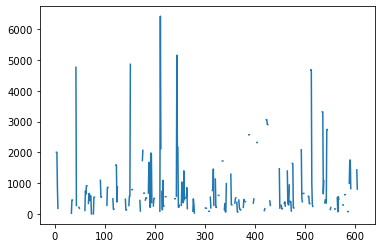

In [18]:
TCGA_pheno['days_to_death.demographic'].plot()

In [22]:
# trying to get HPV status from phenotype data in TCGA
TCGA_pheno['hpv_status_by_ish_testing'].value_counts()

Negative    67
Positive    22
Name: hpv_status_by_ish_testing, dtype: int64

In [23]:
TCGA_pheno['hpv_status_by_p16_testing'].value_counts()

Negative    76
Positive    42
Name: hpv_status_by_p16_testing, dtype: int64

In [31]:
TCGA_pheno['hpv_status']=''

In [39]:
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') | (TCGA_pheno['hpv_status_by_p16_testing']=='Positive'),'hpv_status']='Positive'

In [41]:
TCGA_pheno.loc[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') | (TCGA_pheno['hpv_status_by_p16_testing']=='Negative'),'hpv_status']='Negative'

In [42]:
TCGA_pheno['hpv_status'].value_counts()

            491
Negative     98
Positive     23
Name: hpv_status, dtype: int64

In [36]:
TCGA_pheno[(TCGA_pheno['hpv_status_by_ish_testing']=='Positive') & (TCGA_pheno['hpv_status_by_p16_testing']=='Positive')]

submitter_id.samples additional_pharmaceutical_therapy  \
2       TCGA-BA-A4IH-01A                               NaN   
102     TCGA-BB-A6UM-01A                               NaN   
121     TCGA-BB-7861-01A                               NaN   
126     TCGA-CR-7404-01A                                NO   
166     TCGA-CR-6480-01A                               NaN   
172     TCGA-CN-A6V7-01A                               NaN   
242     TCGA-QK-A6V9-01A                               NaN   
291     TCGA-QK-A6IF-01A                               NaN   
346     TCGA-CR-6481-01A                               NaN   
446     TCGA-CN-A6V6-01A                               NaN   
480     TCGA-TN-A7HL-01A                               NaN   
482     TCGA-BB-7866-01A                               NaN   
511     TCGA-CR-6487-01A                               NaN   
523     TCGA-CN-A499-01A                               NaN   
525     TCGA-CR-5250-01A                               NaN   
539     TCGA-CN-A49C-01A                               NaN   
547     TCGA-CN-A63Y-01A                               NaN   
553     TCGA-TN-A7HI-01A                               NaN   
606     TCGA-CN-A6UY-01A                               NaN   

    additional_radiation_therapy additional_surgery_locoregional_procedure  \
2                            NaN                                       NaN   
102                          NaN                                       NaN   
121                          NaN                                       NaN   
126                           NO                                       YES   
166                          NaN                                       NaN   
172                          NaN                                       NaN   
242                          NaN                                       NaN   
291                          NaN                                       NaN   
346                          NaN                                       NaN   
446                          NaN                                       NaN   
480                          NaN                                       NaN   
482                          NaN                                       NaN   
511                          NaN                                       NaN   
523                          NaN                                       NaN   
525                          NaN                                       NaN   
539                          NaN                                       NaN   
547                          NaN                                       NaN   
553                          NaN                                       NaN   
606                          NaN                                       NaN   

    additional_surgery_metastatic_procedure  \
2                                       NaN   
102                                     NaN   
121                                     NaN   
126                                     NaN   
166                                     NaN   
172                                     NaN   
242                                     NaN   
291                                     NaN   
346                                     NaN   
446                                     NaN   
480                                     NaN   
482                                     NaN   
511                                     NaN   
523                                     NaN   
525                                     NaN   
539                                     NaN   
547                                     NaN   
553                                     NaN   
606                                     NaN   

     age_at_initial_pathologic_diagnosis  \
2                                   57.0   
102                                 52.0   
121                                 56.0   
126                                 53.0   
166                                 53.0 

### correlation test and plot for cell type fractions estimates

In [118]:
MuSiC_celltypefrac = pd.read_csv("/home/cke/MuSic/celltypefrac_MuSiC_Puramfiltered_decor_TCGA_ver2.csv",index_col=0)
BP_celltypefrac = pd.read_csv("/home/cke/BayesPrism/celltypefrac_BP_Puramfiltered_decor_withsub_TCGA_ver2.csv",index_col=0)
BLADE_celltypefrac = pd.read_csv("/home/cke/BLADE/data/filtered_celltypefrac_BLADE_decor_PuramTCGA_ver2.csv",index_col=0)
CIBERSORTx_celltypefrac = pd.read_csv("/home/cke/CIBERSORTx/celltypefrac_CIBERSORTx_Puramfiltered_decor_TCGA_ver2.csv",index_col=0)
NNLS_celltypefrac = pd.read_csv("/home/cke/MuSic/celltypefrac_NNLS_Puramfiltered_decor_TCGA_ver2.csv",index_col=0)

In [121]:
MuSiC_noFS_celltypefrac = pd.read_csv("/home/cke/MuSic/noFS/celltypefrac_MuSiC_Puramfiltered_decor_TCGA_noFS_ver2.csv",index_col=0)
NNLS_noFS_celltypefrac = pd.read_csv("/home/cke/MuSic/noFS/celltypefrac_NNLS_Puramfiltered_decor_TCGA_noFS_ver2.csv",index_col=0)

In [12]:
MuSiC_celltypefrac

B-cell  Dendritic  Endothelial  Fibroblast  Macrophage  \
TCGA-BB-4224-01A  0.000000          0     0.001658    0.010321    0.006710   
TCGA-H7-7774-01A  0.000000          0     0.000000    0.001685    0.032755   
TCGA-CV-6943-01A  0.000000          0     0.000978    0.099486    0.265743   
TCGA-CN-5374-01A  0.000000          0     0.001207    0.013593    0.077938   
TCGA-CQ-6227-01A  0.000000          0     0.000033    0.194762    0.024459   
...                    ...        ...          ...         ...         ...   
TCGA-CV-7235-01A  0.000000          0     0.000000    0.251007    0.084083   
TCGA-CX-7086-01A  0.000000          0     0.000000    0.059620    0.007684   
TCGA-CV-6935-11A  0.000000          0     0.000000    0.116540    0.035827   
TCGA-P3-A6SW-01A  0.014821          0     0.001280    0.054929    0.081294   
TCGA-HD-A6HZ-01A  0.000000          0     0.001929    0.120998    0.079584   

                      Mast   myocyte     other    T-cell     tumor  
TCGA-BB-4224-01A  0.000076  0.000000  0.016900  0.005769  0.958566  
TCGA-H7-7774-01A  0.000000  0.000000  0.002345  0.000000  0.963215  
TCGA-CV-6943-01A  0.000000  0.000000  0.000707  0.000000  0.633087  
TCGA-CN-5374-01A  0.000000  0.042510  0.069713  0.012729  0.782310  
TCGA-CQ-6227-01A  0.003647  0.000000  0.000000  0.002867  0.774231  
...                    ...       ...       ...       ...       ...  
TCGA-CV-7235-01A  0.000000  0.000000  0.000000  0.000000  0.664909  
TCGA-CX-7086-01A  0.000000  0.000000  0.050007  0.000024  0.882665  
TCGA-CV-6935-11A  0.000000  0.039498  0.016760  0.000000  0.791375  
TCGA-P3-A6SW-01A  0.000000  0.000000  0.027011  0.000131  0.820535  
TCGA-HD-A6HZ-01A  0.000000  0.050426  0.000000  0.011353  0.735709  

[546 rows x 10 columns]

In [13]:
NNLS_celltypefrac

B-cell  Dendritic  Endothelial  Fibroblast  Macrophage  \
TCGA-BB-4224-01A       0   0.016658          0.0         0.0    0.000000   
TCGA-H7-7774-01A       0   0.000000          0.0         0.0    0.000000   
TCGA-CV-6943-01A       0   0.000000          0.0         0.0    0.059203   
TCGA-CN-5374-01A       0   0.000000          0.0         0.0    0.235964   
TCGA-CQ-6227-01A       0   0.000000          0.0         0.0    0.000000   
...                  ...        ...          ...         ...         ...   
TCGA-CV-7235-01A       0   0.000000          0.0         0.0    0.021710   
TCGA-CX-7086-01A       0   0.000000          0.0         0.0    0.000000   
TCGA-CV-6935-11A       0   0.000000          0.0         0.0    0.119381   
TCGA-P3-A6SW-01A       0   0.000000          0.0         0.0    0.301300   
TCGA-HD-A6HZ-01A       0   0.000000          0.0         0.0    0.059462   

                      Mast   myocyte     other  T-cell     tumor  
TCGA-BB-4224-01A  0.000000  0.000000  0.000000     0.0  0.983342  
TCGA-H7-7774-01A  0.000000  0.000000  0.000000     0.0  1.000000  
TCGA-CV-6943-01A  0.000000  0.000000  0.000000     0.0  0.940797  
TCGA-CN-5374-01A  0.000000  0.162144  0.000000     0.0  0.601892  
TCGA-CQ-6227-01A  0.000000  0.000000  0.000000     0.0  1.000000  
...                    ...       ...       ...     ...       ...  
TCGA-CV-7235-01A  0.000000  0.000000  0.000000     0.0  0.978290  
TCGA-CX-7086-01A  0.000000  0.000000  0.000000     0.0  1.000000  
TCGA-CV-6935-11A  0.027067  0.054475  0.083295     0.0  0.715781  
TCGA-P3-A6SW-01A  0.000000  0.158908  0.000000     0.0  0.539792  
TCGA-HD-A6HZ-01A  0.000000  0.025304  0.000000     0.0  0.915234  

[546 rows x 10 columns]

In [14]:
BP_celltypefrac

B-cell     Dendritic  Endothelial  Fibroblast  \
TCGA-BB-4224-01A  0.000020  8.486955e-06     0.015331    0.000032   
TCGA-H7-7774-01A  0.000010  5.003444e-06     0.000138    0.000016   
TCGA-CV-6943-01A  0.000001  6.182473e-06     0.067051    0.106869   
TCGA-CN-5374-01A  0.000044  5.062714e-04     0.037394    0.000036   
TCGA-CQ-6227-01A  0.000004  8.416976e-07     0.125277    0.085183   
...                    ...           ...          ...         ...   
TCGA-CV-7235-01A  0.000002  6.036863e-06     0.071579    0.106938   
TCGA-CX-7086-01A  0.000025  1.101295e-06     0.034551    0.000004   
TCGA-CV-6935-11A  0.000003  7.240134e-06     0.038096    0.000006   
TCGA-P3-A6SW-01A  0.001387  2.979891e-05     0.041302    0.010610   
TCGA-HD-A6HZ-01A  0.000008  6.391230e-06     0.085556    0.043347   

                    Macrophage          Mast       myocyte     other  \
TCGA-BB-4224-01A  2.221906e-05  6.537234e-04  1.143791e-05  0.000013   
TCGA-H7-7774-01A  9.325347e-05  4.978334e-05  2.038018e-05  0.000055   
TCGA-CV-6943-01A  7.944620e-02  9.203606e-07  8.060631e-07  0.000002   
TCGA-CN-5374-01A  1.630829e-02  1.196333e-05  6.480449e-06  0.000044   
TCGA-CQ-6227-01A  6.118803e-07  2.582994e-06  2.703500e-06  0.000002   
...                        ...           ...           ...       ...   
TCGA-CV-7235-01A  5.748743e-03  4.035730e-04  1.607822e-06  0.000003   
TCGA-CX-7086-01A  3.255317e-06  3.281600e-03  3.205912e-06  0.000135   
TCGA-CV-6935-11A  2.573157e-03  9.429856e-03  3.876559e-06  0.000013   
TCGA-P3-A6SW-01A  2.137911e-02  1.043904e-05  9.101176e-06  0.000042   
TCGA-HD-A6HZ-01A  8.434097e-03  6.616427e-06  1.094821e-03  0.000020   

                    T-cell     tumor  
TCGA-BB-4224-01A  0.003441  0.980468  
TCGA-H7-7774-01A  0.002443  0.997170  
TCGA-CV-6943-01A  0.010689  0.735934  
TCGA-CN-5374-01A  0.018890  0.926759  
TCGA-CQ-6227-01A  0.000350  0.789178  
...                    ...       ...  
TCGA-CV-7235-01A  0.009197  0.806121  
TCGA-CX-7086-01A  0.002194  0.959802  
TCGA-CV-6935-11A  0.000079  0.949789  
TCGA-P3-A6SW-01A  0.018661  0.906569  
TCGA-HD-A6HZ-01A  0.014220  0.847307  

[546 rows x 10 columns]

In [119]:
BLADE_celltypefrac

B-cell  Dendritic  Endothelial  Fibroblast  Macrophage  \
TCGA-BB-4224-01A  0.018139   0.065608     0.049356    0.070029    0.041256   
TCGA-H7-7774-01A  0.023380   0.120390     0.046967    0.111013    0.053793   
TCGA-CV-6943-01A  0.022642   0.138709     0.055777    0.177338    0.070875   
TCGA-CN-5374-01A  0.022322   0.062831     0.057129    0.088293    0.080139   
TCGA-CQ-6227-01A  0.023878   0.064803     0.079610    0.129542    0.034520   
...                    ...        ...          ...         ...         ...   
TCGA-CV-7235-01A  0.025787   0.020850     0.061532    0.182728    0.089256   
TCGA-CX-7086-01A  0.024788   0.022951     0.075312    0.179230    0.039457   
TCGA-CV-6935-11A  0.026168   0.061130     0.055292    0.114066    0.056995   
TCGA-P3-A6SW-01A  0.032922   0.072881     0.043278    0.096609    0.088173   
TCGA-HD-A6HZ-01A  0.025700   0.106635     0.041615    0.117938    0.070295   

                      Mast   myocyte     other    T-cell     tumor  
TCGA-BB-4224-01A  0.020512  0.026836  0.189497  0.086935  0.431831  
TCGA-H7-7774-01A  0.024669  0.072689  0.034137  0.085852  0.427109  
TCGA-CV-6943-01A  0.028009  0.020534  0.016868  0.064503  0.404745  
TCGA-CN-5374-01A  0.035573  0.070086  0.306856  0.050605  0.226165  
TCGA-CQ-6227-01A  0.023488  0.032722  0.025487  0.046297  0.539654  
...                    ...       ...       ...       ...       ...  
TCGA-CV-7235-01A  0.024744  0.032501  0.065147  0.062900  0.434554  
TCGA-CX-7086-01A  0.025056  0.049564  0.020735  0.084949  0.477958  
TCGA-CV-6935-11A  0.031917  0.067368  0.314194  0.047106  0.225766  
TCGA-P3-A6SW-01A  0.039416  0.078555  0.266147  0.059787  0.222232  
TCGA-HD-A6HZ-01A  0.025214  0.093294  0.054348  0.093921  0.371041  

[546 rows x 10 columns]

In [16]:
CIBERSORTx_celltypefrac

B-cell  Dendritic  Endothelial  Fibroblast  Macrophage  \
TCGA-BB-4224-01A  0.000000   0.010107     0.000000    0.019484    0.008701   
TCGA-H7-7774-01A  0.000000   0.006006     0.000000    0.001509    0.019688   
TCGA-CV-6943-01A  0.000000   0.002610     0.000000    0.077643    0.210831   
TCGA-CN-5374-01A  0.000000   0.006974     0.033256    0.049908    0.142724   
TCGA-CQ-6227-01A  0.000000   0.000000     0.000000    0.187753    0.025071   
...                    ...        ...          ...         ...         ...   
TCGA-CV-7235-01A  0.000000   0.010853     0.000454    0.170936    0.120453   
TCGA-CX-7086-01A  0.000000   0.004934     0.000000    0.005858    0.010719   
TCGA-CV-6935-11A  0.000000   0.000000     0.000000    0.050590    0.048054   
TCGA-P3-A6SW-01A  0.057818   0.000000     0.042750    0.091104    0.226542   
TCGA-HD-A6HZ-01A  0.000000   0.006829     0.000000    0.073776    0.078913   

                      Mast   myocyte     other    T-cell     tumor  
TCGA-BB-4224-01A  0.000000  0.003120  0.000000  0.019222  0.939365  
TCGA-H7-7774-01A  0.000000  0.000000  0.000000  0.000000  0.972797  
TCGA-CV-6943-01A  0.000095  0.000000  0.000000  0.000000  0.708822  
TCGA-CN-5374-01A  0.000000  0.019344  0.179682  0.000000  0.568111  
TCGA-CQ-6227-01A  0.000000  0.040050  0.000000  0.000000  0.747127  
...                    ...       ...       ...       ...       ...  
TCGA-CV-7235-01A  0.000000  0.000000  0.000000  0.000000  0.697304  
TCGA-CX-7086-01A  0.000000  0.000000  0.000000  0.000000  0.978489  
TCGA-CV-6935-11A  0.000420  0.000076  0.293526  0.000000  0.607334  
TCGA-P3-A6SW-01A  0.003072  0.000000  0.046983  0.000000  0.531731  
TCGA-HD-A6HZ-01A  0.000000  0.039342  0.000000  0.000000  0.801141  

[546 rows x 10 columns]

In [120]:
# GETTING CELL TYPE PROPS WITHIN NON-MALIGANANT CELL TYPES
relative_nonmalig_BP = BP_celltypefrac.drop('tumor',axis=1)
relative_nonmalig_MuSiC = MuSiC_celltypefrac.drop('tumor',axis=1)
relative_nonmalig_BLADE = BLADE_celltypefrac.drop('tumor',axis=1)
relative_nonmalig_CIBERSORTx = BLADE_celltypefrac.drop('tumor',axis=1)
relative_nonmalig_NNLS = NNLS_celltypefrac.drop('tumor',axis=1)

relative_nonmalig_BP = relative_nonmalig_BP.div(relative_nonmalig_BP.sum(axis=1),axis=0)
relative_nonmalig_MuSiC = relative_nonmalig_MuSiC.div(relative_nonmalig_MuSiC.sum(axis=1),axis=0)
relative_nonmalig_MuSiC.fillna(0,inplace=True)
relative_nonmalig_BLADE = relative_nonmalig_BLADE.div(relative_nonmalig_BLADE.sum(axis=1),axis=0)
relative_nonmalig_CIBERSORTx = relative_nonmalig_CIBERSORTx.div(relative_nonmalig_CIBERSORTx.sum(axis=1),axis=0)
relative_nonmalig_NNLS =relative_nonmalig_NNLS.div(relative_nonmalig_NNLS.sum(axis=1),axis=0)
relative_nonmalig_NNLS.fillna(0,inplace=True)

In [104]:
relative_nonmalig_noFS_NNLS = NNLS_noFS_celltypefrac.drop('tumor',axis=1)
relative_nonmalig_noFS_MuSiC = MuSiC_noFS_celltypefrac.drop('tumor',axis=1)

relative_nonmalig_noFS_NNLS =relative_nonmalig_noFS_NNLS.div(relative_nonmalig_noFS_NNLS.sum(axis=1),axis=0)
relative_nonmalig_noFS_NNLS.fillna(0,inplace=True)
relative_nonmalig_noFS_MuSiC = relative_nonmalig_noFS_MuSiC.div(relative_nonmalig_noFS_MuSiC.sum(axis=1),axis=0)
relative_nonmalig_noFS_MuSiC.fillna(0,inplace=True)

In [24]:
relative_nonmalig_MuSiC

B-cell  Dendritic  Endothelial  Fibroblast  Macrophage  \
TCGA-BB-4224-01A  0.000000        0.0     0.040014    0.249094    0.161942   
TCGA-H7-7774-01A  0.000000        0.0     0.000000    0.045817    0.890446   
TCGA-CV-6943-01A  0.000000        0.0     0.002666    0.271142    0.724267   
TCGA-CN-5374-01A  0.000000        0.0     0.005545    0.062443    0.358022   
TCGA-CQ-6227-01A  0.000000        0.0     0.000148    0.862660    0.108334   
...                    ...        ...          ...         ...         ...   
TCGA-CV-7235-01A  0.000000        0.0     0.000000    0.749073    0.250927   
TCGA-CX-7086-01A  0.000000        0.0     0.000000    0.508117    0.065486   
TCGA-CV-6935-11A  0.000000        0.0     0.000000    0.558610    0.171729   
TCGA-P3-A6SW-01A  0.082582        0.0     0.007134    0.306069    0.452980   
TCGA-HD-A6HZ-01A  0.000000        0.0     0.007300    0.457822    0.301124   

                      Mast   myocyte     other    T-cell  
TCGA-BB-4224-01A  0.001842  0.000000  0.407885  0.139222  
TCGA-H7-7774-01A  0.000000  0.000000  0.063737  0.000000  
TCGA-CV-6943-01A  0.000000  0.000000  0.001926  0.000000  
TCGA-CN-5374-01A  0.000000  0.195279  0.320238  0.058472  
TCGA-CQ-6227-01A  0.016156  0.000000  0.000000  0.012701  
...                    ...       ...       ...       ...  
TCGA-CV-7235-01A  0.000000  0.000000  0.000000  0.000000  
TCGA-CX-7086-01A  0.000000  0.000000  0.426190  0.000208  
TCGA-CV-6935-11A  0.000000  0.189325  0.080336  0.000000  
TCGA-P3-A6SW-01A  0.000000  0.000000  0.150506  0.000729  
TCGA-HD-A6HZ-01A  0.000000  0.190799  0.000000  0.042955  

[546 rows x 9 columns]

In [25]:
relative_nonmalig_BLADE

B cell  Dendritic  Endothelial  Fibroblast  Macrophage  \
TCGA-BB-4224-01A  0.031925   0.115473     0.086869    0.123253    0.072612   
TCGA-H7-7774-01A  0.040810   0.210145     0.081982    0.193777    0.093898   
TCGA-CV-6943-01A  0.038037   0.233024     0.093703    0.297919    0.119067   
TCGA-CN-5374-01A  0.028845   0.081195     0.073826    0.114098    0.103560   
TCGA-CQ-6227-01A  0.051870   0.140770     0.172935    0.281401    0.074987   
...                    ...        ...          ...         ...         ...   
TCGA-CV-7235-01A  0.045605   0.036874     0.108820    0.323157    0.157851   
TCGA-CX-7086-01A  0.047483   0.043964     0.144265    0.343324    0.075581   
TCGA-CV-6935-11A  0.033798   0.078956     0.071415    0.147327    0.073614   
TCGA-P3-A6SW-01A  0.042329   0.093705     0.055644    0.124213    0.113367   
TCGA-HD-A6HZ-01A  0.040861   0.169542     0.066165    0.187513    0.111765   

                      Mast    T cell   myocyte     other  
TCGA-BB-4224-01A  0.036103  0.153010  0.047233  0.333522  
TCGA-H7-7774-01A  0.043060  0.149858  0.126882  0.059588  
TCGA-CV-6943-01A  0.047054  0.108363  0.034496  0.028337  
TCGA-CN-5374-01A  0.045970  0.065395  0.090570  0.396540  
TCGA-CQ-6227-01A  0.051022  0.100569  0.071081  0.055364  
...                    ...       ...       ...       ...  
TCGA-CV-7235-01A  0.043760  0.111240  0.057479  0.115214  
TCGA-CX-7086-01A  0.047996  0.162724  0.094943  0.039719  
TCGA-CV-6935-11A  0.041224  0.060842  0.087012  0.405813  
TCGA-P3-A6SW-01A  0.050679  0.076870  0.101000  0.342194  
TCGA-HD-A6HZ-01A  0.040088  0.149327  0.148330  0.086410  

[546 rows x 9 columns]

In [26]:
relative_nonmalig_BP

B-cell  Dendritic  Endothelial  Fibroblast  Macrophage  \
TCGA-BB-4224-01A  0.001013   0.000435     0.784924    0.001648    0.001138   
TCGA-H7-7774-01A  0.003640   0.001768     0.048712    0.005503    0.032955   
TCGA-CV-6943-01A  0.000004   0.000023     0.253916    0.404707    0.300857   
TCGA-CN-5374-01A  0.000601   0.006912     0.510554    0.000496    0.222666   
TCGA-CQ-6227-01A  0.000018   0.000004     0.594230    0.404053    0.000003   
...                    ...        ...          ...         ...         ...   
TCGA-CV-7235-01A  0.000008   0.000031     0.369195    0.551573    0.029651   
TCGA-CX-7086-01A  0.000632   0.000027     0.859507    0.000095    0.000081   
TCGA-CV-6935-11A  0.000065   0.000144     0.758720    0.000115    0.051247   
TCGA-P3-A6SW-01A  0.014841   0.000319     0.442057    0.113561    0.228823   
TCGA-HD-A6HZ-01A  0.000055   0.000042     0.560314    0.283881    0.055236   

                      Mast   myocyte     other    T-cell  
TCGA-BB-4224-01A  0.033469  0.000586  0.000643  0.176145  
TCGA-H7-7774-01A  0.017593  0.007202  0.019362  0.863264  
TCGA-CV-6943-01A  0.000003  0.000003  0.000008  0.040477  
TCGA-CN-5374-01A  0.000163  0.000088  0.000598  0.257920  
TCGA-CQ-6227-01A  0.000012  0.000013  0.000008  0.001659  
...                    ...       ...       ...       ...  
TCGA-CV-7235-01A  0.002082  0.000008  0.000014  0.047437  
TCGA-CX-7086-01A  0.081636  0.000080  0.003354  0.054588  
TCGA-CV-6935-11A  0.187804  0.000077  0.000259  0.001569  
TCGA-P3-A6SW-01A  0.000112  0.000097  0.000455  0.199735  
TCGA-HD-A6HZ-01A  0.000043  0.007170  0.000128  0.093130  

[546 rows x 9 columns]

In [27]:
relative_nonmalig_CIBERSORTx

B cell  Dendritic  Endothelial  Fibroblast  Macrophage  \
TCGA-BB-4224-01A  0.031925   0.115473     0.086869    0.123253    0.072612   
TCGA-H7-7774-01A  0.040810   0.210145     0.081982    0.193777    0.093898   
TCGA-CV-6943-01A  0.038037   0.233024     0.093703    0.297919    0.119067   
TCGA-CN-5374-01A  0.028845   0.081195     0.073826    0.114098    0.103560   
TCGA-CQ-6227-01A  0.051870   0.140770     0.172935    0.281401    0.074987   
...                    ...        ...          ...         ...         ...   
TCGA-CV-7235-01A  0.045605   0.036874     0.108820    0.323157    0.157851   
TCGA-CX-7086-01A  0.047483   0.043964     0.144265    0.343324    0.075581   
TCGA-CV-6935-11A  0.033798   0.078956     0.071415    0.147327    0.073614   
TCGA-P3-A6SW-01A  0.042329   0.093705     0.055644    0.124213    0.113367   
TCGA-HD-A6HZ-01A  0.040861   0.169542     0.066165    0.187513    0.111765   

                      Mast    T cell   myocyte     other  
TCGA-BB-4224-01A  0.036103  0.153010  0.047233  0.333522  
TCGA-H7-7774-01A  0.043060  0.149858  0.126882  0.059588  
TCGA-CV-6943-01A  0.047054  0.108363  0.034496  0.028337  
TCGA-CN-5374-01A  0.045970  0.065395  0.090570  0.396540  
TCGA-CQ-6227-01A  0.051022  0.100569  0.071081  0.055364  
...                    ...       ...       ...       ...  
TCGA-CV-7235-01A  0.043760  0.111240  0.057479  0.115214  
TCGA-CX-7086-01A  0.047996  0.162724  0.094943  0.039719  
TCGA-CV-6935-11A  0.041224  0.060842  0.087012  0.405813  
TCGA-P3-A6SW-01A  0.050679  0.076870  0.101000  0.342194  
TCGA-HD-A6HZ-01A  0.040088  0.149327  0.148330  0.086410  

[546 rows x 9 columns]

In [33]:
# check for nan and inf values
np.isnan(relative_nonmalig_NNLS).any()

B-cell         False
Dendritic      False
Endothelial    False
Fibroblast     False
Macrophage     False
Mast           False
myocyte        False
other          False
T-cell         False
dtype: bool

In [31]:
np.isinf(relative_nonmalig_NNLS).any()

B-cell         False
Dendritic      False
Endothelial    False
Fibroblast     False
Macrophage     False
Mast           False
myocyte        False
other          False
T-cell         False
dtype: bool

### tumor cell tpye prop correlation scatter plot with gaussian estimated density
### MuSiC vs BayesPrism

In [14]:
"""
Function to generate scatterplot with gaussian density estimates showing correlations of 
cell type proportion estimation between mehtods within (non-)maliganant cell type.
args: celltypeprop1,celltypeprop2 are dataframe sample x celltype
lab1,lab2 are string with corresponding method name
customizable args: path for figure to be saved and dpi setting.
"""
def plot_corr_density(celltypeprop1,celltypeprop2,lab1,lab2,celltype=['tumor','non-maliganant'],*args):
    if celltype == 'tumor':
        x = celltypeprop1.loc[:,'tumor']
        y = celltypeprop2.loc[:,'tumor']
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        x,y,z = x[idx],y[idx],z[idx]
        fig,ax = plt.subplots()
        plt.title("Tumor cell proportion estimates correllation between "+lab1+' vs '+lab2)
        plt.scatter(x,y,c=z,cmap='Spectral')
        ax.set_xlabel(lab1)
        ax.set_ylabel(lab2)
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.colorbar()
        if args:
            if len(args)== 2:
                print('export fig to', args[0], 'with dpi ', args[1])
                plt.savefig(fname=args[0],dpi=args[1])
            else:
                print('export fig to', args[0])
                plt.savefig(fname=args[0])
        plt.show()
    elif celltype == 'non-maliganant':
        fig = plt.figure(figsize=(20,16))
        fig.suptitle(" ".join(["Non-maliganant cell type fraction correlation", lab1, "vs", lab2]),size=20)
        l=0.92
        b=0.12
        w=0.015
        h=1-2*b
        rect = [l,b,w,h]
        cbar_ax = fig.add_axes(rect)
        plt.subplots_adjust(top=0.92)
        for i in range(0,9):
            ax1 = fig.add_subplot(3,3,i+1,xlim=[0,1],ylim=[0,1])
            x = celltypeprop1.iloc[:,i]
            y = celltypeprop2.iloc[:,i]
            ax1.set_xlabel(lab1)
            ax1.set_ylabel(lab2)
            xy = np.vstack([x,y])
            z = gaussian_kde(xy)(xy)
            idx = z.argsort()
            x,y,z = x[idx],y[idx],z[idx]
            im = ax1.scatter(x,y,c=z,cmap='Spectral')
            ax1.set_title(celltypeprop1.columns.tolist()[i]) #two df should have cols in same order so we take only first as ref
        fig.colorbar(im,cax=cbar_ax)
        if args:
            if len(args)== 2:
                print('export fig to', args[0], 'with dpi ', args[1])
                plt.savefig(fname=args[0],dpi=args[1])
            else:
                print('export fig to', args[0])
                plt.savefig(fname=args[0])
        plt.show()
    

export fig to /home/cke/CelltypeProp_corr/Tumor_MuSiC_BP_decor.jpg with dpi  200


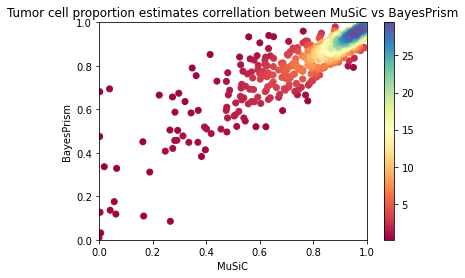

In [24]:
plot_corr_density(MuSiC_celltypefrac,BP_celltypefrac,'MuSiC','BayesPrism','tumor','/home/cke/CelltypeProp_corr/Tumor_MuSiC_BP_decor.jpg',200)

export fig to /home/cke/CelltypeProp_corr/Tumor_MuSiC_BLADE_decor.jpg with dpi  200


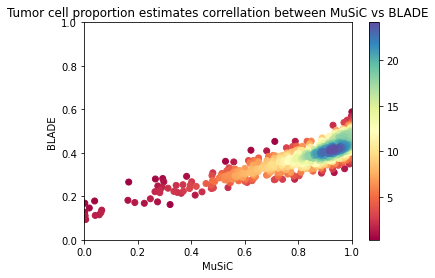

In [23]:
plot_corr_density(MuSiC_celltypefrac,BLADE_celltypefrac,'MuSiC','BLADE','tumor','/home/cke/CelltypeProp_corr/Tumor_MuSiC_BLADE_decor.jpg',200)

export fig to /home/cke/CelltypeProp_corr/Tumor_BP_BLADE_decor.jpg with dpi  200


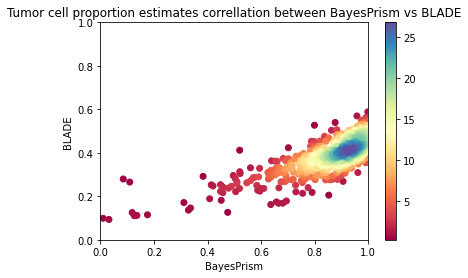

In [22]:
plot_corr_density(BP_celltypefrac,BLADE_celltypefrac,'BayesPrism','BLADE','tumor','/home/cke/CelltypeProp_corr/Tumor_BP_BLADE_decor.jpg',200)

### Non-maliganant cell tpye prop correlation scatter plot with gaussian estimated density
### MuSiC vs BayesPrism

export fig to /home/cke/CelltypeProp_corr/nonmalig_MuSiC_BP_decor.jpg with dpi  200


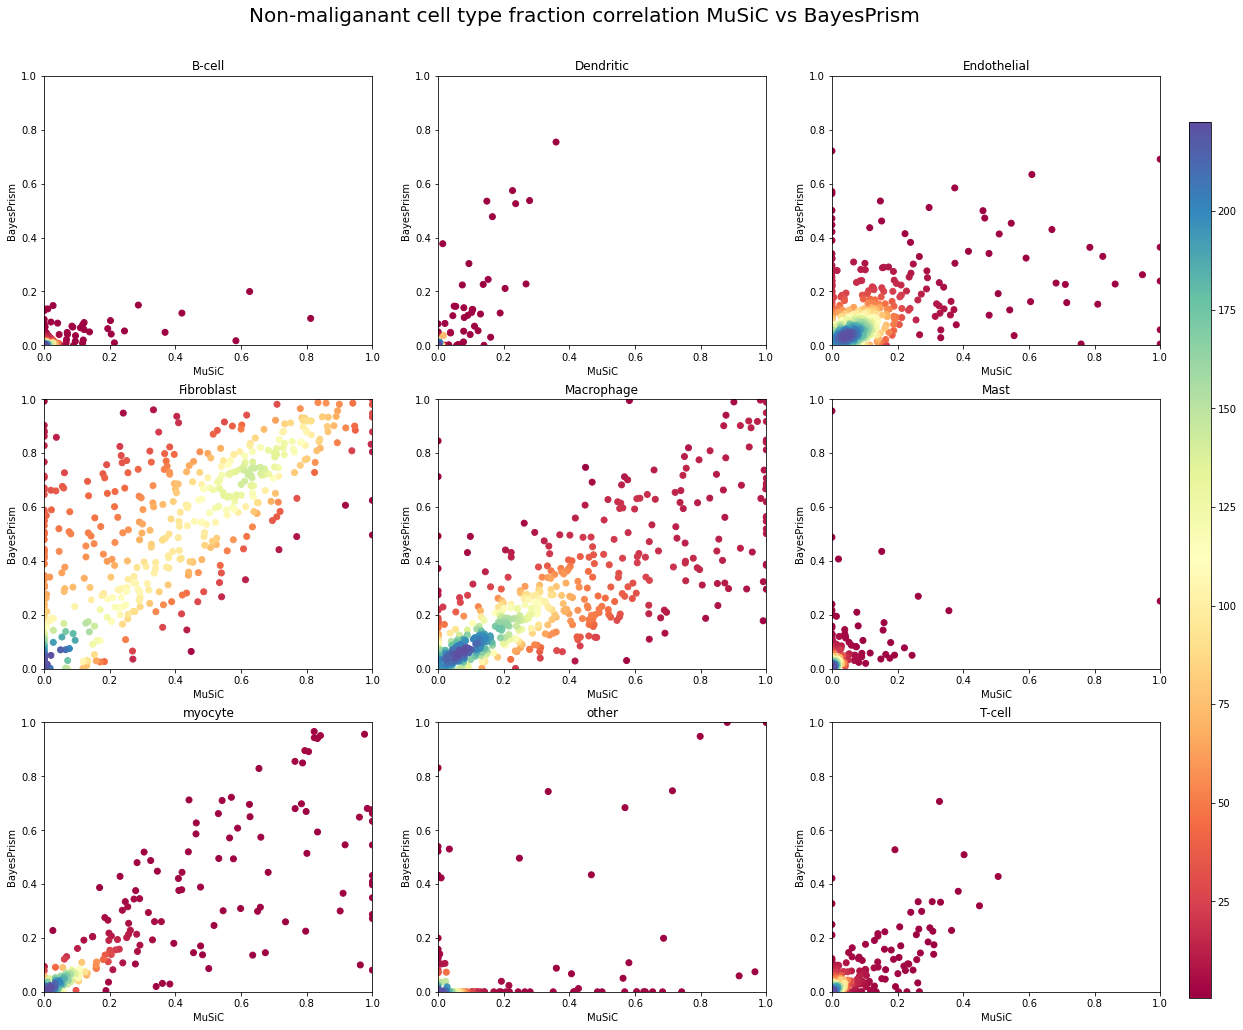

In [25]:
plot_corr_density(relative_nonmalig_MuSiC,relative_nonmalig_BP,'MuSiC','BayesPrism','non-maliganant','/home/cke/CelltypeProp_corr/nonmalig_MuSiC_BP_decor.jpg',200)

export fig to /home/cke/CelltypeProp_corr/nonmalig_MuSiC_BLADE_decor.jpg with dpi  200


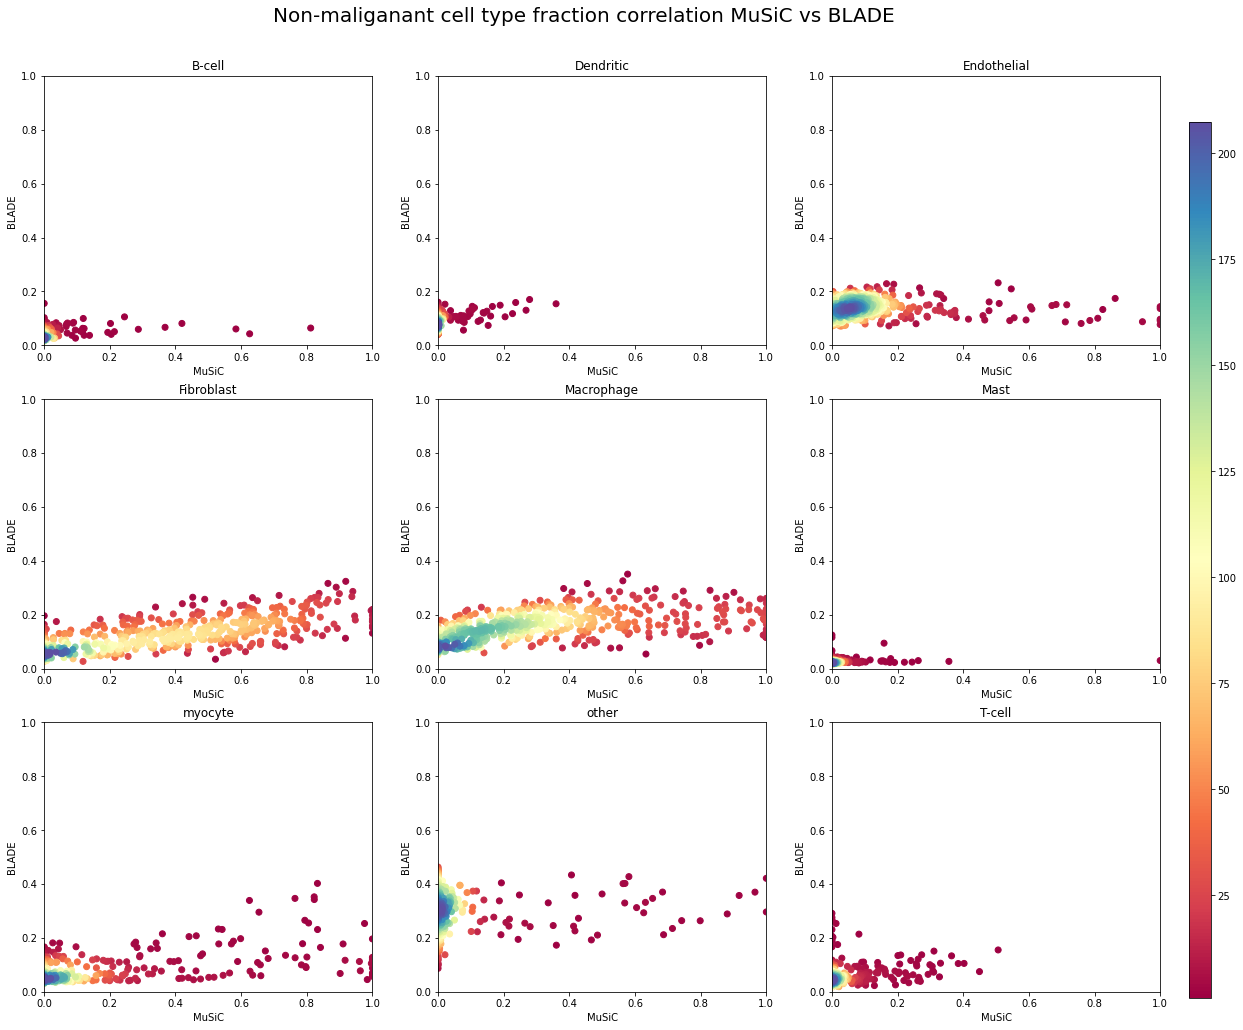

In [26]:
plot_corr_density(relative_nonmalig_MuSiC,relative_nonmalig_BLADE,'MuSiC','BLADE','non-maliganant','/home/cke/CelltypeProp_corr/nonmalig_MuSiC_BLADE_decor.jpg',200)

export fig to /home/cke/CelltypeProp_corr/nonmalig_BP_BLADE_decor.jpg with dpi  200


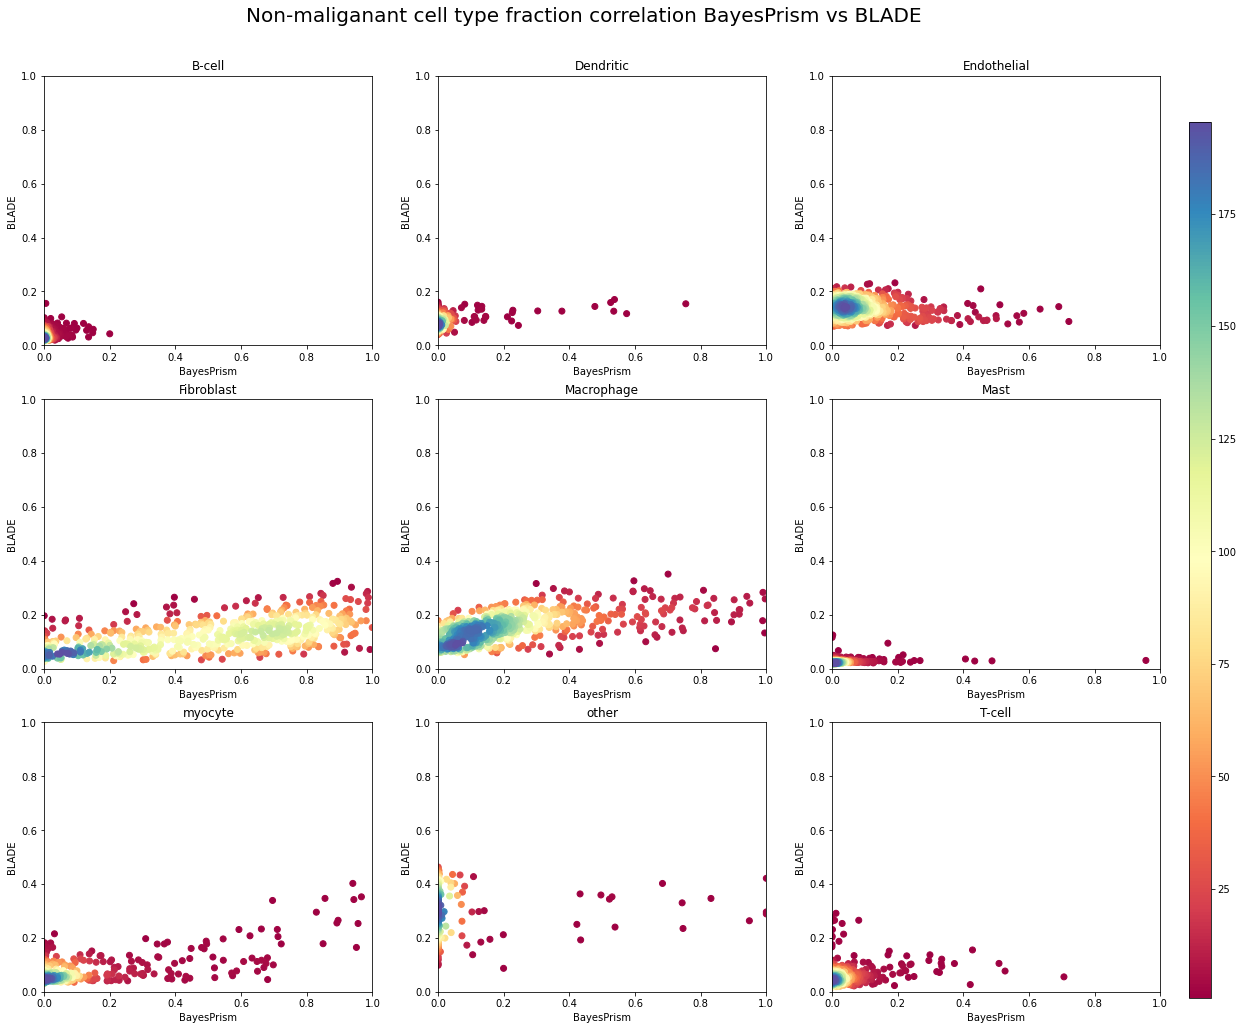

In [27]:
plot_corr_density(relative_nonmalig_BP,relative_nonmalig_BLADE,'BayesPrism','BLADE','non-maliganant','/home/cke/CelltypeProp_corr/nonmalig_BP_BLADE_decor.jpg',200)

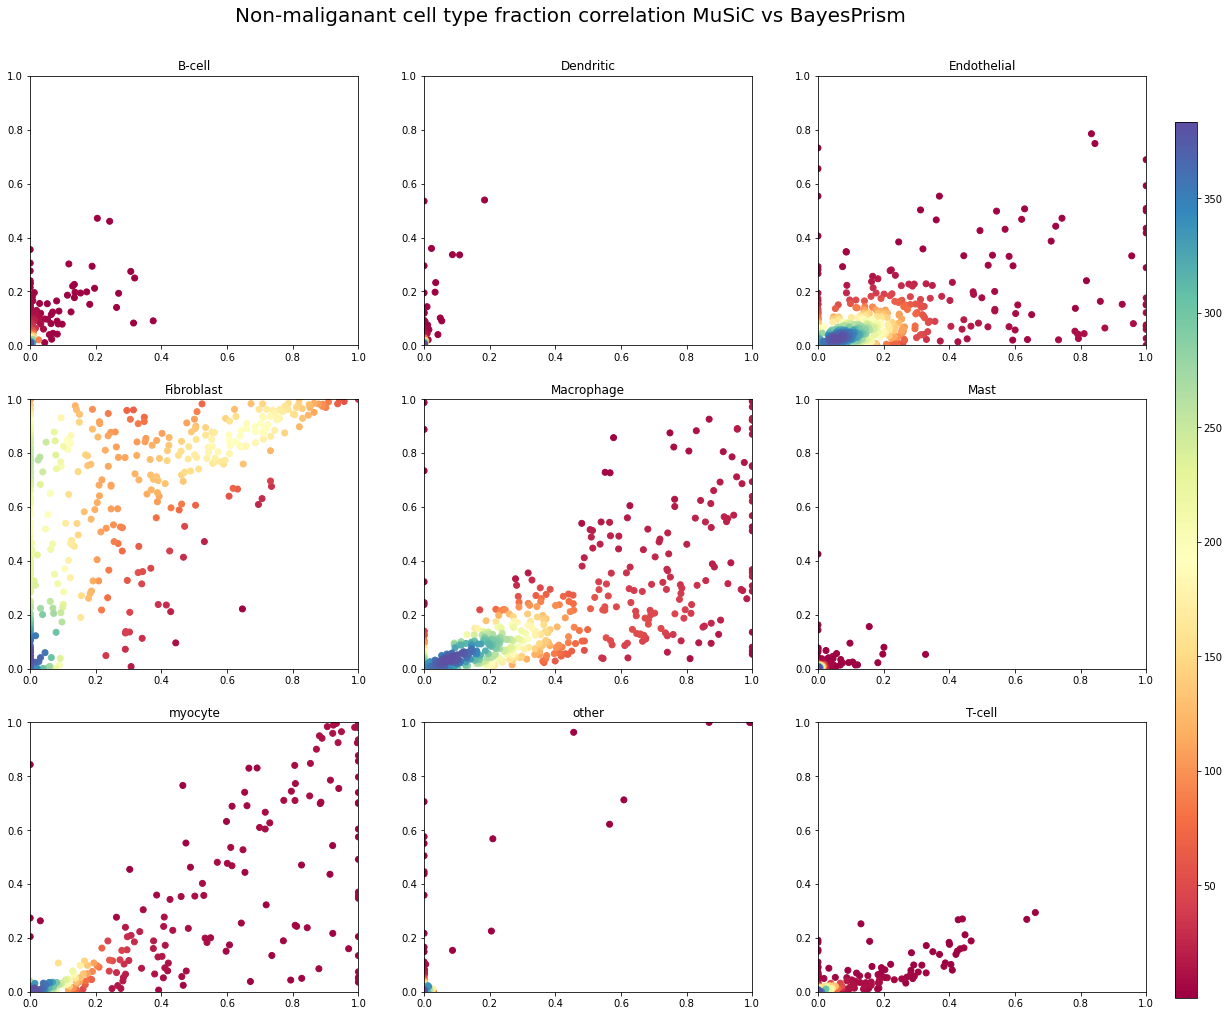

In [141]:
# test code, deprecated.
fig = plt.figure(figsize=(20,16))
fig.suptitle("Non-maliganant cell type fraction correlation MuSiC vs BayesPrism",size=20)
l=0.92
b=0.12
w=0.015
h=1-2*b
rect = [l,b,w,h]
cbar_ax = fig.add_axes(rect)
plt.subplots_adjust(top=0.92)
for i in range(0,9):
    ax1 = fig.add_subplot(3,3,i+1,xlim=[0,1],ylim=[0,1])
    x = relative_nonmalig_MuSiC.iloc[:,i]
    y = relative_nonmalig_BP.iloc[:,i]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x,y,z = x[idx],y[idx],z[idx]
    im = ax1.scatter(x,y,c=z,cmap='Spectral')
    ax1.set_title(MuSiC_celltypefrac.columns.tolist()[i])
fig.colorbar(im,cax=cbar_ax)
plt.show()

### TCGA clinical data

In [28]:
TCGA_clinical = pd.read_csv("/home/cke/TCGA_HNSCC_clinical_data.tsv",sep='\t')

In [38]:
# read in ABSOLUTE purity/ploidy file from pancanatlas website
pancanatlas_purity = pd.read_csv("/home/cke/TCGA_mastercalls.abs_tables_JSedit.fixed.txt",sep='\t')

In [150]:
pancanatlas_purity.dropna(inplace=True)
pancanatlas_purity

array                        sample call status  purity  \
0     TCGA-OR-A5J1-01  TCGA-OR-A5J1-01A-11D-A29H-01      called    0.90   
1     TCGA-OR-A5J2-01  TCGA-OR-A5J2-01A-11D-A29H-01      called    0.89   
2     TCGA-OR-A5J3-01  TCGA-OR-A5J3-01A-11D-A29H-01      called    0.93   
3     TCGA-OR-A5J4-01  TCGA-OR-A5J4-01A-11D-A29H-01      called    0.87   
4     TCGA-OR-A5J5-01  TCGA-OR-A5J5-01A-11D-A29H-01      called    0.93   
...               ...                           ...         ...     ...   
9842  TCGA-YZ-A980-01  TCGA-YZ-A980-01A-11D-A39V-01      called    0.46   
9843  TCGA-YZ-A982-01  TCGA-YZ-A982-01A-11D-A39V-01      called    0.97   
9844  TCGA-YZ-A983-01  TCGA-YZ-A983-01A-11D-A39V-01      called    0.94   
9845  TCGA-YZ-A984-01  TCGA-YZ-A984-01A-11D-A39V-01      called    0.93   
9846  TCGA-YZ-A985-01  TCGA-YZ-A985-01A-11D-A39V-01      called    0.99   

      ploidy  Genome doublings  Coverage for 80% power  Cancer DNA fraction  \
0       2.00               0.0                     9.0                 0.90   
1       1.30               0.0                     6.0                 0.84   
2       1.27               0.0                     5.0                 0.89   
3       2.60               1.0                    12.0                 0.89   
4       2.79               1.0                    12.0                 0.95   
...      ...               ...                     ...                  ...   
9842    1.95               0.0                    18.0                 0.46   
9843    3.23               1.0                    13.0                 0.98   
9844    2.02               0.0                     8.0                 0.94   
9845    3.32               1.0                    14.0                 0.96   
9846    1.93               0.0                     8.0                 0.99   

      Subclonal genome fraction solution  
0                          0.02      new  
1                          0.16      new  
2                          0.11      new  
3                          0.08      new  
4                          0.15      new  
...                         ...      ...  
9842                       0.00      new  
9843                       0.08      new  
9844                       0.00      new  
9845                       0.00      new  
9846                       0.00      new  

[9847 rows x 10 columns]

In [34]:
clindat_primary = TCGA_clinical[TCGA_clinical['Sample Type']=='Primary']
clindat_primary

Study ID    Patient ID        Sample ID  Diagnosis Age  \
0    hnsc_tcga  TCGA-4P-AA8J  TCGA-4P-AA8J-01           66.0   
1    hnsc_tcga  TCGA-BA-4074  TCGA-BA-4074-01           69.0   
2    hnsc_tcga  TCGA-BA-4075  TCGA-BA-4075-01           49.0   
3    hnsc_tcga  TCGA-BA-4076  TCGA-BA-4076-01           39.0   
4    hnsc_tcga  TCGA-BA-4077  TCGA-BA-4077-01           45.0   
..         ...           ...              ...            ...   
525  hnsc_tcga  TCGA-UF-A7JT  TCGA-UF-A7JT-01           72.0   
526  hnsc_tcga  TCGA-UF-A7JV  TCGA-UF-A7JV-01           62.0   
527  hnsc_tcga  TCGA-UP-A6WW  TCGA-UP-A6WW-01           58.0   
528  hnsc_tcga  TCGA-WA-A7GZ  TCGA-WA-A7GZ-01           58.0   
529  hnsc_tcga  TCGA-WA-A7H4  TCGA-WA-A7H4-01           69.0   

    American Joint Committee on Cancer Metastasis Stage Code  \
0                                                   MX         
1                                                   M0         
2                                                   M0         
3                                                  NaN         
4                                                   M0         
..                                                 ...         
525                                                 M0         
526                                                 M0         
527                                                NaN         
528                                                NaN         
529                                                NaN         

    Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code  \
0                                                  N2c                          
1                                                  N2c                          
2                                                   N0                          
3                                                   NX                          
4                                                   N0                          
..                                                 ...                          
525                                                 N0                          
526                                                N2b                          
527                                                NaN                          
528                                                 N0                          
529                                                 N0                          

    Neoplasm Disease Stage American Joint Committee on Cancer Code  \
0                                            Stage IVA               
1                                            Stage IVA               
2                                            Stage III               
3                                                  NaN               
4                                            Stage IVA               
..                                                 ...               
525                                          Stage IVA               
526                                          Stage IVA               
527                                                NaN               
528                                                NaN               
529                                           Stage II               

    American Joint Committee on Cancer Publication Version Type  \
0                                                  7th            
1                                                  6th            
2                                                  6th            
3                                                  6th            
4                                                  6th            
..                                                 ...            
525                                                6th            
526                                                7th            
527                                                

### Get negative correlation coef for markers

In [27]:
def plot_cor_purity_exp(mat,gene,idx_purity,celltype):
    fig = plt.figure()
    x = mat.loc[:,idx_purity]
    y = mat.loc[:,'exp']
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x,y,z = x[idx],y[idx],z[idx]
    plt.scatter(x,y,c=z,cmap='Spectral')
    plt.title(celltype+": "+gene)
    plt.colorbar()
    fig.savefig("/home/cke/KariPDF/cellularity_bulkexp/"+celltype+"_"+gene+'.png')
    plt.show()

In [19]:
cellularity_Kari = pd.read_csv("/home/cke/KariPDF/cellularity_table.csv",header=None)
cellularity_Kari.columns = ['sample','cellularity']
cellularity_Kari

sample  cellularity
0    TCGA-CR-7391-01         0.05
1    TCGA-CN-6995-01         0.34
2    TCGA-CQ-A4C6-01         0.26
3    TCGA-CV-A6K0-01         0.10
4    TCGA-CR-6471-01         0.46
..               ...          ...
519  TCGA-CN-4725-01         0.52
520  TCGA-CV-7440-01         0.40
521  TCGA-CN-4726-01         0.40
522  TCGA-CN-A6V6-01         0.54
523  TCGA-CR-6467-01         0.56

[524 rows x 2 columns]

In [21]:
# get transposed TCGA counts
df_TCGA_t = df_TCGA_symbol.T
df_TCGA_t.columns = df_TCGA_t.loc['Gene_symbol',:]
df_TCGA_t.drop('Gene_symbol',axis=0,inplace=True)
df_TCGA_t['sample'] = df_TCGA_t.index.str.rstrip('A').tolist()

In [22]:
df_TCGA_t

Gene_symbol        TSPAN6 TNMD    DPM1   SCYL3 C1orf112     FGR      CFH  \
TCGA-BB-4224-01A   2237.0  2.0  1606.0  1063.0   1208.0   256.0    177.0   
TCGA-H7-7774-01A   2740.0  0.0  1691.0   803.0    317.0   330.0   5472.0   
TCGA-CV-6943-01A   2686.0  0.0  1649.0   917.0    402.0  1535.0  15358.0   
TCGA-CN-5374-01A   2086.0  1.0  2333.0  1288.0   1105.0   639.0   5565.0   
TCGA-CQ-6227-01A  10167.0  9.0  3021.0   537.0    459.0   362.0   6963.0   
...                   ...  ...     ...     ...      ...     ...      ...   
TCGA-CV-7235-01A    492.0  0.0   976.0   376.0    363.0   488.0   5178.0   
TCGA-CX-7086-01A   2741.0  0.0  1952.0  1003.0   1103.0   214.0   1809.0   
TCGA-CV-6935-11A   8492.0  3.0  1578.0   818.0    281.0   419.0   7368.0   
TCGA-P3-A6SW-01A    770.0  1.0  1569.0   620.0    591.0   462.0   2082.0   
TCGA-HD-A6HZ-01A    923.0  0.0  1183.0   607.0    344.0   925.0   2482.0   

Gene_symbol        FUCA2     GCLC    NFYA  ... LINC01394 LINC00602 MIR1291  \
TCGA-BB-4224-01A  2371.0   2741.0  2515.0  ...       7.0       0.0     2.0   
TCGA-H7-7774-01A  2316.0   8370.0   816.0  ...       1.0       0.0     0.0   
TCGA-CV-6943-01A  3490.0   4671.0  2080.0  ...       4.0       0.0     2.0   
TCGA-CN-5374-01A  2065.0   2902.0  1777.0  ...       0.0       1.0     0.0   
TCGA-CQ-6227-01A  4883.0   3140.0  2448.0  ...       3.0       0.0     0.0   
...                  ...      ...     ...  ...       ...       ...     ...   
TCGA-CV-7235-01A  2138.0  20007.0  4131.0  ...       2.0       2.0     1.0   
TCGA-CX-7086-01A  2639.0  13623.0  2530.0  ...       2.0       0.0     1.0   
TCGA-CV-6935-11A  1355.0   2276.0  1583.0  ...       1.0       0.0     1.0   
TCGA-P3-A6SW-01A  1603.0  31675.0  1473.0  ...       0.0       2.0     1.0   
TCGA-HD-A6HZ-01A  1769.0   3949.0   899.0  ...       1.0       0.0     0.0   

Gene_symbol      LINC00891 PAUPAR GIMAP1-GIMAP5 LINC02246 HERC2P7 LINC01144  \
TCGA-BB-4224-01A       0.0    6.0           0.0      16.0     0.0     144.0   
TCGA-H7-7774-01A       2.0    0.0           0.0       6.0     0.0      23.0   
TCGA-CV-6943-01A       4.0    1.0           0.0      38.0     0.0      18.0   
TCGA-CN-5374-01A       3.0    0.0           0.0       4.0     0.0      31.0   
TCGA-CQ-6227-01A       2.0    0.0           0.0      15.0     0.0      24.0   
...                    ...    ...           ...       ...     ...       ...   
TCGA-CV-7235-01A       0.0    0.0           0.0       8.0     0.0      60.0   
TCGA-CX-7086-01A       0.0    1.0           0.0      11.0     0.0      77.0   
TCGA-CV-6935-11A       0.0    0.0           0.0      12.0     0.0      19.0   
TCGA-P3-A6SW-01A       1.0    0.0           0.0       0.0     1.0      22.0   
TCGA-HD-A6HZ-01A       1.0    0.0           0.0      11.0     1.0      40.0   

Gene_symbol                sample  
TCGA-BB-4224-01A  TCGA-BB-4224-01  
TCGA-H7-7774-01A  TCGA-H7-7774-01  
TCGA-CV-6943-01A  TCGA-CV-6943-01  
TCGA-CN-5374-01A  TCGA-CN-5374-01  
TCGA-CQ-6227-01A  TCGA-CQ-6227-01  
...                           ...  
TCGA-CV-7235-01A  TCGA-CV-7235-01  
TCGA-CX-7086-01A  TCGA-CX-7086-01  
TCGA-CV-6935-11A  TCGA-CV-6935-11  
TCGA-P3-A6SW-01A  TCGA-P3-A6SW-01  
TCGA-HD-A6HZ-01A  TCGA-HD-A6HZ-01  

[546 rows x 38930 columns]

In [23]:
marker_genes_table = pd.read_csv("/home/cke/Puram/top100DEGs_pseudobulk.csv",index_col=0)
marker_genes_table

B cell_names Dendritic_names Endothelial_names Fibroblast_names  \
0          SSR4           LAMP3            PECAM1         SERPING1   
1          MZB1           BIRC3             S1PR1            CALD1   
2         DERL3            CCR7             GNG11              VIM   
3        FKBP11            LY75               ENG             EBF1   
4        SEC11C          RASSF4             HYAL2              C1R   
..          ...             ...               ...              ...   
95        CPEB4          GLIPR2             LIMS2         MTRNR2L8   
96    LINC00152        HLA-DPA1          HLA-DRB1            PLAC9   
97      EIF2AK3           AKAP2            ENTPD1            MAP1B   
98      TXNDC11          DPYSL2             PREX2            MYADM   
99     C10orf54            NRP2            PDLIM1             IER2   

   Macrophage_names Mast_names T cell_names myocyte_names other_names  \
0           HLA-DRA       CPA3        PTPRC           NEB        PIGR   
1          HLA-DQB1      TPSB2       TMSB4X         ACTC1         LYZ   
2              CD74      TPSD1          B2M           DES      ATP1B1   
3          HLA-DRB1     TPSAB1         SRGN          FLNC        SDC4   
4          HLA-DPA1      MS4A2      ARHGDIB       PDE4DIP        CTTN   
..              ...        ...          ...           ...         ...   
95            PEA15    ADCYAP1        L1TD1         FXYD1      ZNF626   
96            CIITA      SDCBP        AKAP5         TBX15        ERN2   
97            EVI2B      AKAP2         CA5B         PGAM2        NWD1   
98             CST3      CDK15         CD53          MLIP      FGD5P1   
99          ALOX5AP      P2RX1          SLA        RASSF4       ACSL6   

   tumor_names  
0         KRT5  
1        KRT17  
2         PERP  
3        GSTP1  
4          DSP  
..         ...  
95      MRPL14  
96     SLCO1A2  
97     HTATIP2  
98       SNRPE  
99        SQLE  

[100 rows x 10 columns]

In [24]:
marker_genes = {}
celltype_idx = 0
for i in marker_genes_table:
    marker_genes[marker_genes_table.columns[celltype_idx]] = marker_genes_table[i]
    celltype_idx += 1

In [25]:
marker_genes

{'B cell_names': 0          SSR4
 1          MZB1
 2         DERL3
 3        FKBP11
 4        SEC11C
         ...    
 95        CPEB4
 96    LINC00152
 97      EIF2AK3
 98      TXNDC11
 99     C10orf54
 Name: B cell_names, Length: 100, dtype: object,
 'Dendritic_names': 0        LAMP3
 1        BIRC3
 2         CCR7
 3         LY75
 4       RASSF4
         ...   
 95      GLIPR2
 96    HLA-DPA1
 97       AKAP2
 98      DPYSL2
 99        NRP2
 Name: Dendritic_names, Length: 100, dtype: object,
 'Endothelial_names': 0       PECAM1
 1        S1PR1
 2        GNG11
 3          ENG
 4        HYAL2
         ...   
 95       LIMS2
 96    HLA-DRB1
 97      ENTPD1
 98       PREX2
 99      PDLIM1
 Name: Endothelial_names, Length: 100, dtype: object,
 'Fibroblast_names': 0     SERPING1
 1        CALD1
 2          VIM
 3         EBF1
 4          C1R
         ...   
 95    MTRNR2L8
 96       PLAC9
 97       MAP1B
 98       MYADM
 99        IER2
 Name: Fibroblast_names, Length: 100, dtype: object,
 

B cell_names


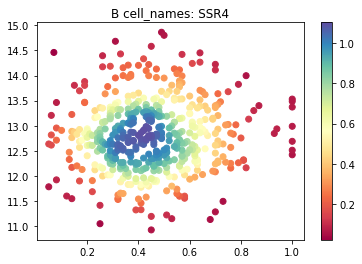

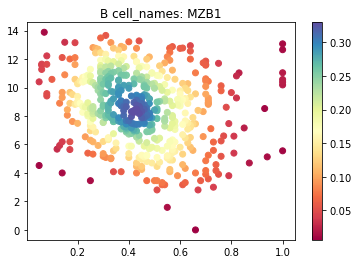

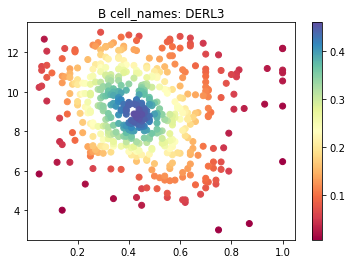

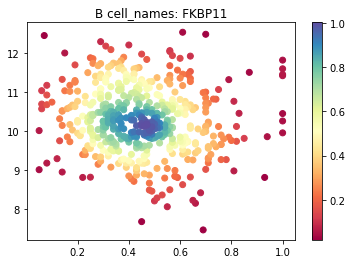

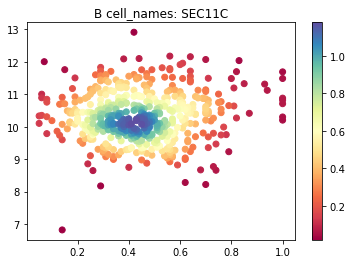

Dendritic_names


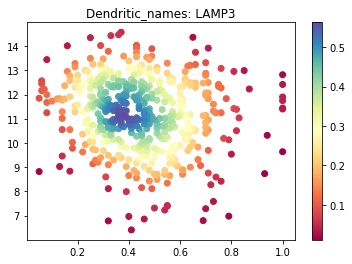

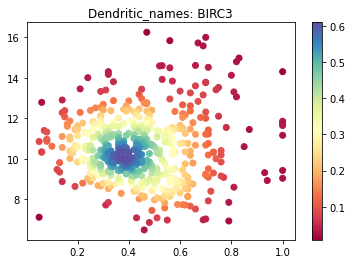

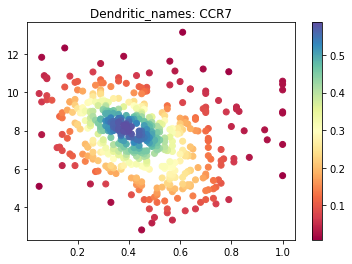

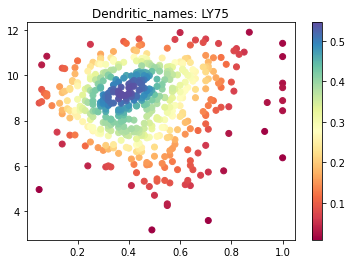

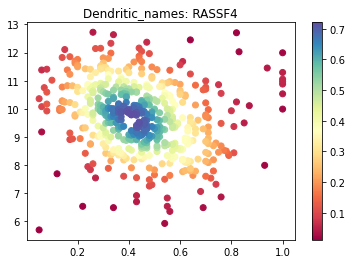

Endothelial_names


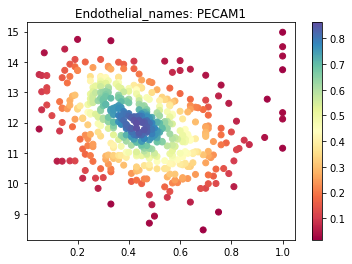

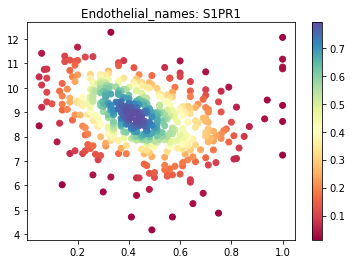

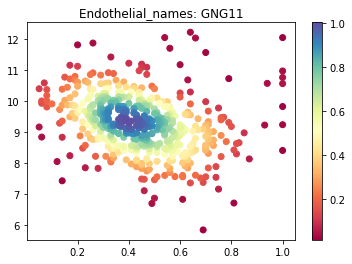

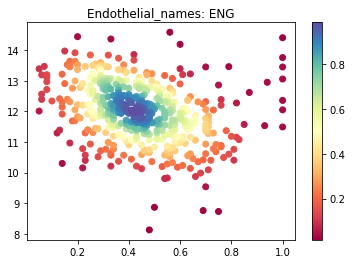

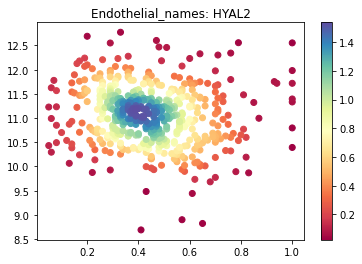

Fibroblast_names


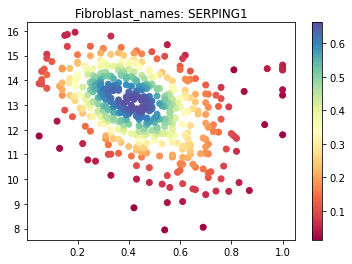

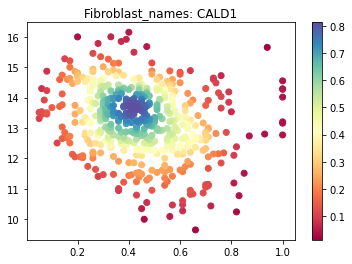

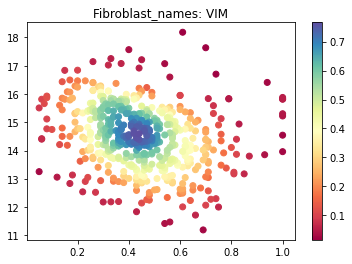

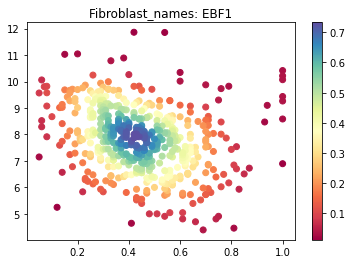

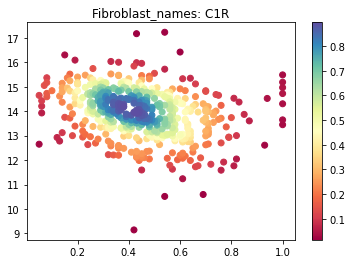

Macrophage_names


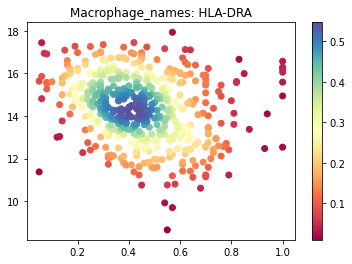

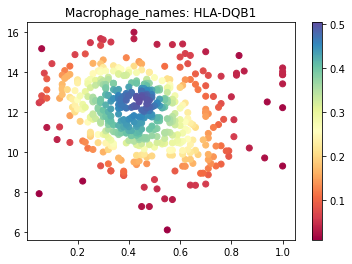

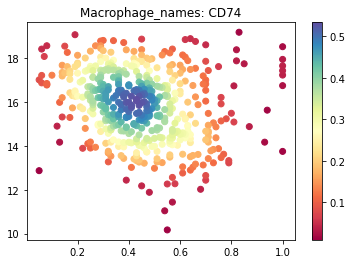

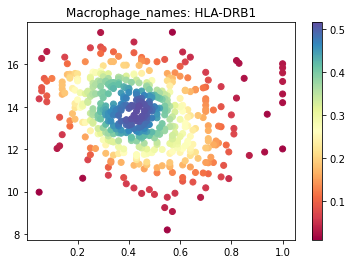

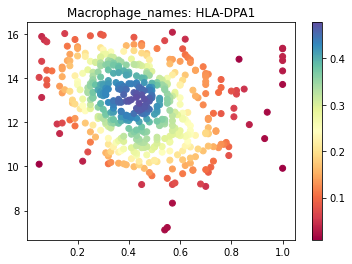

Mast_names


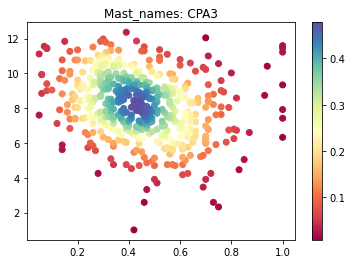

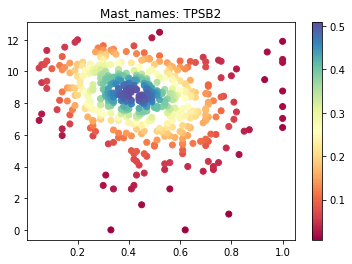

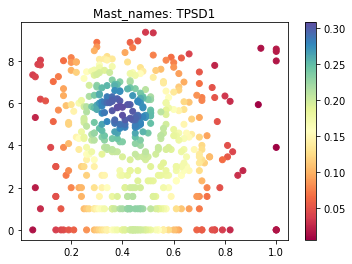

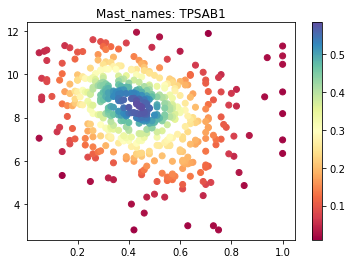

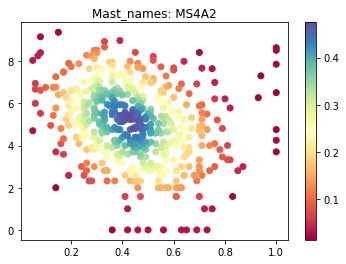

T cell_names


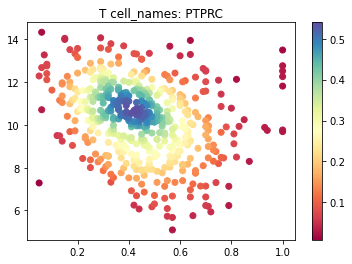

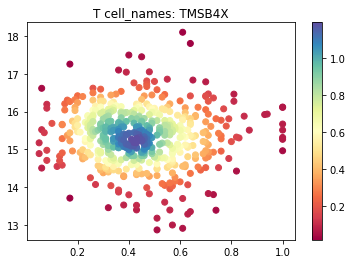

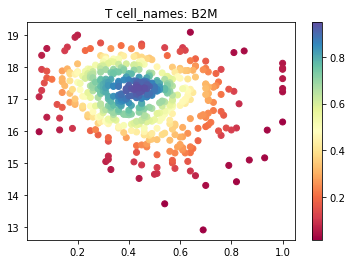

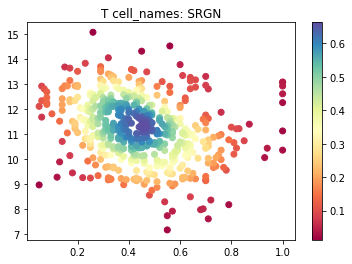

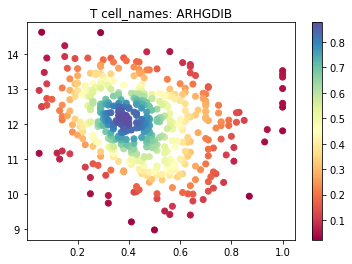

myocyte_names


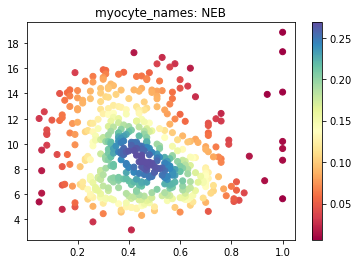

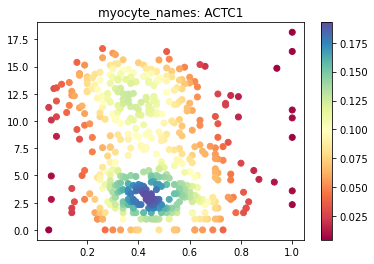

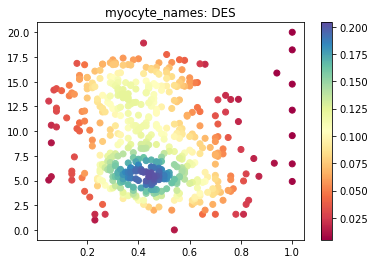

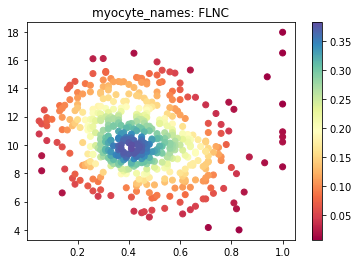

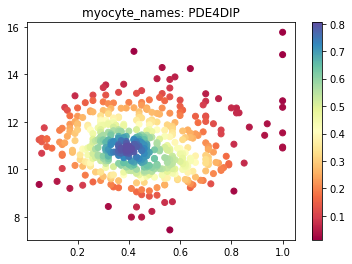

other_names


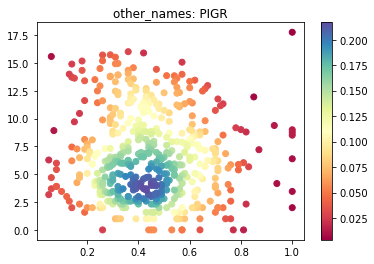

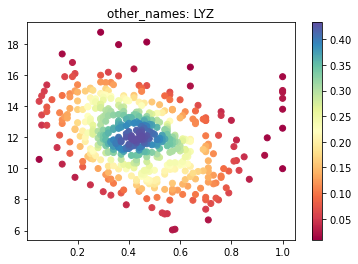

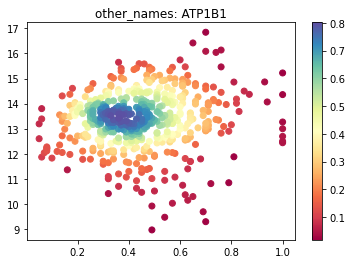

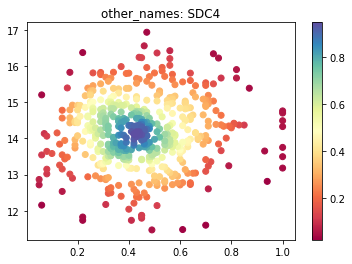

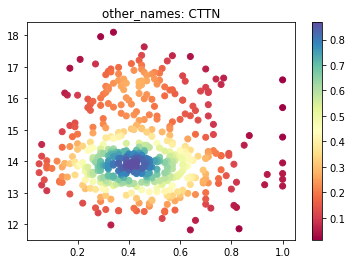

tumor_names


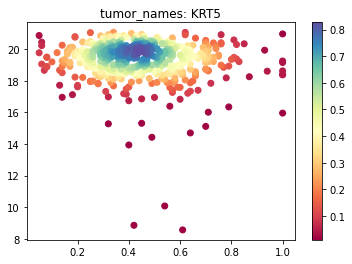

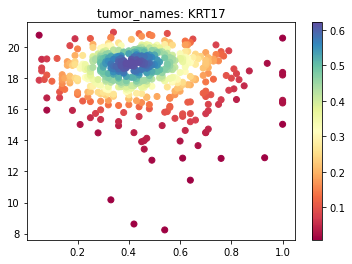

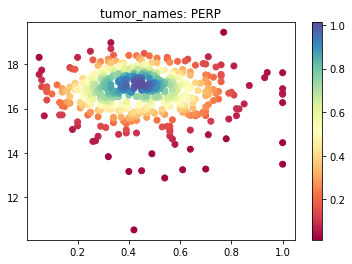

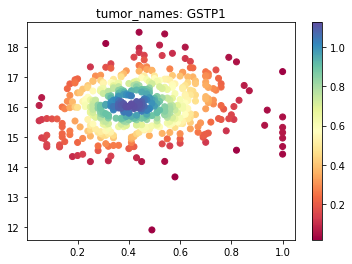

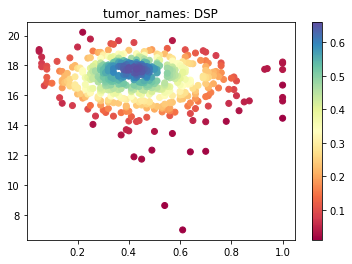

In [28]:
# plot tumor cell percentage vs bulk gene exp for top 5 DEGs in each celltype
for celltype,gene in marker_genes.items():
#     print(gene[:5])
    print(celltype)
    for i in gene[:5]:
        if (df_TCGA_symbol['Gene_symbol'] == i).any() :
            exp_temp = df_TCGA_symbol[df_TCGA_symbol['Gene_symbol'] == i].transpose().drop('Gene_symbol')
            exp_temp.columns = ['exp']
            exp_temp['sample'] = exp_temp.index.str.rstrip('A')
            exp_temp['exp'] = np.log2(exp_temp['exp'].astype(float)+1).fillna(0)
            hnsc_karipurity = exp_temp.merge(cellularity_Kari,left_on='sample',right_on='sample')
            plot_cor_purity_exp(hnsc_karipurity,i,'cellularity',celltype)

In [29]:
# get pearson correlation coef for each marker identified for each celltype
dict_negcor = {}
for celltype,gene in marker_genes.items():
#     print(gene[:5])
    print(celltype)
    dict_negcor[celltype] = {}
    for i in gene:
        if (df_TCGA_symbol['Gene_symbol'] == i).any() :
            exp_temp = df_TCGA_symbol[df_TCGA_symbol['Gene_symbol'] == i].transpose().drop('Gene_symbol')
            exp_temp.columns = ['exp']
            exp_temp['sample'] = exp_temp.index.str.rstrip('A')
            exp_temp['exp'] = np.log2(exp_temp['exp'].astype(float)+1).fillna(0)
            hnsc_karipurity = exp_temp.merge(cellularity_Kari,left_on='sample',right_on='sample')
#             plot_cor_purity_exp(hnsc_karipurity,i,'cellularity',celltype)
            dict_negcor[celltype][i] = pearsonr(hnsc_karipurity['exp'],hnsc_karipurity['cellularity'])[0]

B cell_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Dendritic_names
Endothelial_names
Fibroblast_names
Macrophage_names
Mast_names
T cell_names
myocyte_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


other_names
tumor_names


In [30]:
len(dict_negcor['B cell_names'])

89

In [33]:
dict_negcor['tumor_names']

{'KRT5': -0.0799821489357834,
 'KRT17': -0.09700316136803214,
 'PERP': -0.06485734639460214,
 'GSTP1': 0.12305255629881717,
 'DSP': -0.11729323517182035,
 'FXYD3': 0.0841597876250832,
 'TP63': -0.000189421647965063,
 'JUP': -0.10446407152373278,
 'PKP1': -0.055922022075147654,
 'SDC1': -0.0309760183829643,
 'SFN': -0.12887333205939044,
 'IFI27': -0.15628256929327494,
 'SLC2A1': 0.014480865596548998,
 'MIR205HG': 0.12092018056681586,
 'SPINT2': 0.021017946420763826,
 'DSG3': -0.14257784074053415,
 'KRT6A': -0.21266377777885978,
 'SERPINB5': -0.12657807514877298,
 'PTPRF': 0.051093994890906914,
 'TACSTD2': 0.016794320007464725,
 'TRIM29': -0.07185091771651386,
 'DDR1': 0.0707192197294581,
 'KRT14': -0.2533786184049665,
 'KRT19': 0.16441987460629176,
 'F11R': 0.1960901847441986,
 'CDH1': -0.04014285005467552,
 'DSC3': -0.038048775188995354,
 'CALML3': -0.03899398398473604,
 'ESRG': -0.028004330478241128,
 'GRHL2': 0.05858763805099575,
 'LAMB3': -0.059819010201050765,
 'S100A11': 0.0336421

### Prioritize genes to use: visualization
- negative correlation in tumor purity, cellularity vs DE
- Wilcoxon correlation coefficient vs DE pearson coef

In [35]:
DEG_score = pd.read_csv("/home/cke/Puram/DEGscore_celltype_Puram_wilcoxon.csv",index_col=0)
DEG_score

B cell_names  B cell_scores Dendritic_names  Dendritic_scores  \
0             SSR4      14.109898           LAMP3          7.026286   
1             MZB1      14.054221           BIRC3          6.943695   
2            DERL3      13.625906            CCR7          6.936187   
3           FKBP11      13.051770            LY75          6.729335   
4           SEC11C      12.499027          RASSF4          6.530649   
...            ...            ...             ...               ...   
21191       MYL12B     -10.282371            IFI6         -4.841300   
21192        ANXA1     -10.971279            CTTN         -4.937686   
21193         ACTB     -11.478326            LMNA         -5.037358   
21194         FTH1     -11.824951          IFITM3         -5.286631   
21195       IFITM3     -12.103610          IFITM1         -5.772507   

      Endothelial_names  Endothelial_scores Fibroblast_names  \
0                PECAM1           20.430511         SERPING1   
1                 S1PR1           19.495777            CALD1   
2                 GNG11           19.372541              VIM   
3                   ENG           18.872757             EBF1   
4                 HYAL2           18.770426              C1R   
...                 ...                 ...              ...   
21191             GPNMB          -11.273385           SPINT2   
21192             PTPRS          -11.450020             DSG3   
21193              FTH1          -14.108913             DSC3   
21194          LGALS3BP          -14.343223              EZR   
21195              CD44          -16.540054             F11R   

       Fibroblast_scores Macrophage_names  Macrophage_scores Mast_names  \
0              43.556183          HLA-DRA           7.980516       CPA3   
1              43.277090         HLA-DQB1           7.957897      TPSB2   
2              40.319508             CD74           7.938086      TPSD1   
3              39.416782         HLA-DRB1           7.880963     TPSAB1   
4              39.261066         HLA-DPA1           7.848770      MS4A2   
...                  ...              ...                ...        ...   
21191         -33.063564            SYNE2          -4.767359      GSTP1   
21192         -33.635303             PERP          -4.890602      GAPDH   
21193         -33.810642             EMP2          -5.129659       CTTN   
21194         -34.828120             ENAH          -5.252903       GLG1   
21195         -37.107440             CTTN          -5.731265      ANXA2   

       Mast_scores T cell_names  T cell_scores myocyte_names  myocyte_scores  \
0        13.753589        PTPRC      39.492218           NEB        7.521617   
1        13.752908       TMSB4X      38.990290         ACTC1        7.504745   
2        13.752811          B2M      38.104305           DES        7.493202   
3        13.752325         SRGN      38.003735          FLNC        7.445075   
4        13.642038      ARHGDIB      37.493070       PDE4DIP        7.404761   
...            ...          ...            ...           ...             ...   
21191    -8.892533        HSPB1     -36.043510          MYL6       -5.729009   
21192    -9.342334         CST3     -36.345207        TMSB10       -5.861669   
21193    -9.993061          CD9     -36.458195          PTMA       -6.249352   
21194   -10.489495         CTTN     -37.122150          ACTB       -6.414423   
21195   -10.540019       IFITM3     -37.958090        TMSB4X       -6.453227   

      other_names  other_scores tumor_names  tumor_scores  
0            PIGR     10.747506        KRT5     54.530727  
1             LYZ     10.464463       KRT17     54.346893  
2          ATP1B1     10.324242        PERP     53.148205  
3            SDC4      9.331206       GSTP1     53.125587  
4            CTTN      9.101179         DSP     52.765026  
...           ...           ...         ...           ...  
21191       GAPDH     -9.053160       IKZF3    -33.479485  
21192         VIM     -9.057374         SP

B cell_names


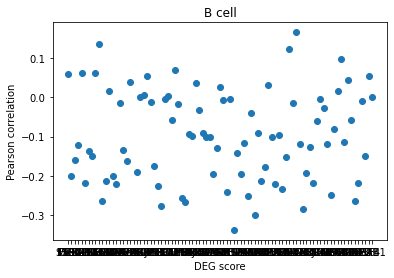

Dendritic_names


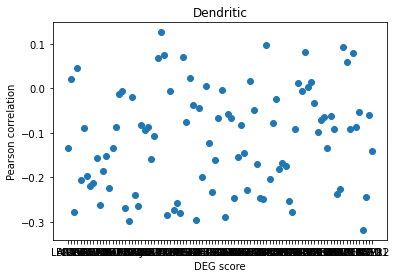

Endothelial_names


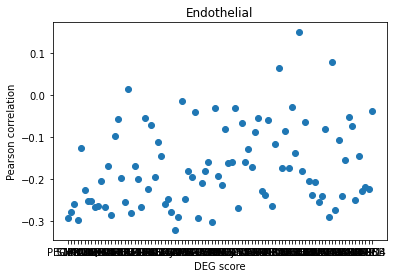

Fibroblast_names


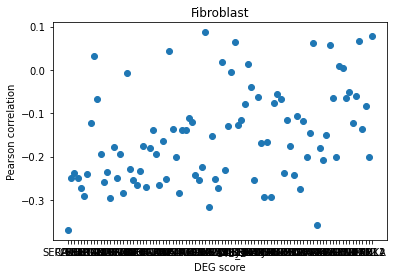

Macrophage_names


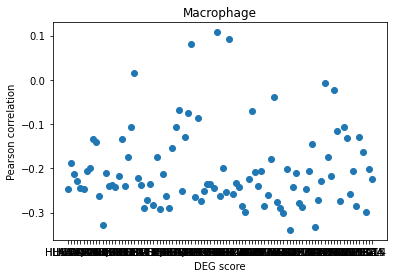

Mast_names


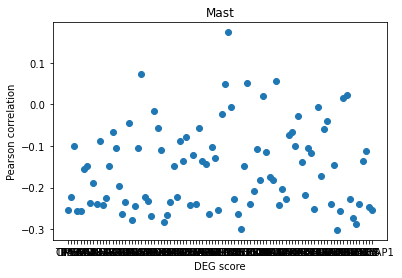

T cell_names


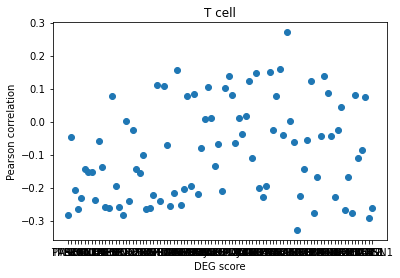

myocyte_names


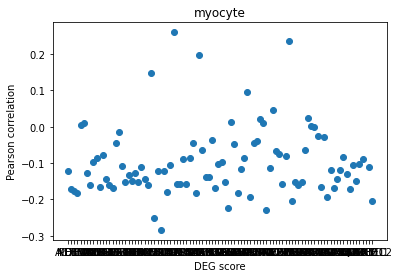

other_names


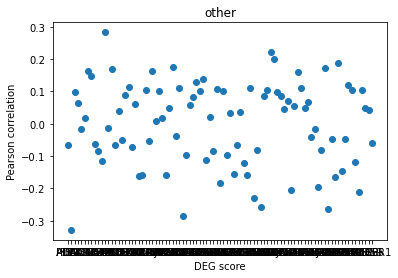

tumor_names


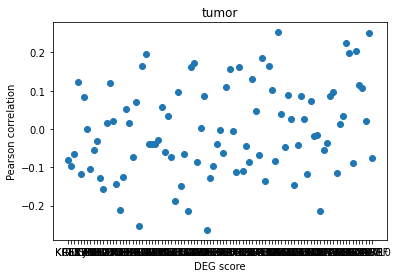

In [36]:
# visualizing neg correlation of cellularity and bulk exp on the x-axis of DEGs
for i in range(0,len(DEG_score.columns.tolist()),2):
    celltype = DEG_score.columns.tolist()[i]
    print(celltype)
    DEG_X = []
    corr_Y = []
    for j in range(len(dict_negcor[celltype].keys())):
#         merge_tmp = pd.merge(pd_negcor,DEG_score,left_on='gene',right_on=DEG_score.columns.tolist()[i])
#         fig = plt.figure()
        DEG_X.append(DEG_score.loc[j][celltype])
        corr_Y.append(dict_negcor[celltype][list(dict_negcor[celltype].keys())[j]])
    plt.scatter(DEG_X,corr_Y)
    plt.xlabel("DEG score")
    plt.ylabel("Pearson correlation")
    plt.title(celltype.split("_")[0])
    plt.show()
#         merge_tmp.plot(DEG_score.columns.tolist()[i]+'_x',celltype+'_pvals',kind='scatter')

In [88]:
mergecriteria = pd.merge(df_TCGA_symbol,DEG_score,left_on='Gene_symbol',right_on='B cell_names',how='inner')
mergecriteria = mergecriteria.iloc[:,-20:]
mergecriteria

B cell_names  B cell_scores Dendritic_names  Dendritic_scores  \
0             TSPAN6      -4.628802        C12orf75         -2.063353   
1               TNMD      -0.049208          PRSS54         -0.004786   
2               DPM1      -3.877796            UBA2         -1.676679   
3              SCYL3      -0.726102           PRKCA         -0.177288   
4           C1orf112      -1.013308       LOC643733         -0.285594   
...              ...            ...             ...               ...   
18347      LINC00550       0.336368            ROR1          0.992117   
18348      LINC00602      -0.137782           H1FNT         -0.019146   
18349        MIR1291      -0.022964      ELOVL2-AS1          0.163398   
18350  GIMAP1-GIMAP5      -0.104976        SNORD42B         -0.012764   
18351        HERC2P7       0.832326         CHORDC1          1.405351   

      Endothelial_names  Endothelial_scores Fibroblast_names  \
0                  HOPX           -3.609243          TMEM208   
1          LOC100507091            0.148605          IFITM4P   
2                  SDHB           -2.822290            ABCC3   
3             LOC606724           -0.234563            CALB2   
4               SLC44A3           -0.410659            MUC20   
...                 ...                 ...              ...   
18347         ANKRD20A1            2.116036           ZBTB10   
18348            GAGE13           -0.014632           SNAP91   
18349             PROX2            0.388235             CFC1   
18350             TXLNB            0.019383     LOC100506124   
18351            TCEAL1            3.133435         ADAMTSL4   

       Fibroblast_scores Macrophage_names  Macrophage_scores Mast_names  \
0             -14.357398            PEBP1          -1.673731      TMCO1   
1              -0.075576             SMG5           0.228491     GUCY2F   
2             -12.153084          SLC35A3          -1.313329     SNRPD3   
3              -2.134295           FAM47E          -0.088986    TP53TG3   
4              -3.025272           MAP6D1          -0.157996      CLCF1   
...                  ...              ...                ...        ...   
18347           1.697222          CCDC106           1.275440     DOPEY2   
18348          -0.275853         USP17L18          -0.005448        ACE   
18349          -0.001257            GPR82           0.367749   SLC22A24   
18350          -0.192763     LOC100507462           0.042512      MUC17   
18351           3.731384           RNASE1           1.792104   MRPS31P5   

       Mast_scores T cell_names  T cell_scores myocyte_names  myocyte_scores  \
0        -4.111518        VPS25     -15.767006       TMEM87B       -2.323162   
1        -0.024897        C1QL2      -0.056838     LOC145845       -0.010123   
2        -3.471683      ANXA2P3     -13.422709        NUP107       -1.921805   
3        -0.553960      SLC29A3      -1.983821       FAM193B       -0.253068   
4        -0.823451        CASC5      -3.113568      CDKN2AIP       -0.383242   
...            ...          ...            ...           ...             ...   
18347     0.821312       PIH1D3       6.961990         TFCP2        0.702551   
18348    -0.083930      IL17REL      -0.215985         CUZD1       -0.033742   
18349    -0.012449       TRIML1       0.013309        ZNF763        0.002397   
18350    -0.059131        WDR38      -0.147779          XCR1       -0.023620   
18351     1.429539         MTX3      11.113393       SLC22A9        1.106483   

      other_names  other_scores   tumor_names  tumor_scores  
0          RBFOX2     -4.179255  LOC100131089     -8.443120  
1        SCARNA13      0.039616         MEF2A     12.017554  
2          TXNRD1     -3.546603          BNC2     -4.475398  
3            RAC3     -0.470502          VWA1      1.933407  
4       PRRT3-AS1     -0.770779        IL17RB      0.899851  
...           ...           ...           ...           ...  
18347      ZNF785      1.884707          ATG3     22.486015  
1834

In [80]:
allgene_bulkexp_cellularity = pd.merge(cellularity_Kari,df_TCGA_t,left_on='sample',right_on='sample')
allgene_bulkexp_cellularity

sample  cellularity  TSPAN6 TNMD    DPM1   SCYL3 C1orf112  \
0    TCGA-CR-7391-01         0.05  2542.0  1.0  1144.0   621.0    338.0   
1    TCGA-CN-6995-01         0.34  1511.0  0.0  2228.0   500.0    622.0   
2    TCGA-CQ-A4C6-01         0.26  1031.0  1.0  2693.0   595.0    422.0   
3    TCGA-CR-6471-01         0.46  1889.0  1.0  1968.0   780.0   1284.0   
4    TCGA-CN-6013-01         0.45   553.0  0.0  1863.0  1042.0    526.0   
..               ...          ...     ...  ...     ...     ...      ...   
486  TCGA-CN-4725-01         0.52  1692.0  0.0  3886.0   704.0    872.0   
487  TCGA-CV-7440-01         0.40  2975.0  0.0  1387.0   390.0    876.0   
488  TCGA-CN-4726-01         0.40  1303.0  0.0  1799.0   403.0    209.0   
489  TCGA-CN-A6V6-01         0.54  3672.0  3.0  1397.0   826.0    534.0   
490  TCGA-CR-6467-01         0.56  3537.0  1.0  4869.0  1623.0   1543.0   

        FGR      CFH   FUCA2  ... LINC00550 LINC01394 LINC00602 MIR1291  \
0    1073.0   6452.0  2029.0  ...       0.0       3.0       0.0     0.0   
1     383.0   1619.0  2247.0  ...       0.0       4.0       0.0     0.0   
2     302.0   3875.0  2832.0  ...       0.0       1.0       1.0     1.0   
3     553.0   3865.0  3254.0  ...       0.0       1.0       0.0     4.0   
4    1357.0   1485.0  2323.0  ...       0.0       1.0       0.0     0.0   
..      ...      ...     ...  ...       ...       ...       ...     ...   
486   279.0   1954.0  5015.0  ...       0.0       0.0       0.0     6.0   
487   306.0  10605.0  2822.0  ...       0.0       0.0       0.0     3.0   
488   228.0   1330.0  1489.0  ...       0.0       5.0       1.0     0.0   
489   424.0   7080.0  2342.0  ...       0.0       1.0       1.0     0.0   
490   997.0   4559.0  3461.0  ...       1.0       2.0       0.0     5.0   

    LINC00891 PAUPAR GIMAP1-GIMAP5 LINC02246 HERC2P7 LINC01144  
0         3.0    0.0           0.0       7.0     0.0      25.0  
1         2.0    0.0           0.0      51.0     0.0      29.0  
2         1.0    0.0           0.0      10.0     0.0      25.0  
3         0.0    0.0           0.0      31.0     0.0       6.0  
4         1.0    0.0           0.0      23.0     2.0      21.0  
..        ...    ...           ...       ...     ...       ...  
486       0.0    0.0           0.0      20.0     0.0      38.0  
487       1.0    1.0           0.0      20.0     0.0       6.0  
488       0.0    0.0           0.0      15.0     0.0       0.0  
489       1.0    0.0           0.0       6.0     0.0      29.0  
490       4.0    1.0           0.0       7.0     0.0     101.0  

[491 rows x 38931 columns]

In [89]:
# making the table for each celltype and gene, the correlation and DE. 
# for sorting and selecting marker genes
list_tcga_genes = df_TCGA_symbol['Gene_symbol'].tolist()
for i in range(0,len(DEG_score.columns.tolist()),2):
    celltype = DEG_score.columns.tolist()[i]
    print(celltype)
    corlist=[]
    for j in DEG_score[celltype]:
        if j in list_tcga_genes: 
            cor = pearsonr(allgene_bulkexp_cellularity['cellularity'],allgene_bulkexp_cellularity[j])[0]
            corlist.append(cor)
    mergecriteria.insert(mergecriteria.shape[1],celltype+'_cor',corlist)
    mergecriteria.insert(mergecriteria.shape[1],celltype+'_scores_rank',mergecriteria[celltype.split('_')[0]+'_scores'].rank(ascending=False).tolist())
    if celltype != 'tumor_names':
        mergecriteria.insert(mergecriteria.shape[1],celltype+'_cor_rank',mergecriteria[celltype+'_cor'].rank(ascending=True).tolist(),)
        joint_rank = 1/mergecriteria[celltype+'_cor_rank']+1/mergecriteria[celltype+'_scores_rank']
        mergecriteria.insert(mergecriteria.shape[1],celltype+'_joint_rank',joint_rank)
    elif celltype == 'tumor_names':
        mergecriteria.insert(mergecriteria.shape[1],celltype+'_cor_rank',mergecriteria[celltype+'_cor'].rank(ascending=False).tolist(),)
        joint_rank = 1/mergecriteria[celltype+'_cor_rank']+1/mergecriteria[celltype+'_scores_rank']
        mergecriteria.insert(mergecriteria.shape[1],celltype+'_joint_rank',joint_rank)

B cell_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Dendritic_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Endothelial_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Fibroblast_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Macrophage_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Mast_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


T cell_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


myocyte_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


other_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


tumor_names


/home/cke/miniconda3/envs/BLADE/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [96]:
mergecriteria.sort_values(['tumor_names_joint_rank'],ascending=[False])

B cell_names  B cell_scores Dendritic_names  Dendritic_scores  \
13250         SSR4      14.109898           LAMP3          7.026286   
3611        MAGOHB      -5.261987           MEAF6         -2.452654   
140          IFRD1       1.429148          AVPR1A          1.754859   
11656         MZB1      14.054221           BIRC3          6.943695   
2020         DERL3      13.625906            CCR7          6.936187   
...            ...            ...             ...               ...   
17331   TIPARP-AS1      -0.321259       LOC440895         -0.059033   
17372          C4A       4.701990         C9orf91          3.460538   
17622         BRK1      -4.280144             PNN         -1.878650   
18139   JMJD1C-AS1      -0.276302           PLGLA         -0.047865   
18258       ZNF670      -0.684611           RBM24         -0.161145   

      Endothelial_names  Endothelial_scores Fibroblast_names  \
13250            PECAM1           20.430511         SERPING1   
3611             GTF2F2           -4.372506            CISD2   
140             CCDC85B            4.130405         ARHGAP42   
11656             S1PR1           19.495777            CALD1   
2020              GNG11           19.372541              VIM   
...                 ...                 ...              ...   
17331            THAP10           -0.063281           PKD1L1   
17372              RPGR            9.346525             UTRN   
17622            MRPS31           -3.230478           GNPTAB   
18139          SNORD45B           -0.048775            AGBL4   
18258             TRPV6           -0.209732          TNFSF14   

       Fibroblast_scores Macrophage_names  Macrophage_scores  ...  \
13250          43.556183          HLA-DRA           7.980516  ...   
3611          -16.370880            MPZL2          -2.026290  ...   
140             5.885684          PCYOX1L           2.233732  ...   
11656          43.277090         HLA-DQB1           7.957897  ...   
2020           40.319508             CD74           7.938086  ...   
...                  ...              ...                ...  ...   
17331          -0.810214           PRSS46          -0.021793  ...   
17372          16.733900             CFL1           4.047793  ...   
17622         -13.353004             ELP2          -1.500876  ...   
18139          -0.671183            KCNJ1          -0.018160  ...   
18258          -1.999934           ADIPOQ          -0.079906  ...   

      myocyte_names_cor_rank  myocyte_names_joint_rank other_names_cor  \
13250                 6792.0                  1.000147       -0.138138   
3611                   764.0                  0.001365        0.038172   
140                  16556.0                  0.001457       -0.024749   
11656                 7214.0                  0.500139        0.086584   
2020                  2192.0                  0.333790        0.235533   
...                      ...                       ...             ...   
17331                16713.0                  0.000198       -0.008931   
17372                  268.0                  0.008913       -0.063731   
17622                 2401.0                  0.000475       -0.076034   
18139                13541.0                  0.000218        0.076951   
18258                 6502.0                  0.000264       -0.060154   

       other_names_scores_rank other_names_cor_rank  other_names_joint_rank  \
13250                      1.0                935.0                1.001070   
3611                   17808.0               7544.0                0.000189   
140                      716.0               3887.0                0.001654   
11656                      2.0              11135.0                0.500090   
2020                       3.0              17771.0                0.333390   
...                        ...                  ...                     ...   
17331                   7250.5               4657.0                0.000353   
17372                    193.0    

In [116]:
mergecriteria.sort_values(['other_names_joint_rank'],ascending=[False])

B cell_names  B cell_scores Dendritic_names  Dendritic_scores  \
13250           SSR4      14.109898           LAMP3          7.026286   
16965      LINC00330      -0.379708          SLC5A9         -0.071797   
11656           MZB1      14.054221           BIRC3          6.943695   
18272        SNORA67      -1.294693           HERC3         -0.411544   
6393          ECHDC3      -0.583931           BRSK2         -0.129235   
...              ...            ...             ...               ...   
14054       C11orf87      -0.275563           GREM2         -0.047865   
14065           DMWD      -1.121288           TMCO4         -0.332896   
14600           GJB3      -4.215458        C12orf23         -1.850119   
16868      LINC00665      -2.230794            MDFI         -0.869546   
17817  SLX1B-SULT1A4      -0.318764         PITPNM3         -0.058095   

      Endothelial_names  Endothelial_scores Fibroblast_names  \
13250            PECAM1           20.430511         SERPING1   
16965         AP4B1-AS1           -0.081302            LASP1   
11656             S1PR1           19.495777            CALD1   
18272            DEPDC5           -0.616273           CDK11A   
6393               ZACN           -0.164124             USF1   
...                 ...                 ...              ...   
14054             SYT10           -0.048775           OR56A5   
14065            ZNF391           -0.480400            AGAP2   
14600           METTL15           -3.167704           SEC23B   
16868             SEC63           -1.406236        TTC28-AS1   
17817           TAS2R31           -0.062330             UTS2   

       Fibroblast_scores Macrophage_names  Macrophage_scores  ...  \
13250          43.556183          HLA-DRA           7.980516  ...   
16965          -1.004578           AKR1D1          -0.029222  ...   
11656          43.277090         HLA-DQB1           7.957897  ...   
18272          -3.944735            INHBA          -0.243350  ...   
6393           -1.683580          SLC46A2          -0.063561  ...   
...                  ...              ...                ...  ...   
14054          -0.665996           FRMPD2          -0.018160  ...   
14065          -3.383118            CECR2          -0.187052  ...   
14600         -13.183846            MED18          -1.462657  ...   
16868          -7.049630            DHX29          -0.600780  ...   
17817          -0.806166        LINC00597          -0.021793  ...   

      myocyte_names_cor_rank  myocyte_names_joint_rank other_names_cor  \
13250                 6792.0                  1.000147       -0.138138   
16965                 2953.0                  0.000470       -0.320201   
11656                 7214.0                  0.500139        0.086584   
18272                    2.0                  0.500088       -0.313414   
6393                 11399.0                  0.000203       -0.308167   
...                      ...                       ...             ...   
14054                 2872.0                  0.000492             NaN   
14065                13837.0                  0.000165             NaN   
14600                 6280.0                  0.000218             NaN   
16868                 3968.0                  0.000323             NaN   
17817                 5170.0                  0.000331             NaN   

       other_names_scores_rank other_names_cor_rank  other_names_joint_rank  \
13250                      1.0                935.0                1.001070   
16965                   7614.0                  1.0                1.000131   
11656                      2.0              11135.0                0.500090   
18272                  11361.0                  2.0                0.500088   
6393                    8642.0                  3.0                0.333449   
...                        ...                  ...                     ...   
14054                   6950.0                  NaN                     NaN   
14065       

In [122]:
# IMPORTANT STEP!
# marker selection, condition: exist in both tcga and puram datasets, cor <0 (neg) for immunce cells and >0(pos) for tumor, 
# stronger DE, secondary criteria: stronger neg/pos correlatino)
def get_markers(DEG_score, mergecriteria,num=100):
    dict_markers = {}
    markers = []
    for i in range(0,len(DEG_score.columns.tolist()),2):
        celltype = DEG_score.columns.tolist()[i]
        if celltype != 'tumor_names':
            candidate = mergecriteria.sort_values([celltype+'_joint_rank'],ascending=[False])
    #         candidate = candidate[candidate[celltype+'_cor'] < 0]
            markers.extend(candidate[celltype][:num].tolist())
            dict_markers[celltype.split("_")[0]] = candidate[celltype][:num].tolist()
        else: 
            candidate = mergecriteria.sort_values([celltype+'_joint_rank'],ascending=[False])
            markers.extend(candidate[celltype][:num].tolist())
            dict_markers[celltype.split("_")[0]] = candidate[celltype][:num].tolist()
    markers = pd.DataFrame(markers).drop_duplicates(keep=False)
    return dict_markers, markers

In [108]:
num = 100
dict_markers = {}
markers = []
for i in range(0,len(DEG_score.columns.tolist()),2):
    celltype = DEG_score.columns.tolist()[i]
    if celltype != 'tumor_names':
        candidate = mergecriteria.sort_values([celltype+'_joint_rank'],ascending=[False])
#         candidate = candidate[candidate[celltype+'_cor'] < 0]
        markers.extend(candidate[celltype][:num].tolist())
        dict_markers[celltype.split("_")[0]] = candidate[celltype][:num].tolist()
    else: 
        candidate = mergecriteria.sort_values([celltype+'_joint_rank'],ascending=[False])
        markers.extend(candidate[celltype][:num].tolist())
        dict_markers[celltype.split("_")[0]] = candidate[celltype][:num].tolist()

In [142]:
markers_100

0
0      RPS27L
1        SSR4
2     SNORD95
3        MZB1
4    FAM189A2
..        ...
994       CD9
996       HN1
997    GATSL2
998   FAM102B
999     LYPD3

[898 rows x 1 columns]

In [141]:
# Get top 100(or the number you want) markers
dict_markers_100, markers_100 = get_markers(DEG_score, mergecriteria,num=100)
# markers_100.to_csv("./Puram/top100markers_de_cor_symbol.txt",header=False, index=False)
print(len(markers_100))

898


In [136]:
dict_markers_50, markers_50 = get_markers(DEG_score, mergecriteria,num=50)
print(len(markers_50))

467


In [139]:
dict_markers_20, markers_20 = get_markers(DEG_score, mergecriteria,num=20)
print(len(markers_20))

198


In [144]:
import csv
with open("./Puram/top100markers_de_cor_symbol.txt",'w') as f:
    write = csv.writer(f)
    write.writerow(markers_100[0])

In [145]:
import csv
with open("./Puram/top50markers_de_cor_symbol.txt",'w') as f:
    write = csv.writer(f)
    write.writerow(markers_50[0])

In [146]:
import csv
with open("./Puram/top20markers_de_cor_symbol.txt",'w') as f:
    write = csv.writer(f)
    write.writerow(markers_20[0])

### Benchmarking of results: tumor cell percentage in dna and decon

In [122]:
BP_celltypefrac['sample'] = BP_celltypefrac.index.tolist()
BP_celltypefrac['sample'] = BP_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
MuSiC_celltypefrac['sample'] = MuSiC_celltypefrac.index.tolist()
MuSiC_celltypefrac['sample'] = MuSiC_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
BLADE_celltypefrac['sample'] = BLADE_celltypefrac.index.tolist()
BLADE_celltypefrac['sample'] = BLADE_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
CIBERSORTx_celltypefrac['sample'] = CIBERSORTx_celltypefrac.index.tolist()
CIBERSORTx_celltypefrac['sample'] = CIBERSORTx_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
NNLS_celltypefrac['sample'] = NNLS_celltypefrac.index.tolist()
NNLS_celltypefrac['sample'] = NNLS_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')

/tmp/ipykernel_24656/1530786402.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  BP_celltypefrac['sample'] = BP_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
/tmp/ipykernel_24656/1530786402.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  MuSiC_celltypefrac['sample'] = MuSiC_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
/tmp/ipykernel_24656/1530786402.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  BLADE_celltypefrac['sample'] = BLADE_celltypefrac['sample'].str.replace('.','-').str.r

In [123]:
NNLS_noFS_celltypefrac['sample'] = NNLS_noFS_celltypefrac.index.tolist()
NNLS_noFS_celltypefrac['sample'] = NNLS_noFS_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
MuSiC_noFS_celltypefrac['sample'] = MuSiC_noFS_celltypefrac.index.tolist()
MuSiC_noFS_celltypefrac['sample'] = MuSiC_noFS_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')

/tmp/ipykernel_24656/3831294094.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  NNLS_noFS_celltypefrac['sample'] = NNLS_noFS_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')
/tmp/ipykernel_24656/3831294094.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  MuSiC_noFS_celltypefrac['sample'] = MuSiC_noFS_celltypefrac['sample'].str.replace('.','-').str.rstrip('A')


In [17]:
BLADE_celltype_cellularity[BLADE_celltype_cellularity['cellularity']==1]

NameError: name 'BLADE_celltype_cellularity' is not defined

<AxesSubplot:xlabel='method'>

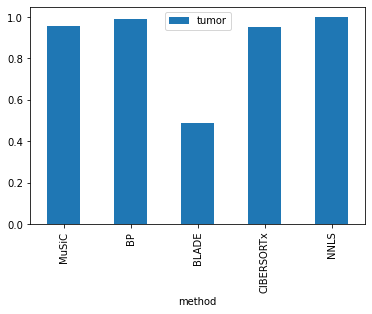

In [158]:
# check for one sample with cellularity 1.0
df_list = [MuSiC_celltype_cellularity, BP_celltype_cellularity, BLADE_celltype_cellularity, CIBERSORTx_celltype_cellularity, NNLS_celltype_cellularity]
df_checkcellularity = pd.concat(df[df['sample']=='TCGA-CN-5365-01'] for df in df_list)
df_checkcellularity.insert(0,'method', ['MuSiC','BP','BLADE','CIBERSORTx','NNLS'])
df_checkcellularity.plot(y='tumor',x='method',kind='bar')

<AxesSubplot:xlabel='method'>

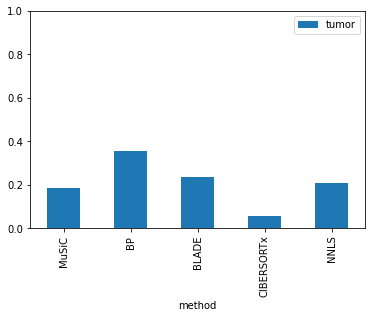

In [160]:
# check for one sample with cellularity 1.0
df_list = [MuSiC_celltype_cellularity, BP_celltype_cellularity, BLADE_celltype_cellularity, CIBERSORTx_celltype_cellularity, NNLS_celltype_cellularity]
df_checkcellularity = pd.concat(df[df['sample']=='TCGA-CV-5971-01'] for df in df_list)
df_checkcellularity.insert(0,'method', ['MuSiC','BP','BLADE','CIBERSORTx','NNLS'])
df_checkcellularity.plot(y='tumor',x='method',kind='bar',ylim=[0,1])

In [85]:
def plot_estimates_cellularity(method_celltypefrac,cellularity_Kari):
    celltype_cellularity = pd.merge(method_celltypefrac,cellularity_Kari,on='sample')
    celltype_cellularity.plot('cellularity','tumor',kind='scatter',xlabel='DNA cellularity',ylabel='Estimated tumor percentage')
    pearsoncorr = pearsonr(celltype_cellularity['tumor'],celltype_cellularity['cellularity'])[0]
    rmse = mean_squared_error(celltype_cellularity['cellularity'], celltype_cellularity['tumor'], squared=False)
    r2 = r2_score(celltype_cellularity['cellularity'], celltype_cellularity['tumor'])
    print('Pearson\'s correlation: ',pearsoncorr,'rmse: ',rmse ,"r2 score: ",r2)
    return celltype_cellularity,pearsoncorr,rmse

Pearson's correlation:  0.07412348714227282 rmse:  0.41464817165184825 r2 score:  -4.2263415191390346


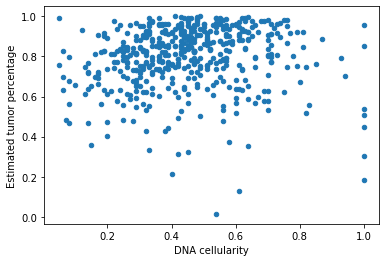

In [127]:
MuSiC_celltype_cellularity,MuSiC_pearsoncorr,MuSiC_rmse = plot_estimates_cellularity(MuSiC_celltypefrac,cellfularity_Kari)

Pearson's correlation:  0.14358006483209063 rmse:  0.47396398116250354 r2 score:  -5.828557231342391


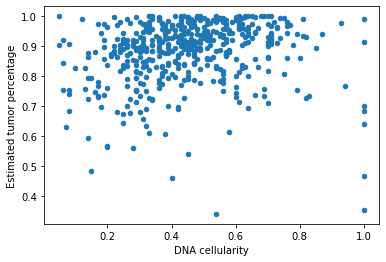

In [128]:
BP_celltype_cellularity,BP_pearsoncorr,BP_rmse = plot_estimates_cellularity(BP_celltypefrac,cellularity_Kari)

Pearson's correlation:  -0.055728685045289154 rmse:  0.21198337998509864 r2 score:  -0.3659723270399524


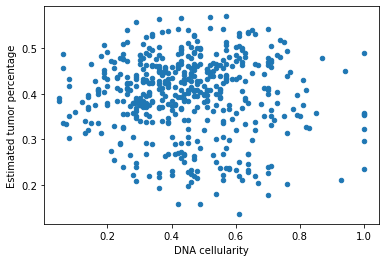

In [129]:
BLADE_celltype_cellularity,BLADE_pearsoncorr,BLADE_rmse = plot_estimates_cellularity(BLADE_celltypefrac,cellularity_Kari)

Pearson's correlation:  0.0638519988300264 rmse:  0.41988392606049624 r2 score:  -4.359160636041914


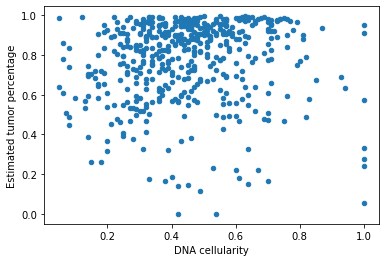

In [130]:
CIBERSORTx_celltype_cellularity,CIBERSORTx_pearsoncorr,CIBERSORTx_rmse = plot_estimates_cellularity(CIBERSORTx_celltypefrac,cellularity_Kari)

Pearson's correlation:  -0.1823712931796504 rmse:  0.5167300811254149 r2 score:  -7.11644341140795


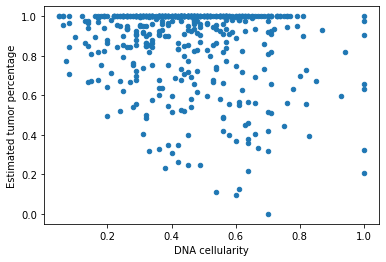

In [131]:
NNLS_celltype_cellularity,NNLS_pearsoncorr,NNLS_rmse = plot_estimates_cellularity(NNLS_celltypefrac,cellularity_Kari)

Pearson's correlation:  -0.1468283142922314 rmse:  0.5208727145684179 r2 score:  -7.247104392911194


(-0.1468283142922314, 0.5208727145684179)

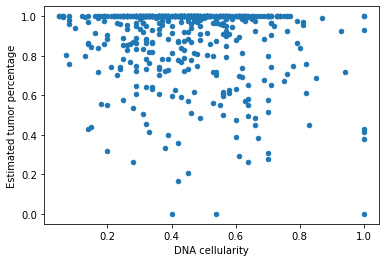

In [108]:
plot_estimates_cellularity(NNLS_noFS_celltypefrac,cellularity_Kari)